<a href="https://colab.research.google.com/github/jbaremoney/UpsetsPropertiesThresholds/blob/main/popup_training_zeroTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install medmnist

  Using cached medmnist-3.0.2-py3-none-any.whl.metadata (14 kB)
  Using cached fire-0.7.0.tar.gz (87 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.w

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import torch.autograd as autograd
import math
import medmnist
from medmnist import INFO, Evaluator
from matplotlib import pyplot as plt
from itertools import combinations_with_replacement

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [7]:

def getTrainingDataLoaders(data_set_name, download=True, BATCH_SIZE=128):
    data_flag = data_set_name
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # preprocessing: handle 1-channel, 3-channel, or others
    if n_channels == 3:
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])
    elif n_channels == 1:
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])
    else:
        # Default transform if n_channels is not 1 or 3.
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*n_channels, std=[0.5]*n_channels)
        ])

    train_dataset = DataClass(split='train', transform=data_transform, download=download)
    test_dataset = DataClass(split='test', transform=data_transform, download=download)

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
    return info, task, n_classes, train_loader, train_loader_at_eval, test_loader


## Now, we define a maskable base model that will, after masking, serve as the classifier.  We also specify the loss object function, and set up an optimizer that we use to train the classifier.

In [44]:

from os import initgroups

# The default value of the parameter between 0 and 1 specifying the percentage
# of the model's weights that will be masked in each layer.
K = 1.0

# Set up signed Kaiming initialization.
def signed_kaiming_constant_(tensor, a=0, mode='fan_in', nonlinearity='relu', k=1., sparsity =0):

    fan = nn.init._calculate_correct_fan(tensor, mode)  # calculating correct fan, depends on shape and type of nn
    gain = nn.init.calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan))
    # scale by (1/sqrt(k))
    if k != 0:
        std *= (1 / math.sqrt(k))

    with torch.no_grad():
        tensor.uniform_(-std, std)
        if sparsity > 0:
            mask = (torch.rand_like(tensor) > sparsity).float()  # Keeps (1 - sparsity)% weights

            tensor *= mask
        return tensor


# A function to retreive a subset of the top k% of the weights by their score.
# The gradient is estimated by the identity (i.e. it goes "straight-through").
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)

class GetSubnet(autograd.Function):

    @staticmethod
    def forward(ctx, scores, k):

        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1-k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, grad):

        # send the gradient g straight-through on the backward pass.
        return grad, None

# Our maskable replacement for the standard linear layer in torch.
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)
class LinearSubnet(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, k=1, sparsity=0., zeroTrack=0.0,
                 init=signed_kaiming_constant_, weight=None, full_popup_scores=None,**kwargs):
        super(LinearSubnet, self).__init__(in_features, out_features, bias=bias, **kwargs)
        '''
        full_popup_scores must be the same size as weight
        '''

        self.k = k
        self.sparsity = sparsity
        self.zeroTrack = zeroTrack

        if weight is not None:

            self.weight = nn.Parameter(weight)
        else:
            init(self.weight, k=k, sparsity=sparsity)


        # Save the full initial weight matrix for testing.
        self.initial_weight = self.weight.clone().detach()

        if full_popup_scores is not None:
          self.full_popup_scores = nn.Parameter(full_popup_scores)
        else:
          self.full_popup_scores = torch.randn_like(self.weight).requires_grad_(False)
          #detach from comp graph ?

        # Create a tracking mask: always track nonzero weights.
        zero_mask = self.weight == 0
        nonzero_mask = self.weight != 0

        tracking_mask = torch.ones_like(self.weight, dtype=bool) #if popups is full it's all true

        zero_mask.requires_grad_(False)
        tracking_mask.requires_grad_(False)
        self.full_popup_scores.requires_grad_(False)

        # zeros that are being tracked currently mask
        tracking_zero_mask = zero_mask.logical_and(tracking_mask)

        num_zeros_to_track = int(self.zeroTrack * zero_mask.sum().item())
        print(f"num_zeros_to_track: {num_zeros_to_track}") #CORRECT
        print(f"full tracking zeros:{tracking_zero_mask.sum().item()}")#CORRECT

        if num_zeros_to_track < tracking_zero_mask.sum().item():
            # reset (num_zeros_to_track - tracking_zero_mask.sum.item) of the tracking zeros to 0.
            # then we will only be tracking (num_zeros_to_track) zeros
            flat_mask = tracking_zero_mask.view(-1)


            tracked_zero_indices = torch.nonzero(flat_mask, as_tuple=False).view(-1)

            # index corresponds to position in flat mask, indices of true values in flat mask

            #randomly keep correct amount of 0's popups
            keep_indices = tracked_zero_indices[torch.randperm(len(tracked_zero_indices))[:num_zeros_to_track]]


            #still want same shape
            new_flat_mask = torch.zeros_like(flat_mask, dtype=torch.bool)#same shape as weight
            new_flat_mask[keep_indices] = True #true in all the keeping 0 indices

            # ie 0 weight but we want to have popup for it

            final_tracking_zero_mask = new_flat_mask.view(tracking_zero_mask.shape)
            tracking_mask = nonzero_mask.logical_or(final_tracking_zero_mask)


        self.tracking_mask = tracking_mask # final tracking mask

        #need for forward pass
        self.weight_values = nn.Parameter(self.weight[tracking_mask]).requires_grad_(False)
        self.weight_indices = torch.nonzero(tracking_mask, as_tuple=True) #same

        self.popup_scores = nn.Parameter(self.full_popup_scores[self.tracking_mask]).requires_grad_(True)


        self.weight.requires_grad_(False)
        if self.bias is not None:
            self.bias.requires_grad_(False)

    def forward(self, x):


         # Get the subnetwork by sorting the scores.
         adj = GetSubnet.apply(self.popup_scores.abs(), self.k)  # applying getSubnet
         # adj is the mask with only highest k% popup scores kept, others zeroed
         # PROBLEM: we sorted the popup scores. the corresponding indices didn't
         # get sorted with it
         # SOLVED: he used idx for list of indexes, which will preserve our indexes corresponding

         # Use only the subnetwork in the forward pass.
         # this masks the nonzero weights
         wPre = self.weight_values * adj

         # getting shape of weight matrix
         w = torch.zeros_like(self.initial_weight)

         # setting each weight to updated, see weight_indices variable for comment
         w[self.weight_indices] = wPre  # vectorized assignment instead of loop

         x = F.linear(x, w)

         return x


# Our maskable replacement for the standard 2d convolutional layer in torch.
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)
class Conv2dSubnet(nn.Conv2d):

    def __init__(self, *args, k=K, init=signed_kaiming_constant_, **kwargs):
        super(Conv2dSubnet, self).__init__(*args, **kwargs)
        self.k = k
        self.popup_scores = nn.Parameter(torch.randn(*self.weight.shape))

        # init weights
        init(self.weight, k=k)

        # disable grad for the original parameters
        self.weight.requires_grad_(False)
        if self.bias is not None:
            self.bias.requires_grad_(False)

    # self.k is the % of weights remaining, a real number in [0,1]
    # self.popup_scores is a Parameter which has the same shape as self.weight

    def forward(self, x):


        # Get the subnetwork by sorting the scores.
        adj = GetSubnet.apply(self.popup_scores.abs(), self.k)

        # Use only the subnetwork in the forward pass.
        w = self.weight * adj
        x = F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x




class Network(nn.Module):
    def __init__(self, layer_sizes, maskable=False, k=K, sparsity=0., zeroTrack=0,init=signed_kaiming_constant_, weight=None, popups=None):
        super().__init__()
        self.flatten = nn.Flatten()
        if weight is None:
          weight = [None] * len(layer_sizes)
        if popups is None:
          popups = [None] * len(layer_sizes)
        # this looks weird but makes sense since LinearSubnet handles None
        # also needs to be array because we access index below

        # self.router = None
        if maskable:
            if isinstance(k, (int, float)):
                self.linear_relu_stack = nn.Sequential(
                    *[z for i, l in enumerate(layer_sizes)
                      for z in [LinearSubnet(
                          l[0], l[1],
                          k=k,
                          sparsity=sparsity,
                          zeroTrack=zeroTrack,
                          weight=weight[i],
                          full_popup_scores=popups[i]
                      ), nn.ReLU()]][:-1]
                )
            else:
                self.linear_relu_stack = nn.Sequential(
                    *[z for i, l in enumerate(layer_sizes)
                      for z in [LinearSubnet(
                          l[0], l[1],
                          k=k[i],
                          sparsity=sparsity,
                          zeroTrack=zeroTrack,
                          weight=weight[i],
                          full_popup_scores=popups[i]
                      ), nn.ReLU()]][:-1]
                )
        else:
            self.linear_relu_stack = nn.Sequential(
                *[z for l in layer_sizes
                  for z in [nn.Linear(l[0], l[1]), nn.ReLU()]][:-1]
            )

    def count_nonzero_weights(self):
      total_nonzeros = 0
      for layer in self.linear_relu_stack:
        if hasattr(layer, 'weight'):  # Works for LinearSubnet or nn.Linear
            total_nonzeros += (layer.weight != 0).sum().item()
      return total_nonzeros

    def count_total_weights(self):
      total = 0
      for layer in self.linear_relu_stack:
        if hasattr(layer, 'weight'):
            total += layer.weight.numel()
      return total

    def count_total_popup_scores(model):
      total_scores = 0
      for layer in model.linear_relu_stack:
        if isinstance(layer, LinearSubnet) and hasattr(layer, 'popup_scores'):
            total_scores += layer.popup_scores.numel()
      return total_scores


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:

from sklearn.metrics import roc_auc_score, accuracy_score
import torch

In [9]:
# Define a training function that returns a list of the losses during training.
def trainit(model,
            NUM_EPOCHS,
            train_loader,
            optimizer,
            task,
            n_classes,
            return_losses=False,
            no_progress=False):
  # define loss function
  if task == "multi-label, binary-class":
      criterion = nn.BCEWithLogitsLoss()
  else:
      criterion = nn.CrossEntropyLoss()
  if return_losses:
      losses = []
  # iterate over epochs for training run
  for epoch in range(NUM_EPOCHS):
      train_correct = 0
      train_total = 0
      test_correct = 0
      test_total = 0

      model.train()
      if no_progress:
        loader = train_loader
      else:
        loader=tqdm(train_loader)
      for inputs, targets in loader:
          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)[:,0:n_classes]
          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze(1).long()
              loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          if return_losses:
              losses.append(loss.item())
  if return_losses:
      return losses

# Define an evaluation function
def test(split,
         model,
         train_loader_at_eval,
         test_loader,
         task,
         n_classes,
         data_flag,
         return_metrics=False):
    # define loss function
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)[:,0:n_classes]

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze(1).long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        if return_metrics:
          return metrics

In [ ]:
'''
need to plot compute time as a function of sparsity
'''

'\nneed to plot compute time as a function of sparsity\n'

In [ ]:
# this function will get the best mask in a model.
def get_best_mask(model, data_set_name, NUM_EPOCHS=3, vary_k_by_layer=False, num_ks_to_test=11, return_to_initial_popup_scores = False, return_metrics=False, no_progress=False):
  info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
  best_mask = None
  best_test = 0
  best_k = None
  if return_metrics:
    metrics = []
  if vary_k_by_layer:
    num_combinations=len(model.linear_relu_stack[::2])
  else:
    num_combinations=1
  for K in combinations_with_replacement(np.linspace(0,1.0,num_ks_to_test),num_combinations):
      print('------------------')
      print('K: '+str(K))
      for i,layer in enumerate(model.linear_relu_stack[::2]):
        if return_to_initial_popup_scores:
          layer.popup_scores = layer.initial_popup_scores
        if vary_k_by_layer:
          layer.k = K[i]
        else:
          layer.k = K[0]
      trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()), task, n_classes, no_progress=no_progress)
      print('==> Evaluating ...')
      this_k_train_metrics=test('test',model,train_loader_at_eval, test_loader,task, n_classes, data_set_name, return_metrics=True)
      if this_k_train_metrics[1] >= best_test:
        best_test = this_k_train_metrics[1]
        best_mask = [layer.popup_scores.clone() for layer in model.linear_relu_stack[::2]]
        best_k=K
      if return_metrics:
        this_k_test_metrics = test('test' ,model,train_loader_at_eval, test_loader,task, n_classes, data_set_name, return_metrics=True)
        metrics.append(tuple(K+[this_k_test_metrics[1]]))
  if return_metrics:
    return best_mask, best_test, best_k, metrics
  else:
    return best_mask, best_test, best_k

In [39]:
model = Network(layer_sizes=[[25, 10], [10,10],[10,2]], maskable=True, k=1.,sparsity=0.2, zeroTrack=0.2)
print(f"Total weights: {model.count_total_weights()}")
print(f"Total nonzero weights: {model.count_nonzero_weights()}")
print(f"Total popup scores: {model.count_total_popup_scores()}")
# model = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True, k=K, sparsity=sparsity, zeroTrack=1)

num_zeros_to_track: 8
full tracking zeros:43
num_zeros_to_track: 3
full tracking zeros:17
num_zeros_to_track: 1
full tracking zeros:7
Total weights: 370
Total nonzero weights: 303
Total popup scores: 315


In this example, we loop over different K values from 1.0 down to 0.0 (decrementing by 0.1 each iteration) and compare the results to a non-masked model of the same size trained in the usual way.  Notice, in this situation, we are NOT changing the weights as we decrease K.  This is important, since the intialization of the network is done with K in mind.

In [49]:
data_set_name='breastmnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
# print(train_dataset)
# print("===================")
# print(test_dataset)
# # montage (note, this will not show the grayscale version of the image if it is
# # in color, but that is ok).
# train_dataset.montage(length=20)
'''
Need to write function that will show how accuracy scales with sparsity
How compute time scales with sparsity
How compute time scales with sparsity and number of nonzero weights tracking

'''
'''
model = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True, k=1.0, init=signed_kaiming_constant_(sparsity=0.))
# model = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True
model2 = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]])
'''

NUM_EPOCHS=3
sparsity_values = np.linspace(.1,.9, 5)
k_values = np.linspace(0.,1.,11)
zeroTrack_values = np.linspace(0.,1.,11)

accuracy_surface = np.zeros((len(sparsity_values), len(k_values), len(zeroTrack_values)))
best_zeroTrack_map = np.zeros((len(sparsity_values), len(k_values)))


for k_idx, K in enumerate(k_values):
  for s_idx, s in enumerate(sparsity_values):
    sparsity=s
    modelBase = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True, k=K, sparsity=sparsity, zeroTrack=1)

    initial_weights=[layer.weight.clone().detach() for layer in modelBase.linear_relu_stack if isinstance(layer, LinearSubnet)]
    full_popup_scores=[layer.full_popup_scores.clone().detach() for layer in modelBase.linear_relu_stack if isinstance(layer, LinearSubnet)]
    #popup scores should be full since initialized with zeroTrack=1
    best_acc = -1
    best_zeroTrack = 0.0

    for z_idx, z in enumerate(zeroTrack_values):
      zeroTrack=1-z

      model = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True, k=K, zeroTrack=zeroTrack, weight=initial_weights, popups=full_popup_scores)
      num_nonzero_weights = model.count_nonzero_weights()
      num_total_weights = model.count_total_weights()
      num_zero_weights = num_total_weights-num_nonzero_weights

      sparsity_realized = num_zero_weights / num_total_weights

      print(f"total weights: {num_total_weights}")
      print(f"nonzero weights: {num_nonzero_weights}")
      print(f"zero weights: {num_zero_weights}")

      print(f"expected sparsity: {sparsity}")
      print(f'realized sparsity: {sparsity_realized}')

      print(f'zeroTrack:{zeroTrack}')
      print(f'expected num popups: {num_nonzero_weights + (int(zeroTrack * num_zero_weights))}')
      print(f'realized num popups: {model.count_total_popup_scores()}')
      print('-----------')

      optimizer = optim.Adam(model.parameters())
      losses = trainit(model, NUM_EPOCHS, train_loader, optimizer, task, n_classes)

      metrics = test('test', model, train_loader_at_eval, test_loader, task, n_classes, data_set_name, return_metrics=True)
      accuracy = metrics[1]

      accuracy_surface[s_idx, k_idx, z_idx] = accuracy

      if accuracy > best_acc:
          best_acc = accuracy
          best_zeroTrack = zeroTrack

    best_zeroTrack_map[s_idx, k_idx] = best_zeroTrack

num_zeros_to_track: 19938
full tracking zeros:19938
num_zeros_to_track: 6381
full tracking zeros:6381
num_zeros_to_track: 47
full tracking zeros:47
num_zeros_to_track: 19938
full tracking zeros:19938
num_zeros_to_track: 6381
full tracking zeros:6381
num_zeros_to_track: 47
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.48it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 17944
full tracking zeros:19938
num_zeros_to_track: 5742
full tracking zeros:6381
num_zeros_to_track: 42
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.9
expected num popups: 264115
realized num popups: 264114
-----------


100%|██████████| 5/5 [00:00<00:00, 14.45it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 15950
full tracking zeros:19938
num_zeros_to_track: 5104
full tracking zeros:6381
num_zeros_to_track: 37
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.8
expected num popups: 261478
realized num popups: 261477
-----------


100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 13956
full tracking zeros:19938
num_zeros_to_track: 4466
full tracking zeros:6381
num_zeros_to_track: 32
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.7
expected num popups: 258842
realized num popups: 258840
-----------


100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 11962
full tracking zeros:19938
num_zeros_to_track: 3828
full tracking zeros:6381
num_zeros_to_track: 28
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.6
expected num popups: 256205
realized num popups: 256204
-----------


100%|██████████| 5/5 [00:00<00:00, 14.50it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 9969
full tracking zeros:19938
num_zeros_to_track: 3190
full tracking zeros:6381
num_zeros_to_track: 23
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.5
expected num popups: 253569
realized num popups: 253568
-----------


100%|██████████| 5/5 [00:00<00:00, 14.65it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 7975
full tracking zeros:19938
num_zeros_to_track: 2552
full tracking zeros:6381
num_zeros_to_track: 18
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.3999999999999999
expected num popups: 250932
realized num popups: 250931
-----------


100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 5981
full tracking zeros:19938
num_zeros_to_track: 1914
full tracking zeros:6381
num_zeros_to_track: 14
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.29999999999999993
expected num popups: 248295
realized num popups: 248295
-----------


100%|██████████| 5/5 [00:00<00:00, 10.67it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 3987
full tracking zeros:19938
num_zeros_to_track: 1276
full tracking zeros:6381
num_zeros_to_track: 9
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.19999999999999996
expected num popups: 245659
realized num popups: 245658
-----------


100%|██████████| 5/5 [00:00<00:00, 14.92it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 1993
full tracking zeros:19938
num_zeros_to_track: 638
full tracking zeros:6381
num_zeros_to_track: 4
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.09999999999999998
expected num popups: 243022
realized num popups: 243021
-----------


100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 0
full tracking zeros:19938
num_zeros_to_track: 0
full tracking zeros:6381
num_zeros_to_track: 0
full tracking zeros:47
total weights: 266752
nonzero weights: 240386
zero weights: 26366
expected sparsity: 0.1
realized sparsity: 0.09884087092130518
zeroTrack:0.0
expected num popups: 240386
realized num popups: 240386
-----------


100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 60379
full tracking zeros:60379
num_zeros_to_track: 19495
full tracking zeros:19495
num_zeros_to_track: 153
full tracking zeros:153
num_zeros_to_track: 60379
full tracking zeros:60379
num_zeros_to_track: 19495
full tracking zeros:19495
num_zeros_to_track: 153
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.97it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 54341
full tracking zeros:60379
num_zeros_to_track: 17545
full tracking zeros:19495
num_zeros_to_track: 137
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.9
expected num popups: 258749
realized num popups: 258748
-----------


100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 48303
full tracking zeros:60379
num_zeros_to_track: 15596
full tracking zeros:19495
num_zeros_to_track: 122
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.8
expected num popups: 250746
realized num popups: 250746
-----------


100%|██████████| 5/5 [00:00<00:00, 14.50it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 42265
full tracking zeros:60379
num_zeros_to_track: 13646
full tracking zeros:19495
num_zeros_to_track: 107
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.7
expected num popups: 242743
realized num popups: 242743
-----------


100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 36227
full tracking zeros:60379
num_zeros_to_track: 11697
full tracking zeros:19495
num_zeros_to_track: 91
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.6
expected num popups: 234741
realized num popups: 234740
-----------


100%|██████████| 5/5 [00:00<00:00, 16.04it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 30189
full tracking zeros:60379
num_zeros_to_track: 9747
full tracking zeros:19495
num_zeros_to_track: 76
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.5
expected num popups: 226738
realized num popups: 226737
-----------


100%|██████████| 5/5 [00:00<00:00, 15.82it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 24151
full tracking zeros:60379
num_zeros_to_track: 7797
full tracking zeros:19495
num_zeros_to_track: 61
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.3999999999999999
expected num popups: 218735
realized num popups: 218734
-----------


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 18113
full tracking zeros:60379
num_zeros_to_track: 5848
full tracking zeros:19495
num_zeros_to_track: 45
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.29999999999999993
expected num popups: 210733
realized num popups: 210731
-----------


100%|██████████| 5/5 [00:00<00:00, 11.00it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 12075
full tracking zeros:60379
num_zeros_to_track: 3898
full tracking zeros:19495
num_zeros_to_track: 30
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.19999999999999996
expected num popups: 202730
realized num popups: 202728
-----------


100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 6037
full tracking zeros:60379
num_zeros_to_track: 1949
full tracking zeros:19495
num_zeros_to_track: 15
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.09999999999999998
expected num popups: 194727
realized num popups: 194726
-----------


100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 0
full tracking zeros:60379
num_zeros_to_track: 0
full tracking zeros:19495
num_zeros_to_track: 0
full tracking zeros:153
total weights: 266752
nonzero weights: 186725
zero weights: 80027
expected sparsity: 0.30000000000000004
realized sparsity: 0.30000524832053743
zeroTrack:0.0
expected num popups: 186725
realized num popups: 186725
-----------


100%|██████████| 5/5 [00:00<00:00, 17.78it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 100242
full tracking zeros:100242
num_zeros_to_track: 32612
full tracking zeros:32612
num_zeros_to_track: 242
full tracking zeros:242
num_zeros_to_track: 100242
full tracking zeros:100242
num_zeros_to_track: 32612
full tracking zeros:32612
num_zeros_to_track: 242
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 90217
full tracking zeros:100242
num_zeros_to_track: 29350
full tracking zeros:32612
num_zeros_to_track: 217
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.9
expected num popups: 253442
realized num popups: 253440
-----------


100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 80193
full tracking zeros:100242
num_zeros_to_track: 26089
full tracking zeros:32612
num_zeros_to_track: 193
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.8
expected num popups: 240132
realized num popups: 240131
-----------


100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 70169
full tracking zeros:100242
num_zeros_to_track: 22828
full tracking zeros:32612
num_zeros_to_track: 169
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.7
expected num popups: 226823
realized num popups: 226822
-----------


100%|██████████| 5/5 [00:00<00:00, 16.22it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 60145
full tracking zeros:100242
num_zeros_to_track: 19567
full tracking zeros:32612
num_zeros_to_track: 145
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.6
expected num popups: 213513
realized num popups: 213513
-----------


100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 50121
full tracking zeros:100242
num_zeros_to_track: 16306
full tracking zeros:32612
num_zeros_to_track: 121
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.5
expected num popups: 200204
realized num popups: 200204
-----------


100%|██████████| 5/5 [00:00<00:00, 17.61it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 40096
full tracking zeros:100242
num_zeros_to_track: 13044
full tracking zeros:32612
num_zeros_to_track: 96
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.3999999999999999
expected num popups: 186894
realized num popups: 186892
-----------


100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 30072
full tracking zeros:100242
num_zeros_to_track: 9783
full tracking zeros:32612
num_zeros_to_track: 72
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.29999999999999993
expected num popups: 173584
realized num popups: 173583
-----------


100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 20048
full tracking zeros:100242
num_zeros_to_track: 6522
full tracking zeros:32612
num_zeros_to_track: 48
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.19999999999999996
expected num popups: 160275
realized num popups: 160274
-----------


100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 10024
full tracking zeros:100242
num_zeros_to_track: 3261
full tracking zeros:32612
num_zeros_to_track: 24
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.09999999999999998
expected num popups: 146965
realized num popups: 146965
-----------


100%|██████████| 5/5 [00:00<00:00, 20.11it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 0
full tracking zeros:100242
num_zeros_to_track: 0
full tracking zeros:32612
num_zeros_to_track: 0
full tracking zeros:242
total weights: 266752
nonzero weights: 133656
zero weights: 133096
expected sparsity: 0.5
realized sparsity: 0.4989503358925144
zeroTrack:0.0
expected num popups: 133656
realized num popups: 133656
-----------


100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 140238
full tracking zeros:140238
num_zeros_to_track: 45861
full tracking zeros:45861
num_zeros_to_track: 351
full tracking zeros:351
num_zeros_to_track: 140238
full tracking zeros:140238
num_zeros_to_track: 45861
full tracking zeros:45861
num_zeros_to_track: 351
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 126214
full tracking zeros:140238
num_zeros_to_track: 41274
full tracking zeros:45861
num_zeros_to_track: 315
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.9
expected num popups: 248107
realized num popups: 248105
-----------


100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 112190
full tracking zeros:140238
num_zeros_to_track: 36688
full tracking zeros:45861
num_zeros_to_track: 280
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.8
expected num popups: 229462
realized num popups: 229460
-----------


100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 98166
full tracking zeros:140238
num_zeros_to_track: 32102
full tracking zeros:45861
num_zeros_to_track: 245
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.7
expected num popups: 210816
realized num popups: 210815
-----------


100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 84142
full tracking zeros:140238
num_zeros_to_track: 27516
full tracking zeros:45861
num_zeros_to_track: 210
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.6
expected num popups: 192172
realized num popups: 192170
-----------


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 70119
full tracking zeros:140238
num_zeros_to_track: 22930
full tracking zeros:45861
num_zeros_to_track: 175
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.5
expected num popups: 173527
realized num popups: 173526
-----------


100%|██████████| 5/5 [00:00<00:00, 18.09it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 56095
full tracking zeros:140238
num_zeros_to_track: 18344
full tracking zeros:45861
num_zeros_to_track: 140
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.3999999999999999
expected num popups: 154881
realized num popups: 154881
-----------


100%|██████████| 5/5 [00:00<00:00, 19.64it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 42071
full tracking zeros:140238
num_zeros_to_track: 13758
full tracking zeros:45861
num_zeros_to_track: 105
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.29999999999999993
expected num popups: 136236
realized num popups: 136236
-----------


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 28047
full tracking zeros:140238
num_zeros_to_track: 9172
full tracking zeros:45861
num_zeros_to_track: 70
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.19999999999999996
expected num popups: 117591
realized num popups: 117591
-----------


100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 14023
full tracking zeros:140238
num_zeros_to_track: 4586
full tracking zeros:45861
num_zeros_to_track: 35
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.09999999999999998
expected num popups: 98946
realized num popups: 98946
-----------


100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 0
full tracking zeros:140238
num_zeros_to_track: 0
full tracking zeros:45861
num_zeros_to_track: 0
full tracking zeros:351
total weights: 266752
nonzero weights: 80302
zero weights: 186450
expected sparsity: 0.7000000000000001
realized sparsity: 0.6989638315738963
zeroTrack:0.0
expected num popups: 80302
realized num popups: 80302
-----------


100%|██████████| 5/5 [00:00<00:00, 26.63it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 180731
full tracking zeros:180731
num_zeros_to_track: 59104
full tracking zeros:59104
num_zeros_to_track: 463
full tracking zeros:463
num_zeros_to_track: 180731
full tracking zeros:180731
num_zeros_to_track: 59104
full tracking zeros:59104
num_zeros_to_track: 463
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 162657
full tracking zeros:180731
num_zeros_to_track: 53193
full tracking zeros:59104
num_zeros_to_track: 416
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.9
expected num popups: 242722
realized num popups: 242720
-----------


100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 144584
full tracking zeros:180731
num_zeros_to_track: 47283
full tracking zeros:59104
num_zeros_to_track: 370
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.8
expected num popups: 218692
realized num popups: 218691
-----------


100%|██████████| 5/5 [00:00<00:00, 16.07it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 126511
full tracking zeros:180731
num_zeros_to_track: 41372
full tracking zeros:59104
num_zeros_to_track: 324
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.7
expected num popups: 194662
realized num popups: 194661
-----------


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 108438
full tracking zeros:180731
num_zeros_to_track: 35462
full tracking zeros:59104
num_zeros_to_track: 277
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.6
expected num popups: 170632
realized num popups: 170631
-----------


100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 90365
full tracking zeros:180731
num_zeros_to_track: 29552
full tracking zeros:59104
num_zeros_to_track: 231
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.5
expected num popups: 146603
realized num popups: 146602
-----------


100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 72292
full tracking zeros:180731
num_zeros_to_track: 23641
full tracking zeros:59104
num_zeros_to_track: 185
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.3999999999999999
expected num popups: 122573
realized num popups: 122572
-----------


100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 54219
full tracking zeros:180731
num_zeros_to_track: 17731
full tracking zeros:59104
num_zeros_to_track: 138
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.29999999999999993
expected num popups: 98543
realized num popups: 98542
-----------


100%|██████████| 5/5 [00:00<00:00, 21.30it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 36146
full tracking zeros:180731
num_zeros_to_track: 11820
full tracking zeros:59104
num_zeros_to_track: 92
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.19999999999999996
expected num popups: 74513
realized num popups: 74512
-----------


100%|██████████| 5/5 [00:00<00:00, 27.26it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 18073
full tracking zeros:180731
num_zeros_to_track: 5910
full tracking zeros:59104
num_zeros_to_track: 46
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.09999999999999998
expected num popups: 50483
realized num popups: 50483
-----------


100%|██████████| 5/5 [00:00<00:00, 29.22it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 0
full tracking zeros:180731
num_zeros_to_track: 0
full tracking zeros:59104
num_zeros_to_track: 0
full tracking zeros:463
total weights: 266752
nonzero weights: 26454
zero weights: 240298
expected sparsity: 0.9
realized sparsity: 0.9008292346449136
zeroTrack:0.0
expected num popups: 26454
realized num popups: 26454
-----------


100%|██████████| 5/5 [00:00<00:00, 31.03it/s]


test  auc: 0.500  acc:0.269
num_zeros_to_track: 19917
full tracking zeros:19917
num_zeros_to_track: 6634
full tracking zeros:6634
num_zeros_to_track: 41
full tracking zeros:41
num_zeros_to_track: 19917
full tracking zeros:19917
num_zeros_to_track: 6634
full tracking zeros:6634
num_zeros_to_track: 41
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


test  auc: 0.489  acc:0.647
num_zeros_to_track: 17925
full tracking zeros:19917
num_zeros_to_track: 5970
full tracking zeros:6634
num_zeros_to_track: 36
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.9
expected num popups: 264092
realized num popups: 264091
-----------


100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


test  auc: 0.507  acc:0.679
num_zeros_to_track: 15933
full tracking zeros:19917
num_zeros_to_track: 5307
full tracking zeros:6634
num_zeros_to_track: 32
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.8
expected num popups: 261433
realized num popups: 261432
-----------


100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


test  auc: 0.507  acc:0.679
num_zeros_to_track: 13941
full tracking zeros:19917
num_zeros_to_track: 4643
full tracking zeros:6634
num_zeros_to_track: 28
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.7
expected num popups: 258774
realized num popups: 258772
-----------


100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


test  auc: 0.497  acc:0.660
num_zeros_to_track: 11950
full tracking zeros:19917
num_zeros_to_track: 3980
full tracking zeros:6634
num_zeros_to_track: 24
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.6
expected num popups: 256115
realized num popups: 256114
-----------


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


test  auc: 0.491  acc:0.641
num_zeros_to_track: 9958
full tracking zeros:19917
num_zeros_to_track: 3317
full tracking zeros:6634
num_zeros_to_track: 20
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.5
expected num popups: 253456
realized num popups: 253455
-----------


100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


test  auc: 0.497  acc:0.647
num_zeros_to_track: 7966
full tracking zeros:19917
num_zeros_to_track: 2653
full tracking zeros:6634
num_zeros_to_track: 16
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.3999999999999999
expected num popups: 250796
realized num popups: 250795
-----------


100%|██████████| 5/5 [00:00<00:00, 15.01it/s]


test  auc: 0.497  acc:0.647
num_zeros_to_track: 5975
full tracking zeros:19917
num_zeros_to_track: 1990
full tracking zeros:6634
num_zeros_to_track: 12
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.29999999999999993
expected num popups: 248137
realized num popups: 248137
-----------


100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


test  auc: 0.498  acc:0.660
num_zeros_to_track: 3983
full tracking zeros:19917
num_zeros_to_track: 1326
full tracking zeros:6634
num_zeros_to_track: 8
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.19999999999999996
expected num popups: 245478
realized num popups: 245477
-----------


100%|██████████| 5/5 [00:00<00:00, 14.18it/s]


test  auc: 0.493  acc:0.641
num_zeros_to_track: 1991
full tracking zeros:19917
num_zeros_to_track: 663
full tracking zeros:6634
num_zeros_to_track: 4
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.09999999999999998
expected num popups: 242819
realized num popups: 242818
-----------


100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


test  auc: 0.494  acc:0.667
num_zeros_to_track: 0
full tracking zeros:19917
num_zeros_to_track: 0
full tracking zeros:6634
num_zeros_to_track: 0
full tracking zeros:41
total weights: 266752
nonzero weights: 240160
zero weights: 26592
expected sparsity: 0.1
realized sparsity: 0.09968809980806143
zeroTrack:0.0
expected num popups: 240160
realized num popups: 240160
-----------


100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


test  auc: 0.492  acc:0.660
num_zeros_to_track: 60082
full tracking zeros:60082
num_zeros_to_track: 19757
full tracking zeros:19757
num_zeros_to_track: 143
full tracking zeros:143
num_zeros_to_track: 60082
full tracking zeros:60082
num_zeros_to_track: 19757
full tracking zeros:19757
num_zeros_to_track: 143
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 10.07it/s]


test  auc: 0.476  acc:0.712
num_zeros_to_track: 54073
full tracking zeros:60082
num_zeros_to_track: 17781
full tracking zeros:19757
num_zeros_to_track: 128
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.9
expected num popups: 258753
realized num popups: 258752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.70it/s]


test  auc: 0.462  acc:0.699
num_zeros_to_track: 48065
full tracking zeros:60082
num_zeros_to_track: 15805
full tracking zeros:19757
num_zeros_to_track: 114
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.8
expected num popups: 250755
realized num popups: 250754
-----------


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


test  auc: 0.451  acc:0.705
num_zeros_to_track: 42057
full tracking zeros:60082
num_zeros_to_track: 13829
full tracking zeros:19757
num_zeros_to_track: 100
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.7
expected num popups: 242757
realized num popups: 242756
-----------


100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


test  auc: 0.463  acc:0.724
num_zeros_to_track: 36049
full tracking zeros:60082
num_zeros_to_track: 11854
full tracking zeros:19757
num_zeros_to_track: 85
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.6
expected num popups: 234759
realized num popups: 234758
-----------


100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


test  auc: 0.461  acc:0.724
num_zeros_to_track: 30041
full tracking zeros:60082
num_zeros_to_track: 9878
full tracking zeros:19757
num_zeros_to_track: 71
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.5
expected num popups: 226761
realized num popups: 226760
-----------


100%|██████████| 5/5 [00:00<00:00, 15.76it/s]


test  auc: 0.468  acc:0.705
num_zeros_to_track: 24032
full tracking zeros:60082
num_zeros_to_track: 7902
full tracking zeros:19757
num_zeros_to_track: 57
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.3999999999999999
expected num popups: 218762
realized num popups: 218761
-----------


100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


test  auc: 0.463  acc:0.718
num_zeros_to_track: 18024
full tracking zeros:60082
num_zeros_to_track: 5927
full tracking zeros:19757
num_zeros_to_track: 42
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.29999999999999993
expected num popups: 210764
realized num popups: 210763
-----------


100%|██████████| 5/5 [00:00<00:00, 15.95it/s]


test  auc: 0.457  acc:0.712
num_zeros_to_track: 12016
full tracking zeros:60082
num_zeros_to_track: 3951
full tracking zeros:19757
num_zeros_to_track: 28
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.19999999999999996
expected num popups: 202766
realized num popups: 202765
-----------


100%|██████████| 5/5 [00:00<00:00, 17.57it/s]


test  auc: 0.466  acc:0.705
num_zeros_to_track: 6008
full tracking zeros:60082
num_zeros_to_track: 1975
full tracking zeros:19757
num_zeros_to_track: 14
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.09999999999999998
expected num popups: 194768
realized num popups: 194767
-----------


100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


test  auc: 0.457  acc:0.705
num_zeros_to_track: 0
full tracking zeros:60082
num_zeros_to_track: 0
full tracking zeros:19757
num_zeros_to_track: 0
full tracking zeros:143
total weights: 266752
nonzero weights: 186770
zero weights: 79982
expected sparsity: 0.30000000000000004
realized sparsity: 0.29983655230326295
zeroTrack:0.0
expected num popups: 186770
realized num popups: 186770
-----------


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


test  auc: 0.490  acc:0.724
num_zeros_to_track: 100509
full tracking zeros:100509
num_zeros_to_track: 32651
full tracking zeros:32651
num_zeros_to_track: 240
full tracking zeros:240
num_zeros_to_track: 100509
full tracking zeros:100509
num_zeros_to_track: 32651
full tracking zeros:32651
num_zeros_to_track: 240
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


test  auc: 0.434  acc:0.577
num_zeros_to_track: 90458
full tracking zeros:100509
num_zeros_to_track: 29385
full tracking zeros:32651
num_zeros_to_track: 216
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.9
expected num popups: 253412
realized num popups: 253411
-----------


100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


test  auc: 0.447  acc:0.583
num_zeros_to_track: 80407
full tracking zeros:100509
num_zeros_to_track: 26120
full tracking zeros:32651
num_zeros_to_track: 192
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.8
expected num popups: 240072
realized num popups: 240071
-----------


100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


test  auc: 0.445  acc:0.577
num_zeros_to_track: 70356
full tracking zeros:100509
num_zeros_to_track: 22855
full tracking zeros:32651
num_zeros_to_track: 168
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.7
expected num popups: 226732
realized num popups: 226731
-----------


100%|██████████| 5/5 [00:00<00:00, 16.45it/s]


test  auc: 0.441  acc:0.455
num_zeros_to_track: 60305
full tracking zeros:100509
num_zeros_to_track: 19590
full tracking zeros:32651
num_zeros_to_track: 144
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.6
expected num popups: 213392
realized num popups: 213391
-----------


100%|██████████| 5/5 [00:00<00:00, 16.81it/s]


test  auc: 0.462  acc:0.622
num_zeros_to_track: 50254
full tracking zeros:100509
num_zeros_to_track: 16325
full tracking zeros:32651
num_zeros_to_track: 120
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.5
expected num popups: 200052
realized num popups: 200051
-----------


100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


test  auc: 0.441  acc:0.468
num_zeros_to_track: 40203
full tracking zeros:100509
num_zeros_to_track: 13060
full tracking zeros:32651
num_zeros_to_track: 95
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.3999999999999999
expected num popups: 186711
realized num popups: 186710
-----------


100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


test  auc: 0.442  acc:0.417
num_zeros_to_track: 30152
full tracking zeros:100509
num_zeros_to_track: 9795
full tracking zeros:32651
num_zeros_to_track: 71
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.29999999999999993
expected num popups: 173371
realized num popups: 173370
-----------


100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


test  auc: 0.417  acc:0.583
num_zeros_to_track: 20101
full tracking zeros:100509
num_zeros_to_track: 6530
full tracking zeros:32651
num_zeros_to_track: 47
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.19999999999999996
expected num popups: 160031
realized num popups: 160030
-----------


100%|██████████| 5/5 [00:00<00:00, 19.05it/s]


test  auc: 0.416  acc:0.571
num_zeros_to_track: 10050
full tracking zeros:100509
num_zeros_to_track: 3265
full tracking zeros:32651
num_zeros_to_track: 23
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.09999999999999998
expected num popups: 146691
realized num popups: 146690
-----------


100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


test  auc: 0.415  acc:0.590
num_zeros_to_track: 0
full tracking zeros:100509
num_zeros_to_track: 0
full tracking zeros:32651
num_zeros_to_track: 0
full tracking zeros:240
total weights: 266752
nonzero weights: 133352
zero weights: 133400
expected sparsity: 0.5
realized sparsity: 0.5000899712092131
zeroTrack:0.0
expected num popups: 133352
realized num popups: 133352
-----------


100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


test  auc: 0.416  acc:0.590
num_zeros_to_track: 140372
full tracking zeros:140372
num_zeros_to_track: 45686
full tracking zeros:45686
num_zeros_to_track: 372
full tracking zeros:372
num_zeros_to_track: 140372
full tracking zeros:140372
num_zeros_to_track: 45686
full tracking zeros:45686
num_zeros_to_track: 372
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 10.28it/s]


test  auc: 0.493  acc:0.718
num_zeros_to_track: 126334
full tracking zeros:140372
num_zeros_to_track: 41117
full tracking zeros:45686
num_zeros_to_track: 334
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.9
expected num popups: 248109
realized num popups: 248107
-----------


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


test  auc: 0.493  acc:0.718
num_zeros_to_track: 112297
full tracking zeros:140372
num_zeros_to_track: 36548
full tracking zeros:45686
num_zeros_to_track: 297
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.8
expected num popups: 229466
realized num popups: 229464
-----------


100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


test  auc: 0.492  acc:0.705
num_zeros_to_track: 98260
full tracking zeros:140372
num_zeros_to_track: 31980
full tracking zeros:45686
num_zeros_to_track: 260
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.7
expected num popups: 210822
realized num popups: 210822
-----------


100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


test  auc: 0.491  acc:0.705
num_zeros_to_track: 84223
full tracking zeros:140372
num_zeros_to_track: 27411
full tracking zeros:45686
num_zeros_to_track: 223
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.6
expected num popups: 192180
realized num popups: 192179
-----------


100%|██████████| 5/5 [00:00<00:00, 16.05it/s]


test  auc: 0.493  acc:0.718
num_zeros_to_track: 70186
full tracking zeros:140372
num_zeros_to_track: 22843
full tracking zeros:45686
num_zeros_to_track: 186
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.5
expected num popups: 173537
realized num popups: 173537
-----------


100%|██████████| 5/5 [00:00<00:00, 17.14it/s]


test  auc: 0.492  acc:0.705
num_zeros_to_track: 56148
full tracking zeros:140372
num_zeros_to_track: 18274
full tracking zeros:45686
num_zeros_to_track: 148
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.3999999999999999
expected num popups: 154893
realized num popups: 154892
-----------


100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


test  auc: 0.457  acc:0.712
num_zeros_to_track: 42111
full tracking zeros:140372
num_zeros_to_track: 13705
full tracking zeros:45686
num_zeros_to_track: 111
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.29999999999999993
expected num popups: 136250
realized num popups: 136249
-----------


100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


test  auc: 0.470  acc:0.712
num_zeros_to_track: 28074
full tracking zeros:140372
num_zeros_to_track: 9137
full tracking zeros:45686
num_zeros_to_track: 74
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.19999999999999996
expected num popups: 117607
realized num popups: 117607
-----------


100%|██████████| 5/5 [00:00<00:00, 21.47it/s]


test  auc: 0.456  acc:0.705
num_zeros_to_track: 14037
full tracking zeros:140372
num_zeros_to_track: 4568
full tracking zeros:45686
num_zeros_to_track: 37
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.09999999999999998
expected num popups: 98964
realized num popups: 98964
-----------


100%|██████████| 5/5 [00:00<00:00, 23.00it/s]


test  auc: 0.513  acc:0.718
num_zeros_to_track: 0
full tracking zeros:140372
num_zeros_to_track: 0
full tracking zeros:45686
num_zeros_to_track: 0
full tracking zeros:372
total weights: 266752
nonzero weights: 80322
zero weights: 186430
expected sparsity: 0.7000000000000001
realized sparsity: 0.6988888555662188
zeroTrack:0.0
expected num popups: 80322
realized num popups: 80322
-----------


100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


test  auc: 0.511  acc:0.718
num_zeros_to_track: 180840
full tracking zeros:180840
num_zeros_to_track: 58994
full tracking zeros:58994
num_zeros_to_track: 461
full tracking zeros:461
num_zeros_to_track: 180840
full tracking zeros:180840
num_zeros_to_track: 58994
full tracking zeros:58994
num_zeros_to_track: 461
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.72it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 162756
full tracking zeros:180840
num_zeros_to_track: 53094
full tracking zeros:58994
num_zeros_to_track: 414
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.9
expected num popups: 242722
realized num popups: 242721
-----------


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 144672
full tracking zeros:180840
num_zeros_to_track: 47195
full tracking zeros:58994
num_zeros_to_track: 368
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.8
expected num popups: 218693
realized num popups: 218692
-----------


100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 126587
full tracking zeros:180840
num_zeros_to_track: 41295
full tracking zeros:58994
num_zeros_to_track: 322
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.7
expected num popups: 194663
realized num popups: 194661
-----------


100%|██████████| 5/5 [00:00<00:00, 16.08it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 108504
full tracking zeros:180840
num_zeros_to_track: 35396
full tracking zeros:58994
num_zeros_to_track: 276
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.6
expected num popups: 170634
realized num popups: 170633
-----------


100%|██████████| 5/5 [00:00<00:00, 16.43it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 90420
full tracking zeros:180840
num_zeros_to_track: 29497
full tracking zeros:58994
num_zeros_to_track: 230
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.5
expected num popups: 146604
realized num popups: 146604
-----------


100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 72335
full tracking zeros:180840
num_zeros_to_track: 23597
full tracking zeros:58994
num_zeros_to_track: 184
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.3999999999999999
expected num popups: 122574
realized num popups: 122573
-----------


100%|██████████| 5/5 [00:00<00:00, 20.98it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 54251
full tracking zeros:180840
num_zeros_to_track: 17698
full tracking zeros:58994
num_zeros_to_track: 138
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.29999999999999993
expected num popups: 98545
realized num popups: 98544
-----------


100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 36167
full tracking zeros:180840
num_zeros_to_track: 11798
full tracking zeros:58994
num_zeros_to_track: 92
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.19999999999999996
expected num popups: 74515
realized num popups: 74514
-----------


100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 18083
full tracking zeros:180840
num_zeros_to_track: 5899
full tracking zeros:58994
num_zeros_to_track: 46
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.09999999999999998
expected num popups: 50486
realized num popups: 50485
-----------


100%|██████████| 5/5 [00:00<00:00, 28.23it/s]


test  auc: 0.600  acc:0.276
num_zeros_to_track: 0
full tracking zeros:180840
num_zeros_to_track: 0
full tracking zeros:58994
num_zeros_to_track: 0
full tracking zeros:461
total weights: 266752
nonzero weights: 26457
zero weights: 240295
expected sparsity: 0.9
realized sparsity: 0.900817988243762
zeroTrack:0.0
expected num popups: 26457
realized num popups: 26457
-----------


100%|██████████| 5/5 [00:00<00:00, 31.47it/s]


test  auc: 0.577  acc:0.282
num_zeros_to_track: 20010
full tracking zeros:20010
num_zeros_to_track: 6736
full tracking zeros:6736
num_zeros_to_track: 37
full tracking zeros:37
num_zeros_to_track: 20010
full tracking zeros:20010
num_zeros_to_track: 6736
full tracking zeros:6736
num_zeros_to_track: 37
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


test  auc: 0.475  acc:0.699
num_zeros_to_track: 18009
full tracking zeros:20010
num_zeros_to_track: 6062
full tracking zeros:6736
num_zeros_to_track: 33
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.9
expected num popups: 264073
realized num popups: 264073
-----------


100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


test  auc: 0.471  acc:0.705
num_zeros_to_track: 16008
full tracking zeros:20010
num_zeros_to_track: 5388
full tracking zeros:6736
num_zeros_to_track: 29
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.8
expected num popups: 261395
realized num popups: 261394
-----------


100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


test  auc: 0.471  acc:0.705
num_zeros_to_track: 14007
full tracking zeros:20010
num_zeros_to_track: 4715
full tracking zeros:6736
num_zeros_to_track: 25
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.7
expected num popups: 258717
realized num popups: 258716
-----------


100%|██████████| 5/5 [00:00<00:00, 10.34it/s]


test  auc: 0.452  acc:0.692
num_zeros_to_track: 12006
full tracking zeros:20010
num_zeros_to_track: 4041
full tracking zeros:6736
num_zeros_to_track: 22
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.6
expected num popups: 256038
realized num popups: 256038
-----------


100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


test  auc: 0.477  acc:0.699
num_zeros_to_track: 10005
full tracking zeros:20010
num_zeros_to_track: 3368
full tracking zeros:6736
num_zeros_to_track: 18
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.5
expected num popups: 253360
realized num popups: 253360
-----------


100%|██████████| 5/5 [00:00<00:00, 14.23it/s]


test  auc: 0.468  acc:0.699
num_zeros_to_track: 8003
full tracking zeros:20010
num_zeros_to_track: 2694
full tracking zeros:6736
num_zeros_to_track: 14
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.3999999999999999
expected num popups: 250682
realized num popups: 250680
-----------


100%|██████████| 5/5 [00:00<00:00, 14.14it/s]


test  auc: 0.456  acc:0.699
num_zeros_to_track: 6002
full tracking zeros:20010
num_zeros_to_track: 2020
full tracking zeros:6736
num_zeros_to_track: 11
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.29999999999999993
expected num popups: 248003
realized num popups: 248002
-----------


100%|██████████| 5/5 [00:00<00:00, 13.79it/s]


test  auc: 0.477  acc:0.705
num_zeros_to_track: 4001
full tracking zeros:20010
num_zeros_to_track: 1347
full tracking zeros:6736
num_zeros_to_track: 7
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.19999999999999996
expected num popups: 245325
realized num popups: 245324
-----------


100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


test  auc: 0.480  acc:0.705
num_zeros_to_track: 2000
full tracking zeros:20010
num_zeros_to_track: 673
full tracking zeros:6736
num_zeros_to_track: 3
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.09999999999999998
expected num popups: 242647
realized num popups: 242645
-----------


100%|██████████| 5/5 [00:00<00:00, 14.35it/s]


test  auc: 0.467  acc:0.699
num_zeros_to_track: 0
full tracking zeros:20010
num_zeros_to_track: 0
full tracking zeros:6736
num_zeros_to_track: 0
full tracking zeros:37
total weights: 266752
nonzero weights: 239969
zero weights: 26783
expected sparsity: 0.1
realized sparsity: 0.10040412068138196
zeroTrack:0.0
expected num popups: 239969
realized num popups: 239969
-----------


100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


test  auc: 0.472  acc:0.705
num_zeros_to_track: 60099
full tracking zeros:60099
num_zeros_to_track: 19727
full tracking zeros:19727
num_zeros_to_track: 162
full tracking zeros:162
num_zeros_to_track: 60099
full tracking zeros:60099
num_zeros_to_track: 19727
full tracking zeros:19727
num_zeros_to_track: 162
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.72it/s]


test  auc: 0.447  acc:0.731
num_zeros_to_track: 54089
full tracking zeros:60099
num_zeros_to_track: 17754
full tracking zeros:19727
num_zeros_to_track: 145
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.9
expected num popups: 258753
realized num popups: 258752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


test  auc: 0.445  acc:0.731
num_zeros_to_track: 48079
full tracking zeros:60099
num_zeros_to_track: 15781
full tracking zeros:19727
num_zeros_to_track: 129
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.8
expected num popups: 250754
realized num popups: 250753
-----------


100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


test  auc: 0.455  acc:0.731
num_zeros_to_track: 42069
full tracking zeros:60099
num_zeros_to_track: 13808
full tracking zeros:19727
num_zeros_to_track: 113
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.7
expected num popups: 242755
realized num popups: 242754
-----------


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


test  auc: 0.444  acc:0.731
num_zeros_to_track: 36059
full tracking zeros:60099
num_zeros_to_track: 11836
full tracking zeros:19727
num_zeros_to_track: 97
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.6
expected num popups: 234756
realized num popups: 234756
-----------


100%|██████████| 5/5 [00:00<00:00, 13.88it/s]


test  auc: 0.462  acc:0.731
num_zeros_to_track: 30049
full tracking zeros:60099
num_zeros_to_track: 9863
full tracking zeros:19727
num_zeros_to_track: 81
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.5
expected num popups: 226758
realized num popups: 226757
-----------


100%|██████████| 5/5 [00:00<00:00, 14.28it/s]


test  auc: 0.441  acc:0.731
num_zeros_to_track: 24039
full tracking zeros:60099
num_zeros_to_track: 7890
full tracking zeros:19727
num_zeros_to_track: 64
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.3999999999999999
expected num popups: 218759
realized num popups: 218757
-----------


100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


test  auc: 0.441  acc:0.731
num_zeros_to_track: 18029
full tracking zeros:60099
num_zeros_to_track: 5918
full tracking zeros:19727
num_zeros_to_track: 48
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.29999999999999993
expected num popups: 210760
realized num popups: 210759
-----------


100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


test  auc: 0.436  acc:0.731
num_zeros_to_track: 12019
full tracking zeros:60099
num_zeros_to_track: 3945
full tracking zeros:19727
num_zeros_to_track: 32
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.19999999999999996
expected num popups: 202761
realized num popups: 202760
-----------


100%|██████████| 5/5 [00:00<00:00, 16.24it/s]


test  auc: 0.444  acc:0.731
num_zeros_to_track: 6009
full tracking zeros:60099
num_zeros_to_track: 1972
full tracking zeros:19727
num_zeros_to_track: 16
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.09999999999999998
expected num popups: 194762
realized num popups: 194761
-----------


100%|██████████| 5/5 [00:00<00:00, 16.39it/s]


test  auc: 0.446  acc:0.731
num_zeros_to_track: 0
full tracking zeros:60099
num_zeros_to_track: 0
full tracking zeros:19727
num_zeros_to_track: 0
full tracking zeros:162
total weights: 266752
nonzero weights: 186764
zero weights: 79988
expected sparsity: 0.30000000000000004
realized sparsity: 0.2998590451055662
zeroTrack:0.0
expected num popups: 186764
realized num popups: 186764
-----------


100%|██████████| 5/5 [00:00<00:00, 16.85it/s]


test  auc: 0.445  acc:0.731
num_zeros_to_track: 99952
full tracking zeros:99952
num_zeros_to_track: 32726
full tracking zeros:32726
num_zeros_to_track: 243
full tracking zeros:243
num_zeros_to_track: 99952
full tracking zeros:99952
num_zeros_to_track: 32726
full tracking zeros:32726
num_zeros_to_track: 243
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.54it/s]


test  auc: 0.420  acc:0.724
num_zeros_to_track: 89956
full tracking zeros:99952
num_zeros_to_track: 29453
full tracking zeros:32726
num_zeros_to_track: 218
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.9
expected num popups: 253459
realized num popups: 253458
-----------


100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


test  auc: 0.413  acc:0.731
num_zeros_to_track: 79961
full tracking zeros:99952
num_zeros_to_track: 26180
full tracking zeros:32726
num_zeros_to_track: 194
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.8
expected num popups: 240167
realized num popups: 240166
-----------


100%|██████████| 5/5 [00:00<00:00, 10.15it/s]


test  auc: 0.424  acc:0.724
num_zeros_to_track: 69966
full tracking zeros:99952
num_zeros_to_track: 22908
full tracking zeros:32726
num_zeros_to_track: 170
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.7
expected num popups: 226875
realized num popups: 226875
-----------


100%|██████████| 5/5 [00:00<00:00, 14.48it/s]


test  auc: 0.421  acc:0.724
num_zeros_to_track: 59971
full tracking zeros:99952
num_zeros_to_track: 19635
full tracking zeros:32726
num_zeros_to_track: 145
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.6
expected num popups: 213583
realized num popups: 213582
-----------


100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


test  auc: 0.420  acc:0.724
num_zeros_to_track: 49976
full tracking zeros:99952
num_zeros_to_track: 16363
full tracking zeros:32726
num_zeros_to_track: 121
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.5
expected num popups: 200291
realized num popups: 200291
-----------


100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


test  auc: 0.419  acc:0.724
num_zeros_to_track: 39980
full tracking zeros:99952
num_zeros_to_track: 13090
full tracking zeros:32726
num_zeros_to_track: 97
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.3999999999999999
expected num popups: 186999
realized num popups: 186998
-----------


100%|██████████| 5/5 [00:00<00:00, 16.61it/s]


test  auc: 0.417  acc:0.731
num_zeros_to_track: 29985
full tracking zeros:99952
num_zeros_to_track: 9817
full tracking zeros:32726
num_zeros_to_track: 72
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.29999999999999993
expected num popups: 173707
realized num popups: 173705
-----------


100%|██████████| 5/5 [00:00<00:00, 17.35it/s]


test  auc: 0.412  acc:0.724
num_zeros_to_track: 19990
full tracking zeros:99952
num_zeros_to_track: 6545
full tracking zeros:32726
num_zeros_to_track: 48
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.19999999999999996
expected num popups: 160415
realized num popups: 160414
-----------


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


test  auc: 0.420  acc:0.731
num_zeros_to_track: 9995
full tracking zeros:99952
num_zeros_to_track: 3272
full tracking zeros:32726
num_zeros_to_track: 24
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.09999999999999998
expected num popups: 147123
realized num popups: 147122
-----------


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


test  auc: 0.421  acc:0.724
num_zeros_to_track: 0
full tracking zeros:99952
num_zeros_to_track: 0
full tracking zeros:32726
num_zeros_to_track: 0
full tracking zeros:243
total weights: 266752
nonzero weights: 133831
zero weights: 132921
expected sparsity: 0.5
realized sparsity: 0.4982942958253359
zeroTrack:0.0
expected num popups: 133831
realized num popups: 133831
-----------


100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


test  auc: 0.423  acc:0.724
num_zeros_to_track: 140708
full tracking zeros:140708
num_zeros_to_track: 45606
full tracking zeros:45606
num_zeros_to_track: 366
full tracking zeros:366
num_zeros_to_track: 140708
full tracking zeros:140708
num_zeros_to_track: 45606
full tracking zeros:45606
num_zeros_to_track: 366
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


test  auc: 0.404  acc:0.718
num_zeros_to_track: 126637
full tracking zeros:140708
num_zeros_to_track: 41045
full tracking zeros:45606
num_zeros_to_track: 329
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.9
expected num popups: 248084
realized num popups: 248083
-----------


100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


test  auc: 0.409  acc:0.712
num_zeros_to_track: 112566
full tracking zeros:140708
num_zeros_to_track: 36484
full tracking zeros:45606
num_zeros_to_track: 292
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.8
expected num popups: 229416
realized num popups: 229414
-----------


100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


test  auc: 0.406  acc:0.712
num_zeros_to_track: 98495
full tracking zeros:140708
num_zeros_to_track: 31924
full tracking zeros:45606
num_zeros_to_track: 256
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.7
expected num popups: 210747
realized num popups: 210747
-----------


100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


test  auc: 0.405  acc:0.712
num_zeros_to_track: 84424
full tracking zeros:140708
num_zeros_to_track: 27363
full tracking zeros:45606
num_zeros_to_track: 219
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.6
expected num popups: 192080
realized num popups: 192078
-----------


100%|██████████| 5/5 [00:00<00:00, 16.67it/s]


test  auc: 0.395  acc:0.712
num_zeros_to_track: 70354
full tracking zeros:140708
num_zeros_to_track: 22803
full tracking zeros:45606
num_zeros_to_track: 183
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.5
expected num popups: 173412
realized num popups: 173412
-----------


100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


test  auc: 0.407  acc:0.718
num_zeros_to_track: 56283
full tracking zeros:140708
num_zeros_to_track: 18242
full tracking zeros:45606
num_zeros_to_track: 146
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.3999999999999999
expected num popups: 154743
realized num popups: 154743
-----------


100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


test  auc: 0.396  acc:0.724
num_zeros_to_track: 42212
full tracking zeros:140708
num_zeros_to_track: 13681
full tracking zeros:45606
num_zeros_to_track: 109
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.29999999999999993
expected num popups: 136075
realized num popups: 136074
-----------


100%|██████████| 5/5 [00:00<00:00, 19.61it/s]


test  auc: 0.412  acc:0.718
num_zeros_to_track: 28141
full tracking zeros:140708
num_zeros_to_track: 9121
full tracking zeros:45606
num_zeros_to_track: 73
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.19999999999999996
expected num popups: 117407
realized num popups: 117407
-----------


100%|██████████| 5/5 [00:00<00:00, 19.75it/s]


test  auc: 0.394  acc:0.718
num_zeros_to_track: 14070
full tracking zeros:140708
num_zeros_to_track: 4560
full tracking zeros:45606
num_zeros_to_track: 36
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.09999999999999998
expected num popups: 98739
realized num popups: 98738
-----------


100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


test  auc: 0.394  acc:0.724
num_zeros_to_track: 0
full tracking zeros:140708
num_zeros_to_track: 0
full tracking zeros:45606
num_zeros_to_track: 0
full tracking zeros:366
total weights: 266752
nonzero weights: 80072
zero weights: 186680
expected sparsity: 0.7000000000000001
realized sparsity: 0.6998260556621881
zeroTrack:0.0
expected num popups: 80072
realized num popups: 80072
-----------


100%|██████████| 5/5 [00:00<00:00, 22.66it/s]


test  auc: 0.380  acc:0.731
num_zeros_to_track: 180633
full tracking zeros:180633
num_zeros_to_track: 59007
full tracking zeros:59007
num_zeros_to_track: 462
full tracking zeros:462
num_zeros_to_track: 180633
full tracking zeros:180633
num_zeros_to_track: 59007
full tracking zeros:59007
num_zeros_to_track: 462
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


test  auc: 0.605  acc:0.673
num_zeros_to_track: 162569
full tracking zeros:180633
num_zeros_to_track: 53106
full tracking zeros:59007
num_zeros_to_track: 415
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.9
expected num popups: 242741
realized num popups: 242740
-----------


100%|██████████| 5/5 [00:00<00:00, 13.74it/s]


test  auc: 0.609  acc:0.673
num_zeros_to_track: 144506
full tracking zeros:180633
num_zeros_to_track: 47205
full tracking zeros:59007
num_zeros_to_track: 369
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.8
expected num popups: 218731
realized num popups: 218730
-----------


100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


test  auc: 0.586  acc:0.635
num_zeros_to_track: 126443
full tracking zeros:180633
num_zeros_to_track: 41304
full tracking zeros:59007
num_zeros_to_track: 323
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.7
expected num popups: 194721
realized num popups: 194720
-----------


100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


test  auc: 0.581  acc:0.641
num_zeros_to_track: 108379
full tracking zeros:180633
num_zeros_to_track: 35404
full tracking zeros:59007
num_zeros_to_track: 277
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.6
expected num popups: 170711
realized num popups: 170710
-----------


100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


test  auc: 0.579  acc:0.628
num_zeros_to_track: 90316
full tracking zeros:180633
num_zeros_to_track: 29503
full tracking zeros:59007
num_zeros_to_track: 231
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.5
expected num popups: 146701
realized num popups: 146700
-----------


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


test  auc: 0.572  acc:0.628
num_zeros_to_track: 72253
full tracking zeros:180633
num_zeros_to_track: 23602
full tracking zeros:59007
num_zeros_to_track: 184
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.3999999999999999
expected num popups: 122690
realized num popups: 122689
-----------


100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


test  auc: 0.629  acc:0.532
num_zeros_to_track: 54189
full tracking zeros:180633
num_zeros_to_track: 17702
full tracking zeros:59007
num_zeros_to_track: 138
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.29999999999999993
expected num popups: 98680
realized num popups: 98679
-----------


100%|██████████| 5/5 [00:00<00:00, 20.25it/s]


test  auc: 0.586  acc:0.635
num_zeros_to_track: 36126
full tracking zeros:180633
num_zeros_to_track: 11801
full tracking zeros:59007
num_zeros_to_track: 92
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.19999999999999996
expected num popups: 74670
realized num popups: 74669
-----------


100%|██████████| 5/5 [00:00<00:00, 22.78it/s]


test  auc: 0.594  acc:0.667
num_zeros_to_track: 18063
full tracking zeros:180633
num_zeros_to_track: 5900
full tracking zeros:59007
num_zeros_to_track: 46
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.09999999999999998
expected num popups: 50660
realized num popups: 50659
-----------


100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


test  auc: 0.572  acc:0.660
num_zeros_to_track: 0
full tracking zeros:180633
num_zeros_to_track: 0
full tracking zeros:59007
num_zeros_to_track: 0
full tracking zeros:462
total weights: 266752
nonzero weights: 26650
zero weights: 240102
expected sparsity: 0.9
realized sparsity: 0.9000944697696737
zeroTrack:0.0
expected num popups: 26650
realized num popups: 26650
-----------


100%|██████████| 5/5 [00:00<00:00, 26.29it/s]


test  auc: 0.568  acc:0.705
num_zeros_to_track: 19980
full tracking zeros:19980
num_zeros_to_track: 6581
full tracking zeros:6581
num_zeros_to_track: 40
full tracking zeros:40
num_zeros_to_track: 19980
full tracking zeros:19980
num_zeros_to_track: 6581
full tracking zeros:6581
num_zeros_to_track: 40
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


test  auc: 0.461  acc:0.705
num_zeros_to_track: 17982
full tracking zeros:19980
num_zeros_to_track: 5922
full tracking zeros:6581
num_zeros_to_track: 36
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.9
expected num popups: 264091
realized num popups: 264091
-----------


100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


test  auc: 0.468  acc:0.712
num_zeros_to_track: 15984
full tracking zeros:19980
num_zeros_to_track: 5264
full tracking zeros:6581
num_zeros_to_track: 32
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.8
expected num popups: 261431
realized num popups: 261431
-----------


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


test  auc: 0.457  acc:0.705
num_zeros_to_track: 13986
full tracking zeros:19980
num_zeros_to_track: 4606
full tracking zeros:6581
num_zeros_to_track: 28
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.7
expected num popups: 258771
realized num popups: 258771
-----------


100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


test  auc: 0.456  acc:0.699
num_zeros_to_track: 11988
full tracking zeros:19980
num_zeros_to_track: 3948
full tracking zeros:6581
num_zeros_to_track: 24
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.6
expected num popups: 256111
realized num popups: 256111
-----------


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


test  auc: 0.453  acc:0.699
num_zeros_to_track: 9990
full tracking zeros:19980
num_zeros_to_track: 3290
full tracking zeros:6581
num_zeros_to_track: 20
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.5
expected num popups: 253451
realized num popups: 253451
-----------


100%|██████████| 5/5 [00:00<00:00,  9.44it/s]


test  auc: 0.465  acc:0.705
num_zeros_to_track: 7991
full tracking zeros:19980
num_zeros_to_track: 2632
full tracking zeros:6581
num_zeros_to_track: 15
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.3999999999999999
expected num popups: 250791
realized num popups: 250789
-----------


100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


test  auc: 0.468  acc:0.692
num_zeros_to_track: 5993
full tracking zeros:19980
num_zeros_to_track: 1974
full tracking zeros:6581
num_zeros_to_track: 11
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.29999999999999993
expected num popups: 248131
realized num popups: 248129
-----------


100%|██████████| 5/5 [00:00<00:00, 14.45it/s]


test  auc: 0.461  acc:0.692
num_zeros_to_track: 3995
full tracking zeros:19980
num_zeros_to_track: 1316
full tracking zeros:6581
num_zeros_to_track: 7
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.19999999999999996
expected num popups: 245471
realized num popups: 245469
-----------


100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


test  auc: 0.472  acc:0.692
num_zeros_to_track: 1997
full tracking zeros:19980
num_zeros_to_track: 658
full tracking zeros:6581
num_zeros_to_track: 3
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.09999999999999998
expected num popups: 242811
realized num popups: 242809
-----------


100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


test  auc: 0.451  acc:0.692
num_zeros_to_track: 0
full tracking zeros:19980
num_zeros_to_track: 0
full tracking zeros:6581
num_zeros_to_track: 0
full tracking zeros:40
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.0
expected num popups: 240151
realized num popups: 240151
-----------


100%|██████████| 5/5 [00:00<00:00, 14.30it/s]


test  auc: 0.456  acc:0.692
num_zeros_to_track: 60192
full tracking zeros:60192
num_zeros_to_track: 19689
full tracking zeros:19689
num_zeros_to_track: 148
full tracking zeros:148
num_zeros_to_track: 60192
full tracking zeros:60192
num_zeros_to_track: 19689
full tracking zeros:19689
num_zeros_to_track: 148
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


test  auc: 0.324  acc:0.635
num_zeros_to_track: 54172
full tracking zeros:60192
num_zeros_to_track: 17720
full tracking zeros:19689
num_zeros_to_track: 133
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.9
expected num popups: 258749
realized num popups: 258748
-----------


100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


test  auc: 0.326  acc:0.692
num_zeros_to_track: 48153
full tracking zeros:60192
num_zeros_to_track: 15751
full tracking zeros:19689
num_zeros_to_track: 118
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.8
expected num popups: 250746
realized num popups: 250745
-----------


100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


test  auc: 0.332  acc:0.673
num_zeros_to_track: 42134
full tracking zeros:60192
num_zeros_to_track: 13782
full tracking zeros:19689
num_zeros_to_track: 103
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.7
expected num popups: 242743
realized num popups: 242742
-----------


100%|██████████| 5/5 [00:00<00:00, 10.34it/s]


test  auc: 0.322  acc:0.615
num_zeros_to_track: 36115
full tracking zeros:60192
num_zeros_to_track: 11813
full tracking zeros:19689
num_zeros_to_track: 88
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.6
expected num popups: 234740
realized num popups: 234739
-----------


100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


test  auc: 0.327  acc:0.673
num_zeros_to_track: 30096
full tracking zeros:60192
num_zeros_to_track: 9844
full tracking zeros:19689
num_zeros_to_track: 74
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.5
expected num popups: 226737
realized num popups: 226737
-----------


100%|██████████| 5/5 [00:00<00:00, 14.71it/s]


test  auc: 0.308  acc:0.654
num_zeros_to_track: 24076
full tracking zeros:60192
num_zeros_to_track: 7875
full tracking zeros:19689
num_zeros_to_track: 59
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.3999999999999999
expected num popups: 218734
realized num popups: 218733
-----------


100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


test  auc: 0.344  acc:0.686
num_zeros_to_track: 18057
full tracking zeros:60192
num_zeros_to_track: 5906
full tracking zeros:19689
num_zeros_to_track: 44
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.29999999999999993
expected num popups: 210731
realized num popups: 210730
-----------


100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


test  auc: 0.330  acc:0.622
num_zeros_to_track: 12038
full tracking zeros:60192
num_zeros_to_track: 3937
full tracking zeros:19689
num_zeros_to_track: 29
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.19999999999999996
expected num popups: 202728
realized num popups: 202727
-----------


100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


test  auc: 0.325  acc:0.692
num_zeros_to_track: 6019
full tracking zeros:60192
num_zeros_to_track: 1968
full tracking zeros:19689
num_zeros_to_track: 14
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.09999999999999998
expected num popups: 194725
realized num popups: 194724
-----------


100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


test  auc: 0.330  acc:0.692
num_zeros_to_track: 0
full tracking zeros:60192
num_zeros_to_track: 0
full tracking zeros:19689
num_zeros_to_track: 0
full tracking zeros:148
total weights: 266752
nonzero weights: 186723
zero weights: 80029
expected sparsity: 0.30000000000000004
realized sparsity: 0.30001274592130517
zeroTrack:0.0
expected num popups: 186723
realized num popups: 186723
-----------


100%|██████████| 5/5 [00:00<00:00, 16.44it/s]


test  auc: 0.333  acc:0.679
num_zeros_to_track: 100153
full tracking zeros:100153
num_zeros_to_track: 32680
full tracking zeros:32680
num_zeros_to_track: 258
full tracking zeros:258
num_zeros_to_track: 100153
full tracking zeros:100153
num_zeros_to_track: 32680
full tracking zeros:32680
num_zeros_to_track: 258
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


test  auc: 0.476  acc:0.731
num_zeros_to_track: 90137
full tracking zeros:100153
num_zeros_to_track: 29412
full tracking zeros:32680
num_zeros_to_track: 232
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.9
expected num popups: 253442
realized num popups: 253442
-----------


100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


test  auc: 0.471  acc:0.731
num_zeros_to_track: 80122
full tracking zeros:100153
num_zeros_to_track: 26144
full tracking zeros:32680
num_zeros_to_track: 206
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.8
expected num popups: 240133
realized num popups: 240133
-----------


100%|██████████| 5/5 [00:00<00:00, 13.52it/s]


test  auc: 0.471  acc:0.731
num_zeros_to_track: 70107
full tracking zeros:100153
num_zeros_to_track: 22876
full tracking zeros:32680
num_zeros_to_track: 180
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.7
expected num popups: 226824
realized num popups: 226824
-----------


100%|██████████| 5/5 [00:00<00:00, 11.16it/s]


test  auc: 0.470  acc:0.731
num_zeros_to_track: 60091
full tracking zeros:100153
num_zeros_to_track: 19608
full tracking zeros:32680
num_zeros_to_track: 154
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.6
expected num popups: 213515
realized num popups: 213514
-----------


100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


test  auc: 0.481  acc:0.731
num_zeros_to_track: 50076
full tracking zeros:100153
num_zeros_to_track: 16340
full tracking zeros:32680
num_zeros_to_track: 129
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.5
expected num popups: 200206
realized num popups: 200206
-----------


100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


test  auc: 0.451  acc:0.731
num_zeros_to_track: 40061
full tracking zeros:100153
num_zeros_to_track: 13071
full tracking zeros:32680
num_zeros_to_track: 103
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.3999999999999999
expected num popups: 186897
realized num popups: 186896
-----------


100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


test  auc: 0.459  acc:0.731
num_zeros_to_track: 30045
full tracking zeros:100153
num_zeros_to_track: 9803
full tracking zeros:32680
num_zeros_to_track: 77
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.29999999999999993
expected num popups: 173588
realized num popups: 173586
-----------


100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


test  auc: 0.479  acc:0.731
num_zeros_to_track: 20030
full tracking zeros:100153
num_zeros_to_track: 6535
full tracking zeros:32680
num_zeros_to_track: 51
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.19999999999999996
expected num popups: 160279
realized num popups: 160277
-----------


100%|██████████| 5/5 [00:00<00:00, 16.53it/s]


test  auc: 0.492  acc:0.731
num_zeros_to_track: 10015
full tracking zeros:100153
num_zeros_to_track: 3267
full tracking zeros:32680
num_zeros_to_track: 25
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.09999999999999998
expected num popups: 146970
realized num popups: 146968
-----------


100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


test  auc: 0.471  acc:0.731
num_zeros_to_track: 0
full tracking zeros:100153
num_zeros_to_track: 0
full tracking zeros:32680
num_zeros_to_track: 0
full tracking zeros:258
total weights: 266752
nonzero weights: 133661
zero weights: 133091
expected sparsity: 0.5
realized sparsity: 0.498931591890595
zeroTrack:0.0
expected num popups: 133661
realized num popups: 133661
-----------


100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


test  auc: 0.469  acc:0.731
num_zeros_to_track: 140538
full tracking zeros:140538
num_zeros_to_track: 46091
full tracking zeros:46091
num_zeros_to_track: 369
full tracking zeros:369
num_zeros_to_track: 140538
full tracking zeros:140538
num_zeros_to_track: 46091
full tracking zeros:46091
num_zeros_to_track: 369
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


test  auc: 0.528  acc:0.731
num_zeros_to_track: 126484
full tracking zeros:140538
num_zeros_to_track: 41481
full tracking zeros:46091
num_zeros_to_track: 332
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.9
expected num popups: 248052
realized num popups: 248051
-----------


100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


test  auc: 0.529  acc:0.731
num_zeros_to_track: 112430
full tracking zeros:140538
num_zeros_to_track: 36872
full tracking zeros:46091
num_zeros_to_track: 295
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.8
expected num popups: 229352
realized num popups: 229351
-----------


100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


test  auc: 0.519  acc:0.731
num_zeros_to_track: 98376
full tracking zeros:140538
num_zeros_to_track: 32263
full tracking zeros:46091
num_zeros_to_track: 258
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.7
expected num popups: 210652
realized num popups: 210651
-----------


100%|██████████| 5/5 [00:00<00:00, 11.03it/s]


test  auc: 0.526  acc:0.731
num_zeros_to_track: 84322
full tracking zeros:140538
num_zeros_to_track: 27654
full tracking zeros:46091
num_zeros_to_track: 221
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.6
expected num popups: 191952
realized num popups: 191951
-----------


100%|██████████| 5/5 [00:00<00:00, 10.71it/s]


test  auc: 0.524  acc:0.731
num_zeros_to_track: 70269
full tracking zeros:140538
num_zeros_to_track: 23045
full tracking zeros:46091
num_zeros_to_track: 184
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.5
expected num popups: 173253
realized num popups: 173252
-----------


100%|██████████| 5/5 [00:00<00:00, 16.56it/s]


test  auc: 0.518  acc:0.731
num_zeros_to_track: 56215
full tracking zeros:140538
num_zeros_to_track: 18436
full tracking zeros:46091
num_zeros_to_track: 147
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.3999999999999999
expected num popups: 154553
realized num popups: 154552
-----------


100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


test  auc: 0.507  acc:0.731
num_zeros_to_track: 42161
full tracking zeros:140538
num_zeros_to_track: 13827
full tracking zeros:46091
num_zeros_to_track: 110
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.29999999999999993
expected num popups: 135853
realized num popups: 135852
-----------


100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


test  auc: 0.519  acc:0.731
num_zeros_to_track: 28107
full tracking zeros:140538
num_zeros_to_track: 9218
full tracking zeros:46091
num_zeros_to_track: 73
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.19999999999999996
expected num popups: 117153
realized num popups: 117152
-----------


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


test  auc: 0.526  acc:0.731
num_zeros_to_track: 14053
full tracking zeros:140538
num_zeros_to_track: 4609
full tracking zeros:46091
num_zeros_to_track: 36
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.09999999999999998
expected num popups: 98453
realized num popups: 98452
-----------


100%|██████████| 5/5 [00:00<00:00, 21.61it/s]


test  auc: 0.524  acc:0.731
num_zeros_to_track: 0
full tracking zeros:140538
num_zeros_to_track: 0
full tracking zeros:46091
num_zeros_to_track: 0
full tracking zeros:369
total weights: 266752
nonzero weights: 79754
zero weights: 186998
expected sparsity: 0.7000000000000001
realized sparsity: 0.701018174184261
zeroTrack:0.0
expected num popups: 79754
realized num popups: 79754
-----------


100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


test  auc: 0.511  acc:0.731
num_zeros_to_track: 180617
full tracking zeros:180617
num_zeros_to_track: 59096
full tracking zeros:59096
num_zeros_to_track: 463
full tracking zeros:463
num_zeros_to_track: 180617
full tracking zeros:180617
num_zeros_to_track: 59096
full tracking zeros:59096
num_zeros_to_track: 463
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.52it/s]


test  auc: 0.419  acc:0.526
num_zeros_to_track: 162555
full tracking zeros:180617
num_zeros_to_track: 53186
full tracking zeros:59096
num_zeros_to_track: 416
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.9
expected num popups: 242734
realized num popups: 242733
-----------


100%|██████████| 5/5 [00:00<00:00, 14.38it/s]


test  auc: 0.422  acc:0.526
num_zeros_to_track: 144493
full tracking zeros:180617
num_zeros_to_track: 47276
full tracking zeros:59096
num_zeros_to_track: 370
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.8
expected num popups: 218716
realized num popups: 218715
-----------


100%|██████████| 5/5 [00:00<00:00, 15.38it/s]


test  auc: 0.424  acc:0.526
num_zeros_to_track: 126431
full tracking zeros:180617
num_zeros_to_track: 41367
full tracking zeros:59096
num_zeros_to_track: 324
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.7
expected num popups: 194699
realized num popups: 194698
-----------


100%|██████████| 5/5 [00:00<00:00, 16.00it/s]


test  auc: 0.424  acc:0.526
num_zeros_to_track: 108370
full tracking zeros:180617
num_zeros_to_track: 35457
full tracking zeros:59096
num_zeros_to_track: 277
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.6
expected num popups: 170681
realized num popups: 170680
-----------


100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


test  auc: 0.419  acc:0.526
num_zeros_to_track: 90308
full tracking zeros:180617
num_zeros_to_track: 29548
full tracking zeros:59096
num_zeros_to_track: 231
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.5
expected num popups: 146664
realized num popups: 146663
-----------


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


test  auc: 0.433  acc:0.526
num_zeros_to_track: 72246
full tracking zeros:180617
num_zeros_to_track: 23638
full tracking zeros:59096
num_zeros_to_track: 185
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.3999999999999999
expected num popups: 122646
realized num popups: 122645
-----------


100%|██████████| 5/5 [00:00<00:00, 20.26it/s]


test  auc: 0.418  acc:0.571
num_zeros_to_track: 54185
full tracking zeros:180617
num_zeros_to_track: 17728
full tracking zeros:59096
num_zeros_to_track: 138
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.29999999999999993
expected num popups: 98628
realized num popups: 98627
-----------


100%|██████████| 5/5 [00:00<00:00, 21.84it/s]


test  auc: 0.417  acc:0.513
num_zeros_to_track: 36123
full tracking zeros:180617
num_zeros_to_track: 11819
full tracking zeros:59096
num_zeros_to_track: 92
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.19999999999999996
expected num popups: 74611
realized num popups: 74610
-----------


100%|██████████| 5/5 [00:00<00:00, 20.81it/s]


test  auc: 0.431  acc:0.519
num_zeros_to_track: 18061
full tracking zeros:180617
num_zeros_to_track: 5909
full tracking zeros:59096
num_zeros_to_track: 46
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.09999999999999998
expected num popups: 50593
realized num popups: 50592
-----------


100%|██████████| 5/5 [00:00<00:00, 26.33it/s]


test  auc: 0.430  acc:0.519
num_zeros_to_track: 0
full tracking zeros:180617
num_zeros_to_track: 0
full tracking zeros:59096
num_zeros_to_track: 0
full tracking zeros:463
total weights: 266752
nonzero weights: 26576
zero weights: 240176
expected sparsity: 0.9
realized sparsity: 0.9003718809980806
zeroTrack:0.0
expected num popups: 26576
realized num popups: 26576
-----------


100%|██████████| 5/5 [00:00<00:00, 28.91it/s]


test  auc: 0.428  acc:0.513
num_zeros_to_track: 20071
full tracking zeros:20071
num_zeros_to_track: 6584
full tracking zeros:6584
num_zeros_to_track: 57
full tracking zeros:57
num_zeros_to_track: 20071
full tracking zeros:20071
num_zeros_to_track: 6584
full tracking zeros:6584
num_zeros_to_track: 57
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


test  auc: 0.427  acc:0.545
num_zeros_to_track: 18063
full tracking zeros:20071
num_zeros_to_track: 5925
full tracking zeros:6584
num_zeros_to_track: 51
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.9
expected num popups: 264080
realized num popups: 264079
-----------


100%|██████████| 5/5 [00:00<00:00, 13.78it/s]


test  auc: 0.422  acc:0.551
num_zeros_to_track: 16056
full tracking zeros:20071
num_zeros_to_track: 5267
full tracking zeros:6584
num_zeros_to_track: 45
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.8
expected num popups: 261409
realized num popups: 261408
-----------


100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


test  auc: 0.426  acc:0.526
num_zeros_to_track: 14049
full tracking zeros:20071
num_zeros_to_track: 4608
full tracking zeros:6584
num_zeros_to_track: 39
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.7
expected num popups: 258738
realized num popups: 258736
-----------


100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


test  auc: 0.436  acc:0.519
num_zeros_to_track: 12042
full tracking zeros:20071
num_zeros_to_track: 3950
full tracking zeros:6584
num_zeros_to_track: 34
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.6
expected num popups: 256067
realized num popups: 256066
-----------


100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


test  auc: 0.416  acc:0.494
num_zeros_to_track: 10035
full tracking zeros:20071
num_zeros_to_track: 3292
full tracking zeros:6584
num_zeros_to_track: 28
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.5
expected num popups: 253396
realized num popups: 253395
-----------


100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


test  auc: 0.415  acc:0.545
num_zeros_to_track: 8028
full tracking zeros:20071
num_zeros_to_track: 2633
full tracking zeros:6584
num_zeros_to_track: 22
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.3999999999999999
expected num popups: 250724
realized num popups: 250723
-----------


100%|██████████| 5/5 [00:00<00:00,  9.74it/s]


test  auc: 0.432  acc:0.506
num_zeros_to_track: 6021
full tracking zeros:20071
num_zeros_to_track: 1975
full tracking zeros:6584
num_zeros_to_track: 17
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.29999999999999993
expected num popups: 248053
realized num popups: 248053
-----------


100%|██████████| 5/5 [00:00<00:00, 14.15it/s]


test  auc: 0.427  acc:0.500
num_zeros_to_track: 4014
full tracking zeros:20071
num_zeros_to_track: 1316
full tracking zeros:6584
num_zeros_to_track: 11
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.19999999999999996
expected num popups: 245382
realized num popups: 245381
-----------


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


test  auc: 0.413  acc:0.564
num_zeros_to_track: 2007
full tracking zeros:20071
num_zeros_to_track: 658
full tracking zeros:6584
num_zeros_to_track: 5
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.09999999999999998
expected num popups: 242711
realized num popups: 242710
-----------


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


test  auc: 0.416  acc:0.519
num_zeros_to_track: 0
full tracking zeros:20071
num_zeros_to_track: 0
full tracking zeros:6584
num_zeros_to_track: 0
full tracking zeros:57
total weights: 266752
nonzero weights: 240040
zero weights: 26712
expected sparsity: 0.1
realized sparsity: 0.10013795585412667
zeroTrack:0.0
expected num popups: 240040
realized num popups: 240040
-----------


100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


test  auc: 0.433  acc:0.487
num_zeros_to_track: 59893
full tracking zeros:59893
num_zeros_to_track: 19411
full tracking zeros:19411
num_zeros_to_track: 159
full tracking zeros:159
num_zeros_to_track: 59893
full tracking zeros:59893
num_zeros_to_track: 19411
full tracking zeros:19411
num_zeros_to_track: 159
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


test  auc: 0.442  acc:0.724
num_zeros_to_track: 53903
full tracking zeros:59893
num_zeros_to_track: 17469
full tracking zeros:19411
num_zeros_to_track: 143
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.9
expected num popups: 258805
realized num popups: 258804
-----------


100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


test  auc: 0.447  acc:0.724
num_zeros_to_track: 47914
full tracking zeros:59893
num_zeros_to_track: 15528
full tracking zeros:19411
num_zeros_to_track: 127
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.8
expected num popups: 250859
realized num popups: 250858
-----------


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


test  auc: 0.442  acc:0.724
num_zeros_to_track: 41925
full tracking zeros:59893
num_zeros_to_track: 13587
full tracking zeros:19411
num_zeros_to_track: 111
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.7
expected num popups: 242913
realized num popups: 242912
-----------


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


test  auc: 0.443  acc:0.724
num_zeros_to_track: 35935
full tracking zeros:59893
num_zeros_to_track: 11646
full tracking zeros:19411
num_zeros_to_track: 95
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.6
expected num popups: 234966
realized num popups: 234965
-----------


100%|██████████| 5/5 [00:00<00:00, 10.35it/s]


test  auc: 0.462  acc:0.718
num_zeros_to_track: 29946
full tracking zeros:59893
num_zeros_to_track: 9705
full tracking zeros:19411
num_zeros_to_track: 79
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.5
expected num popups: 227020
realized num popups: 227019
-----------


100%|██████████| 5/5 [00:00<00:00,  9.89it/s]


test  auc: 0.459  acc:0.718
num_zeros_to_track: 23957
full tracking zeros:59893
num_zeros_to_track: 7764
full tracking zeros:19411
num_zeros_to_track: 63
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.3999999999999999
expected num popups: 219074
realized num popups: 219073
-----------


100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


test  auc: 0.443  acc:0.724
num_zeros_to_track: 17967
full tracking zeros:59893
num_zeros_to_track: 5823
full tracking zeros:19411
num_zeros_to_track: 47
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.29999999999999993
expected num popups: 211127
realized num popups: 211126
-----------


100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


test  auc: 0.448  acc:0.724
num_zeros_to_track: 11978
full tracking zeros:59893
num_zeros_to_track: 3882
full tracking zeros:19411
num_zeros_to_track: 31
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.19999999999999996
expected num popups: 203181
realized num popups: 203180
-----------


100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


test  auc: 0.448  acc:0.724
num_zeros_to_track: 5989
full tracking zeros:59893
num_zeros_to_track: 1941
full tracking zeros:19411
num_zeros_to_track: 15
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.09999999999999998
expected num popups: 195235
realized num popups: 195234
-----------


100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


test  auc: 0.457  acc:0.724
num_zeros_to_track: 0
full tracking zeros:59893
num_zeros_to_track: 0
full tracking zeros:19411
num_zeros_to_track: 0
full tracking zeros:159
total weights: 266752
nonzero weights: 187289
zero weights: 79463
expected sparsity: 0.30000000000000004
realized sparsity: 0.2978909249040307
zeroTrack:0.0
expected num popups: 187289
realized num popups: 187289
-----------


100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


test  auc: 0.458  acc:0.724
num_zeros_to_track: 100294
full tracking zeros:100294
num_zeros_to_track: 32808
full tracking zeros:32808
num_zeros_to_track: 261
full tracking zeros:261
num_zeros_to_track: 100294
full tracking zeros:100294
num_zeros_to_track: 32808
full tracking zeros:32808
num_zeros_to_track: 261
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


test  auc: 0.421  acc:0.731
num_zeros_to_track: 90264
full tracking zeros:100294
num_zeros_to_track: 29527
full tracking zeros:32808
num_zeros_to_track: 234
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.9
expected num popups: 253415
realized num popups: 253414
-----------


100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


test  auc: 0.425  acc:0.731
num_zeros_to_track: 80235
full tracking zeros:100294
num_zeros_to_track: 26246
full tracking zeros:32808
num_zeros_to_track: 208
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.8
expected num popups: 240079
realized num popups: 240078
-----------


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


test  auc: 0.425  acc:0.731
num_zeros_to_track: 70205
full tracking zeros:100294
num_zeros_to_track: 22965
full tracking zeros:32808
num_zeros_to_track: 182
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.7
expected num popups: 226743
realized num popups: 226741
-----------


100%|██████████| 5/5 [00:00<00:00, 14.86it/s]


test  auc: 0.428  acc:0.731
num_zeros_to_track: 60176
full tracking zeros:100294
num_zeros_to_track: 19684
full tracking zeros:32808
num_zeros_to_track: 156
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.6
expected num popups: 213406
realized num popups: 213405
-----------


100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


test  auc: 0.420  acc:0.731
num_zeros_to_track: 50147
full tracking zeros:100294
num_zeros_to_track: 16404
full tracking zeros:32808
num_zeros_to_track: 130
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.5
expected num popups: 200070
realized num popups: 200070
-----------


100%|██████████| 5/5 [00:00<00:00,  9.88it/s]


test  auc: 0.414  acc:0.731
num_zeros_to_track: 40117
full tracking zeros:100294
num_zeros_to_track: 13123
full tracking zeros:32808
num_zeros_to_track: 104
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.3999999999999999
expected num popups: 186734
realized num popups: 186733
-----------


100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


test  auc: 0.419  acc:0.731
num_zeros_to_track: 30088
full tracking zeros:100294
num_zeros_to_track: 9842
full tracking zeros:32808
num_zeros_to_track: 78
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.29999999999999993
expected num popups: 173397
realized num popups: 173397
-----------


100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


test  auc: 0.434  acc:0.731
num_zeros_to_track: 20058
full tracking zeros:100294
num_zeros_to_track: 6561
full tracking zeros:32808
num_zeros_to_track: 52
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.19999999999999996
expected num popups: 160061
realized num popups: 160060
-----------


100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


test  auc: 0.420  acc:0.731
num_zeros_to_track: 10029
full tracking zeros:100294
num_zeros_to_track: 3280
full tracking zeros:32808
num_zeros_to_track: 26
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.09999999999999998
expected num popups: 146725
realized num popups: 146724
-----------


100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


test  auc: 0.432  acc:0.731
num_zeros_to_track: 0
full tracking zeros:100294
num_zeros_to_track: 0
full tracking zeros:32808
num_zeros_to_track: 0
full tracking zeros:261
total weights: 266752
nonzero weights: 133389
zero weights: 133363
expected sparsity: 0.5
realized sparsity: 0.4999512655950096
zeroTrack:0.0
expected num popups: 133389
realized num popups: 133389
-----------


100%|██████████| 5/5 [00:00<00:00, 18.20it/s]


test  auc: 0.418  acc:0.731
num_zeros_to_track: 140506
full tracking zeros:140506
num_zeros_to_track: 45885
full tracking zeros:45885
num_zeros_to_track: 373
full tracking zeros:373
num_zeros_to_track: 140506
full tracking zeros:140506
num_zeros_to_track: 45885
full tracking zeros:45885
num_zeros_to_track: 373
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


test  auc: 0.481  acc:0.718
num_zeros_to_track: 126455
full tracking zeros:140506
num_zeros_to_track: 41296
full tracking zeros:45885
num_zeros_to_track: 335
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.9
expected num popups: 248075
realized num popups: 248074
-----------


100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


test  auc: 0.464  acc:0.705
num_zeros_to_track: 112404
full tracking zeros:140506
num_zeros_to_track: 36708
full tracking zeros:45885
num_zeros_to_track: 298
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.8
expected num popups: 229399
realized num popups: 229398
-----------


100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


test  auc: 0.470  acc:0.712
num_zeros_to_track: 98354
full tracking zeros:140506
num_zeros_to_track: 32119
full tracking zeros:45885
num_zeros_to_track: 261
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.7
expected num popups: 210722
realized num popups: 210722
-----------


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


test  auc: 0.474  acc:0.724
num_zeros_to_track: 84303
full tracking zeros:140506
num_zeros_to_track: 27531
full tracking zeros:45885
num_zeros_to_track: 223
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.6
expected num popups: 192046
realized num popups: 192045
-----------


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


test  auc: 0.484  acc:0.699
num_zeros_to_track: 70253
full tracking zeros:140506
num_zeros_to_track: 22942
full tracking zeros:45885
num_zeros_to_track: 186
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.5
expected num popups: 173370
realized num popups: 173369
-----------


100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


test  auc: 0.450  acc:0.660
num_zeros_to_track: 56202
full tracking zeros:140506
num_zeros_to_track: 18353
full tracking zeros:45885
num_zeros_to_track: 149
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.3999999999999999
expected num popups: 154693
realized num popups: 154692
-----------


100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


test  auc: 0.452  acc:0.686
num_zeros_to_track: 42151
full tracking zeros:140506
num_zeros_to_track: 13765
full tracking zeros:45885
num_zeros_to_track: 111
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.29999999999999993
expected num popups: 136017
realized num popups: 136015
-----------


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


test  auc: 0.475  acc:0.718
num_zeros_to_track: 28101
full tracking zeros:140506
num_zeros_to_track: 9176
full tracking zeros:45885
num_zeros_to_track: 74
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.19999999999999996
expected num popups: 117340
realized num popups: 117339
-----------


100%|██████████| 5/5 [00:00<00:00, 19.91it/s]


test  auc: 0.477  acc:0.718
num_zeros_to_track: 14050
full tracking zeros:140506
num_zeros_to_track: 4588
full tracking zeros:45885
num_zeros_to_track: 37
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.09999999999999998
expected num popups: 98664
realized num popups: 98663
-----------


100%|██████████| 5/5 [00:00<00:00, 20.66it/s]


test  auc: 0.445  acc:0.660
num_zeros_to_track: 0
full tracking zeros:140506
num_zeros_to_track: 0
full tracking zeros:45885
num_zeros_to_track: 0
full tracking zeros:373
total weights: 266752
nonzero weights: 79988
zero weights: 186764
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001409548944337
zeroTrack:0.0
expected num popups: 79988
realized num popups: 79988
-----------


100%|██████████| 5/5 [00:00<00:00, 21.23it/s]


test  auc: 0.479  acc:0.699
num_zeros_to_track: 180653
full tracking zeros:180653
num_zeros_to_track: 58988
full tracking zeros:58988
num_zeros_to_track: 457
full tracking zeros:457
num_zeros_to_track: 180653
full tracking zeros:180653
num_zeros_to_track: 58988
full tracking zeros:58988
num_zeros_to_track: 457
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


test  auc: 0.421  acc:0.699
num_zeros_to_track: 162587
full tracking zeros:180653
num_zeros_to_track: 53089
full tracking zeros:58988
num_zeros_to_track: 411
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.9
expected num popups: 242742
realized num popups: 242741
-----------


100%|██████████| 5/5 [00:00<00:00, 13.78it/s]


test  auc: 0.421  acc:0.699
num_zeros_to_track: 144522
full tracking zeros:180653
num_zeros_to_track: 47190
full tracking zeros:58988
num_zeros_to_track: 365
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.8
expected num popups: 218732
realized num popups: 218731
-----------


100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


test  auc: 0.419  acc:0.692
num_zeros_to_track: 126457
full tracking zeros:180653
num_zeros_to_track: 41291
full tracking zeros:58988
num_zeros_to_track: 319
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.7
expected num popups: 194722
realized num popups: 194721
-----------


100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


test  auc: 0.421  acc:0.705
num_zeros_to_track: 108391
full tracking zeros:180653
num_zeros_to_track: 35392
full tracking zeros:58988
num_zeros_to_track: 274
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.6
expected num popups: 170712
realized num popups: 170711
-----------


100%|██████████| 5/5 [00:00<00:00, 16.74it/s]


test  auc: 0.421  acc:0.705
num_zeros_to_track: 90326
full tracking zeros:180653
num_zeros_to_track: 29494
full tracking zeros:58988
num_zeros_to_track: 228
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.5
expected num popups: 146703
realized num popups: 146702
-----------


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


test  auc: 0.419  acc:0.699
num_zeros_to_track: 72261
full tracking zeros:180653
num_zeros_to_track: 23595
full tracking zeros:58988
num_zeros_to_track: 182
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.3999999999999999
expected num popups: 122693
realized num popups: 122692
-----------


100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


test  auc: 0.455  acc:0.660
num_zeros_to_track: 54195
full tracking zeros:180653
num_zeros_to_track: 17696
full tracking zeros:58988
num_zeros_to_track: 137
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.29999999999999993
expected num popups: 98683
realized num popups: 98682
-----------


100%|██████████| 5/5 [00:00<00:00, 21.17it/s]


test  auc: 0.438  acc:0.712
num_zeros_to_track: 36130
full tracking zeros:180653
num_zeros_to_track: 11797
full tracking zeros:58988
num_zeros_to_track: 91
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.19999999999999996
expected num popups: 74673
realized num popups: 74672
-----------


100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


test  auc: 0.419  acc:0.699
num_zeros_to_track: 18065
full tracking zeros:180653
num_zeros_to_track: 5898
full tracking zeros:58988
num_zeros_to_track: 45
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.09999999999999998
expected num popups: 50663
realized num popups: 50662
-----------


100%|██████████| 5/5 [00:00<00:00, 26.18it/s]


test  auc: 0.415  acc:0.699
num_zeros_to_track: 0
full tracking zeros:180653
num_zeros_to_track: 0
full tracking zeros:58988
num_zeros_to_track: 0
full tracking zeros:457
total weights: 266752
nonzero weights: 26654
zero weights: 240098
expected sparsity: 0.9
realized sparsity: 0.9000794745681382
zeroTrack:0.0
expected num popups: 26654
realized num popups: 26654
-----------


100%|██████████| 5/5 [00:00<00:00, 27.74it/s]


test  auc: 0.479  acc:0.712
num_zeros_to_track: 20037
full tracking zeros:20037
num_zeros_to_track: 6608
full tracking zeros:6608
num_zeros_to_track: 46
full tracking zeros:46
num_zeros_to_track: 20037
full tracking zeros:20037
num_zeros_to_track: 6608
full tracking zeros:6608
num_zeros_to_track: 46
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


test  auc: 0.417  acc:0.724
num_zeros_to_track: 18033
full tracking zeros:20037
num_zeros_to_track: 5947
full tracking zeros:6608
num_zeros_to_track: 41
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.9
expected num popups: 264082
realized num popups: 264082
-----------


100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


test  auc: 0.422  acc:0.724
num_zeros_to_track: 16029
full tracking zeros:20037
num_zeros_to_track: 5286
full tracking zeros:6608
num_zeros_to_track: 36
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.8
expected num popups: 261413
realized num popups: 261412
-----------


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


test  auc: 0.423  acc:0.724
num_zeros_to_track: 14025
full tracking zeros:20037
num_zeros_to_track: 4625
full tracking zeros:6608
num_zeros_to_track: 32
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.7
expected num popups: 258744
realized num popups: 258743
-----------


100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


test  auc: 0.423  acc:0.724
num_zeros_to_track: 12022
full tracking zeros:20037
num_zeros_to_track: 3964
full tracking zeros:6608
num_zeros_to_track: 27
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.6
expected num popups: 256075
realized num popups: 256074
-----------


100%|██████████| 5/5 [00:00<00:00, 14.02it/s]


test  auc: 0.427  acc:0.724
num_zeros_to_track: 10018
full tracking zeros:20037
num_zeros_to_track: 3304
full tracking zeros:6608
num_zeros_to_track: 23
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.5
expected num popups: 253406
realized num popups: 253406
-----------


100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


test  auc: 0.419  acc:0.724
num_zeros_to_track: 8014
full tracking zeros:20037
num_zeros_to_track: 2643
full tracking zeros:6608
num_zeros_to_track: 18
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.3999999999999999
expected num popups: 250737
realized num popups: 250736
-----------


100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


test  auc: 0.433  acc:0.724
num_zeros_to_track: 6011
full tracking zeros:20037
num_zeros_to_track: 1982
full tracking zeros:6608
num_zeros_to_track: 13
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.29999999999999993
expected num popups: 248068
realized num popups: 248067
-----------


100%|██████████| 5/5 [00:00<00:00,  9.84it/s]


test  auc: 0.428  acc:0.724
num_zeros_to_track: 4007
full tracking zeros:20037
num_zeros_to_track: 1321
full tracking zeros:6608
num_zeros_to_track: 9
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.19999999999999996
expected num popups: 245399
realized num popups: 245398
-----------


100%|██████████| 5/5 [00:00<00:00, 13.45it/s]


test  auc: 0.424  acc:0.724
num_zeros_to_track: 2003
full tracking zeros:20037
num_zeros_to_track: 660
full tracking zeros:6608
num_zeros_to_track: 4
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.09999999999999998
expected num popups: 242730
realized num popups: 242728
-----------


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


test  auc: 0.435  acc:0.724
num_zeros_to_track: 0
full tracking zeros:20037
num_zeros_to_track: 0
full tracking zeros:6608
num_zeros_to_track: 0
full tracking zeros:46
total weights: 266752
nonzero weights: 240061
zero weights: 26691
expected sparsity: 0.1
realized sparsity: 0.10005923104606526
zeroTrack:0.0
expected num popups: 240061
realized num popups: 240061
-----------


100%|██████████| 5/5 [00:00<00:00, 14.60it/s]


test  auc: 0.433  acc:0.724
num_zeros_to_track: 60369
full tracking zeros:60369
num_zeros_to_track: 19518
full tracking zeros:19518
num_zeros_to_track: 152
full tracking zeros:152
num_zeros_to_track: 60369
full tracking zeros:60369
num_zeros_to_track: 19518
full tracking zeros:19518
num_zeros_to_track: 152
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


test  auc: 0.448  acc:0.731
num_zeros_to_track: 54332
full tracking zeros:60369
num_zeros_to_track: 17566
full tracking zeros:19518
num_zeros_to_track: 136
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.9
expected num popups: 258748
realized num popups: 258747
-----------


100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


test  auc: 0.446  acc:0.731
num_zeros_to_track: 48295
full tracking zeros:60369
num_zeros_to_track: 15614
full tracking zeros:19518
num_zeros_to_track: 121
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.8
expected num popups: 250744
realized num popups: 250743
-----------


100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


test  auc: 0.449  acc:0.731
num_zeros_to_track: 42258
full tracking zeros:60369
num_zeros_to_track: 13662
full tracking zeros:19518
num_zeros_to_track: 106
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.7
expected num popups: 242740
realized num popups: 242739
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.439  acc:0.731
num_zeros_to_track: 36221
full tracking zeros:60369
num_zeros_to_track: 11710
full tracking zeros:19518
num_zeros_to_track: 91
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.6
expected num popups: 234736
realized num popups: 234735
-----------


100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


test  auc: 0.438  acc:0.731
num_zeros_to_track: 30184
full tracking zeros:60369
num_zeros_to_track: 9759
full tracking zeros:19518
num_zeros_to_track: 76
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.5
expected num popups: 226732
realized num popups: 226732
-----------


100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


test  auc: 0.452  acc:0.731
num_zeros_to_track: 24147
full tracking zeros:60369
num_zeros_to_track: 7807
full tracking zeros:19518
num_zeros_to_track: 60
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.3999999999999999
expected num popups: 218728
realized num popups: 218727
-----------


100%|██████████| 5/5 [00:00<00:00, 10.31it/s]


test  auc: 0.442  acc:0.731
num_zeros_to_track: 18110
full tracking zeros:60369
num_zeros_to_track: 5855
full tracking zeros:19518
num_zeros_to_track: 45
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.29999999999999993
expected num popups: 210724
realized num popups: 210723
-----------


100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


test  auc: 0.448  acc:0.731
num_zeros_to_track: 12073
full tracking zeros:60369
num_zeros_to_track: 3903
full tracking zeros:19518
num_zeros_to_track: 30
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.19999999999999996
expected num popups: 202720
realized num popups: 202719
-----------


100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


test  auc: 0.440  acc:0.731
num_zeros_to_track: 6036
full tracking zeros:60369
num_zeros_to_track: 1951
full tracking zeros:19518
num_zeros_to_track: 15
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.09999999999999998
expected num popups: 194716
realized num popups: 194715
-----------


100%|██████████| 5/5 [00:00<00:00, 16.09it/s]


test  auc: 0.442  acc:0.731
num_zeros_to_track: 0
full tracking zeros:60369
num_zeros_to_track: 0
full tracking zeros:19518
num_zeros_to_track: 0
full tracking zeros:152
total weights: 266752
nonzero weights: 186713
zero weights: 80039
expected sparsity: 0.30000000000000004
realized sparsity: 0.30005023392514396
zeroTrack:0.0
expected num popups: 186713
realized num popups: 186713
-----------


100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


test  auc: 0.432  acc:0.731
num_zeros_to_track: 100381
full tracking zeros:100381
num_zeros_to_track: 32896
full tracking zeros:32896
num_zeros_to_track: 254
full tracking zeros:254
num_zeros_to_track: 100381
full tracking zeros:100381
num_zeros_to_track: 32896
full tracking zeros:32896
num_zeros_to_track: 254
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


test  auc: 0.409  acc:0.692
num_zeros_to_track: 90342
full tracking zeros:100381
num_zeros_to_track: 29606
full tracking zeros:32896
num_zeros_to_track: 228
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.9
expected num popups: 253398
realized num popups: 253397
-----------


100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


test  auc: 0.397  acc:0.692
num_zeros_to_track: 80304
full tracking zeros:100381
num_zeros_to_track: 26316
full tracking zeros:32896
num_zeros_to_track: 203
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.8
expected num popups: 240045
realized num popups: 240044
-----------


100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


test  auc: 0.388  acc:0.699
num_zeros_to_track: 70266
full tracking zeros:100381
num_zeros_to_track: 23027
full tracking zeros:32896
num_zeros_to_track: 177
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.7
expected num popups: 226692
realized num popups: 226691
-----------


100%|██████████| 5/5 [00:00<00:00, 14.33it/s]


test  auc: 0.393  acc:0.699
num_zeros_to_track: 60228
full tracking zeros:100381
num_zeros_to_track: 19737
full tracking zeros:32896
num_zeros_to_track: 152
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.6
expected num popups: 213339
realized num popups: 213338
-----------


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


test  auc: 0.392  acc:0.699
num_zeros_to_track: 50190
full tracking zeros:100381
num_zeros_to_track: 16448
full tracking zeros:32896
num_zeros_to_track: 127
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.5
expected num popups: 199986
realized num popups: 199986
-----------


100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


test  auc: 0.400  acc:0.692
num_zeros_to_track: 40152
full tracking zeros:100381
num_zeros_to_track: 13158
full tracking zeros:32896
num_zeros_to_track: 101
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.3999999999999999
expected num popups: 186633
realized num popups: 186632
-----------


100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


test  auc: 0.393  acc:0.692
num_zeros_to_track: 30114
full tracking zeros:100381
num_zeros_to_track: 9868
full tracking zeros:32896
num_zeros_to_track: 76
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.29999999999999993
expected num popups: 173280
realized num popups: 173279
-----------


100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


test  auc: 0.402  acc:0.699
num_zeros_to_track: 20076
full tracking zeros:100381
num_zeros_to_track: 6579
full tracking zeros:32896
num_zeros_to_track: 50
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.19999999999999996
expected num popups: 159927
realized num popups: 159926
-----------


100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


test  auc: 0.389  acc:0.699
num_zeros_to_track: 10038
full tracking zeros:100381
num_zeros_to_track: 3289
full tracking zeros:32896
num_zeros_to_track: 25
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.09999999999999998
expected num popups: 146574
realized num popups: 146573
-----------


100%|██████████| 5/5 [00:00<00:00, 17.44it/s]


test  auc: 0.394  acc:0.699
num_zeros_to_track: 0
full tracking zeros:100381
num_zeros_to_track: 0
full tracking zeros:32896
num_zeros_to_track: 0
full tracking zeros:254
total weights: 266752
nonzero weights: 133221
zero weights: 133531
expected sparsity: 0.5
realized sparsity: 0.500581064059501
zeroTrack:0.0
expected num popups: 133221
realized num popups: 133221
-----------


100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


test  auc: 0.397  acc:0.699
num_zeros_to_track: 140446
full tracking zeros:140446
num_zeros_to_track: 45831
full tracking zeros:45831
num_zeros_to_track: 360
full tracking zeros:360
num_zeros_to_track: 140446
full tracking zeros:140446
num_zeros_to_track: 45831
full tracking zeros:45831
num_zeros_to_track: 360
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


test  auc: 0.374  acc:0.718
num_zeros_to_track: 126401
full tracking zeros:140446
num_zeros_to_track: 41247
full tracking zeros:45831
num_zeros_to_track: 324
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.9
expected num popups: 248088
realized num popups: 248087
-----------


100%|██████████| 5/5 [00:00<00:00, 13.79it/s]


test  auc: 0.362  acc:0.718
num_zeros_to_track: 112356
full tracking zeros:140446
num_zeros_to_track: 36664
full tracking zeros:45831
num_zeros_to_track: 288
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.8
expected num popups: 229424
realized num popups: 229423
-----------


100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


test  auc: 0.371  acc:0.718
num_zeros_to_track: 98312
full tracking zeros:140446
num_zeros_to_track: 32081
full tracking zeros:45831
num_zeros_to_track: 251
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.7
expected num popups: 210760
realized num popups: 210759
-----------


100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


test  auc: 0.369  acc:0.718
num_zeros_to_track: 84267
full tracking zeros:140446
num_zeros_to_track: 27498
full tracking zeros:45831
num_zeros_to_track: 216
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.6
expected num popups: 192097
realized num popups: 192096
-----------


100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


test  auc: 0.378  acc:0.712
num_zeros_to_track: 70223
full tracking zeros:140446
num_zeros_to_track: 22915
full tracking zeros:45831
num_zeros_to_track: 180
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.5
expected num popups: 173433
realized num popups: 173433
-----------


100%|██████████| 5/5 [00:00<00:00, 11.90it/s]


test  auc: 0.362  acc:0.712
num_zeros_to_track: 56178
full tracking zeros:140446
num_zeros_to_track: 18332
full tracking zeros:45831
num_zeros_to_track: 143
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.3999999999999999
expected num popups: 154769
realized num popups: 154768
-----------


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


test  auc: 0.376  acc:0.712
num_zeros_to_track: 42133
full tracking zeros:140446
num_zeros_to_track: 13749
full tracking zeros:45831
num_zeros_to_track: 107
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.29999999999999993
expected num popups: 136106
realized num popups: 136104
-----------


100%|██████████| 5/5 [00:00<00:00, 17.72it/s]


test  auc: 0.378  acc:0.712
num_zeros_to_track: 28089
full tracking zeros:140446
num_zeros_to_track: 9166
full tracking zeros:45831
num_zeros_to_track: 71
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.19999999999999996
expected num popups: 117442
realized num popups: 117441
-----------


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


test  auc: 0.354  acc:0.712
num_zeros_to_track: 14044
full tracking zeros:140446
num_zeros_to_track: 4583
full tracking zeros:45831
num_zeros_to_track: 35
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.09999999999999998
expected num popups: 98778
realized num popups: 98777
-----------


100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


test  auc: 0.368  acc:0.718
num_zeros_to_track: 0
full tracking zeros:140446
num_zeros_to_track: 0
full tracking zeros:45831
num_zeros_to_track: 0
full tracking zeros:360
total weights: 266752
nonzero weights: 80115
zero weights: 186637
expected sparsity: 0.7000000000000001
realized sparsity: 0.6996648572456814
zeroTrack:0.0
expected num popups: 80115
realized num popups: 80115
-----------


100%|██████████| 5/5 [00:00<00:00, 22.43it/s]


test  auc: 0.378  acc:0.718
num_zeros_to_track: 180493
full tracking zeros:180493
num_zeros_to_track: 58993
full tracking zeros:58993
num_zeros_to_track: 466
full tracking zeros:466
num_zeros_to_track: 180493
full tracking zeros:180493
num_zeros_to_track: 58993
full tracking zeros:58993
num_zeros_to_track: 466
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


test  auc: 0.549  acc:0.724
num_zeros_to_track: 162443
full tracking zeros:180493
num_zeros_to_track: 53093
full tracking zeros:58993
num_zeros_to_track: 419
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.9
expected num popups: 242756
realized num popups: 242755
-----------


100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


test  auc: 0.550  acc:0.731
num_zeros_to_track: 144394
full tracking zeros:180493
num_zeros_to_track: 47194
full tracking zeros:58993
num_zeros_to_track: 372
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.8
expected num popups: 218761
realized num popups: 218760
-----------


100%|██████████| 5/5 [00:00<00:00, 14.77it/s]


test  auc: 0.552  acc:0.731
num_zeros_to_track: 126345
full tracking zeros:180493
num_zeros_to_track: 41295
full tracking zeros:58993
num_zeros_to_track: 326
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.7
expected num popups: 194766
realized num popups: 194766
-----------


100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


test  auc: 0.548  acc:0.724
num_zeros_to_track: 108295
full tracking zeros:180493
num_zeros_to_track: 35395
full tracking zeros:58993
num_zeros_to_track: 279
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.6
expected num popups: 170771
realized num popups: 170769
-----------


100%|██████████| 5/5 [00:00<00:00, 16.84it/s]


test  auc: 0.553  acc:0.724
num_zeros_to_track: 90246
full tracking zeros:180493
num_zeros_to_track: 29496
full tracking zeros:58993
num_zeros_to_track: 233
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.5
expected num popups: 146776
realized num popups: 146775
-----------


100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


test  auc: 0.551  acc:0.724
num_zeros_to_track: 72197
full tracking zeros:180493
num_zeros_to_track: 23597
full tracking zeros:58993
num_zeros_to_track: 186
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.3999999999999999
expected num popups: 122780
realized num popups: 122780
-----------


100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


test  auc: 0.556  acc:0.731
num_zeros_to_track: 54147
full tracking zeros:180493
num_zeros_to_track: 17697
full tracking zeros:58993
num_zeros_to_track: 139
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.29999999999999993
expected num popups: 98785
realized num popups: 98783
-----------


100%|██████████| 5/5 [00:00<00:00, 14.16it/s]


test  auc: 0.550  acc:0.731
num_zeros_to_track: 36098
full tracking zeros:180493
num_zeros_to_track: 11798
full tracking zeros:58993
num_zeros_to_track: 93
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.19999999999999996
expected num popups: 74790
realized num popups: 74789
-----------


100%|██████████| 5/5 [00:00<00:00, 22.87it/s]


test  auc: 0.568  acc:0.737
num_zeros_to_track: 18049
full tracking zeros:180493
num_zeros_to_track: 5899
full tracking zeros:58993
num_zeros_to_track: 46
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.09999999999999998
expected num popups: 50795
realized num popups: 50794
-----------


100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


test  auc: 0.556  acc:0.731
num_zeros_to_track: 0
full tracking zeros:180493
num_zeros_to_track: 0
full tracking zeros:58993
num_zeros_to_track: 0
full tracking zeros:466
total weights: 266752
nonzero weights: 26800
zero weights: 239952
expected sparsity: 0.9
realized sparsity: 0.8995321497120922
zeroTrack:0.0
expected num popups: 26800
realized num popups: 26800
-----------


100%|██████████| 5/5 [00:00<00:00, 27.50it/s]


test  auc: 0.555  acc:0.731
num_zeros_to_track: 20042
full tracking zeros:20042
num_zeros_to_track: 6586
full tracking zeros:6586
num_zeros_to_track: 52
full tracking zeros:52
num_zeros_to_track: 20042
full tracking zeros:20042
num_zeros_to_track: 6586
full tracking zeros:6586
num_zeros_to_track: 52
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


test  auc: 0.461  acc:0.731
num_zeros_to_track: 18037
full tracking zeros:20042
num_zeros_to_track: 5927
full tracking zeros:6586
num_zeros_to_track: 46
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.9
expected num popups: 264084
realized num popups: 264082
-----------


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


test  auc: 0.458  acc:0.731
num_zeros_to_track: 16033
full tracking zeros:20042
num_zeros_to_track: 5268
full tracking zeros:6586
num_zeros_to_track: 41
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.8
expected num popups: 261416
realized num popups: 261414
-----------


100%|██████████| 5/5 [00:00<00:00, 13.52it/s]


test  auc: 0.456  acc:0.731
num_zeros_to_track: 14029
full tracking zeros:20042
num_zeros_to_track: 4610
full tracking zeros:6586
num_zeros_to_track: 36
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.7
expected num popups: 258748
realized num popups: 258747
-----------


100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


test  auc: 0.460  acc:0.731
num_zeros_to_track: 12025
full tracking zeros:20042
num_zeros_to_track: 3951
full tracking zeros:6586
num_zeros_to_track: 31
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.6
expected num popups: 256080
realized num popups: 256079
-----------


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


test  auc: 0.460  acc:0.731
num_zeros_to_track: 10021
full tracking zeros:20042
num_zeros_to_track: 3293
full tracking zeros:6586
num_zeros_to_track: 26
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.5
expected num popups: 253412
realized num popups: 253412
-----------


100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


test  auc: 0.466  acc:0.731
num_zeros_to_track: 8016
full tracking zeros:20042
num_zeros_to_track: 2634
full tracking zeros:6586
num_zeros_to_track: 20
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.3999999999999999
expected num popups: 250743
realized num popups: 250742
-----------


100%|██████████| 5/5 [00:00<00:00,  9.94it/s]


test  auc: 0.463  acc:0.731
num_zeros_to_track: 6012
full tracking zeros:20042
num_zeros_to_track: 1975
full tracking zeros:6586
num_zeros_to_track: 15
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.29999999999999993
expected num popups: 248075
realized num popups: 248074
-----------


100%|██████████| 5/5 [00:00<00:00, 10.16it/s]


test  auc: 0.456  acc:0.731
num_zeros_to_track: 4008
full tracking zeros:20042
num_zeros_to_track: 1317
full tracking zeros:6586
num_zeros_to_track: 10
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.19999999999999996
expected num popups: 245407
realized num popups: 245407
-----------


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


test  auc: 0.465  acc:0.731
num_zeros_to_track: 2004
full tracking zeros:20042
num_zeros_to_track: 658
full tracking zeros:6586
num_zeros_to_track: 5
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.09999999999999998
expected num popups: 242739
realized num popups: 242739
-----------


100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


test  auc: 0.457  acc:0.731
num_zeros_to_track: 0
full tracking zeros:20042
num_zeros_to_track: 0
full tracking zeros:6586
num_zeros_to_track: 0
full tracking zeros:52
total weights: 266752
nonzero weights: 240072
zero weights: 26680
expected sparsity: 0.1
realized sparsity: 0.10001799424184261
zeroTrack:0.0
expected num popups: 240072
realized num popups: 240072
-----------


100%|██████████| 5/5 [00:00<00:00, 14.30it/s]


test  auc: 0.462  acc:0.731
num_zeros_to_track: 60019
full tracking zeros:60019
num_zeros_to_track: 19871
full tracking zeros:19871
num_zeros_to_track: 167
full tracking zeros:167
num_zeros_to_track: 60019
full tracking zeros:60019
num_zeros_to_track: 19871
full tracking zeros:19871
num_zeros_to_track: 167
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.600  acc:0.705
num_zeros_to_track: 54017
full tracking zeros:60019
num_zeros_to_track: 17883
full tracking zeros:19871
num_zeros_to_track: 150
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.9
expected num popups: 258746
realized num popups: 258745
-----------


100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


test  auc: 0.605  acc:0.692
num_zeros_to_track: 48015
full tracking zeros:60019
num_zeros_to_track: 15896
full tracking zeros:19871
num_zeros_to_track: 133
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.8
expected num popups: 250740
realized num popups: 250739
-----------


100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


test  auc: 0.604  acc:0.699
num_zeros_to_track: 42013
full tracking zeros:60019
num_zeros_to_track: 13909
full tracking zeros:19871
num_zeros_to_track: 116
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.7
expected num popups: 242734
realized num popups: 242733
-----------


100%|██████████| 5/5 [00:00<00:00, 13.93it/s]


test  auc: 0.610  acc:0.692
num_zeros_to_track: 36011
full tracking zeros:60019
num_zeros_to_track: 11922
full tracking zeros:19871
num_zeros_to_track: 100
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.6
expected num popups: 234729
realized num popups: 234728
-----------


100%|██████████| 5/5 [00:00<00:00, 14.16it/s]


test  auc: 0.594  acc:0.679
num_zeros_to_track: 30009
full tracking zeros:60019
num_zeros_to_track: 9935
full tracking zeros:19871
num_zeros_to_track: 83
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.5
expected num popups: 226723
realized num popups: 226722
-----------


100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


test  auc: 0.587  acc:0.705
num_zeros_to_track: 24007
full tracking zeros:60019
num_zeros_to_track: 7948
full tracking zeros:19871
num_zeros_to_track: 66
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.3999999999999999
expected num popups: 218717
realized num popups: 218716
-----------


100%|██████████| 5/5 [00:00<00:00,  9.88it/s]


test  auc: 0.579  acc:0.699
num_zeros_to_track: 18005
full tracking zeros:60019
num_zeros_to_track: 5961
full tracking zeros:19871
num_zeros_to_track: 50
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.29999999999999993
expected num popups: 210712
realized num popups: 210711
-----------


100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


test  auc: 0.606  acc:0.705
num_zeros_to_track: 12003
full tracking zeros:60019
num_zeros_to_track: 3974
full tracking zeros:19871
num_zeros_to_track: 33
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.19999999999999996
expected num popups: 202706
realized num popups: 202705
-----------


100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


test  auc: 0.552  acc:0.705
num_zeros_to_track: 6001
full tracking zeros:60019
num_zeros_to_track: 1987
full tracking zeros:19871
num_zeros_to_track: 16
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.09999999999999998
expected num popups: 194700
realized num popups: 194699
-----------


100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


test  auc: 0.576  acc:0.705
num_zeros_to_track: 0
full tracking zeros:60019
num_zeros_to_track: 0
full tracking zeros:19871
num_zeros_to_track: 0
full tracking zeros:167
total weights: 266752
nonzero weights: 186695
zero weights: 80057
expected sparsity: 0.30000000000000004
realized sparsity: 0.30011771233205375
zeroTrack:0.0
expected num popups: 186695
realized num popups: 186695
-----------


100%|██████████| 5/5 [00:00<00:00, 15.56it/s]


test  auc: 0.569  acc:0.699
num_zeros_to_track: 100551
full tracking zeros:100551
num_zeros_to_track: 32906
full tracking zeros:32906
num_zeros_to_track: 264
full tracking zeros:264
num_zeros_to_track: 100551
full tracking zeros:100551
num_zeros_to_track: 32906
full tracking zeros:32906
num_zeros_to_track: 264
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


test  auc: 0.490  acc:0.654
num_zeros_to_track: 90495
full tracking zeros:100551
num_zeros_to_track: 29615
full tracking zeros:32906
num_zeros_to_track: 237
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.9
expected num popups: 253379
realized num popups: 253378
-----------


100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


test  auc: 0.496  acc:0.647
num_zeros_to_track: 80440
full tracking zeros:100551
num_zeros_to_track: 26324
full tracking zeros:32906
num_zeros_to_track: 211
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.8
expected num popups: 240007
realized num popups: 240006
-----------


100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


test  auc: 0.497  acc:0.654
num_zeros_to_track: 70385
full tracking zeros:100551
num_zeros_to_track: 23034
full tracking zeros:32906
num_zeros_to_track: 184
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.7
expected num popups: 226635
realized num popups: 226634
-----------


100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


test  auc: 0.497  acc:0.641
num_zeros_to_track: 60330
full tracking zeros:100551
num_zeros_to_track: 19743
full tracking zeros:32906
num_zeros_to_track: 158
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.6
expected num popups: 213263
realized num popups: 213262
-----------


100%|██████████| 5/5 [00:00<00:00, 14.57it/s]


test  auc: 0.490  acc:0.654
num_zeros_to_track: 50275
full tracking zeros:100551
num_zeros_to_track: 16453
full tracking zeros:32906
num_zeros_to_track: 132
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.5
expected num popups: 199891
realized num popups: 199891
-----------


100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


test  auc: 0.495  acc:0.641
num_zeros_to_track: 40220
full tracking zeros:100551
num_zeros_to_track: 13162
full tracking zeros:32906
num_zeros_to_track: 105
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.3999999999999999
expected num popups: 186519
realized num popups: 186518
-----------


100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


test  auc: 0.495  acc:0.635
num_zeros_to_track: 30165
full tracking zeros:100551
num_zeros_to_track: 9871
full tracking zeros:32906
num_zeros_to_track: 79
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.29999999999999993
expected num popups: 173147
realized num popups: 173146
-----------


100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


test  auc: 0.492  acc:0.654
num_zeros_to_track: 20110
full tracking zeros:100551
num_zeros_to_track: 6581
full tracking zeros:32906
num_zeros_to_track: 52
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.19999999999999996
expected num popups: 159775
realized num popups: 159774
-----------


100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


test  auc: 0.493  acc:0.647
num_zeros_to_track: 10055
full tracking zeros:100551
num_zeros_to_track: 3290
full tracking zeros:32906
num_zeros_to_track: 26
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.09999999999999998
expected num popups: 146403
realized num popups: 146402
-----------


100%|██████████| 5/5 [00:00<00:00, 17.24it/s]


test  auc: 0.485  acc:0.660
num_zeros_to_track: 0
full tracking zeros:100551
num_zeros_to_track: 0
full tracking zeros:32906
num_zeros_to_track: 0
full tracking zeros:264
total weights: 266752
nonzero weights: 133031
zero weights: 133721
expected sparsity: 0.5
realized sparsity: 0.5012933361324377
zeroTrack:0.0
expected num popups: 133031
realized num popups: 133031
-----------


100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


test  auc: 0.490  acc:0.654
num_zeros_to_track: 140602
full tracking zeros:140602
num_zeros_to_track: 45760
full tracking zeros:45760
num_zeros_to_track: 366
full tracking zeros:366
num_zeros_to_track: 140602
full tracking zeros:140602
num_zeros_to_track: 45760
full tracking zeros:45760
num_zeros_to_track: 366
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


test  auc: 0.671  acc:0.481
num_zeros_to_track: 126541
full tracking zeros:140602
num_zeros_to_track: 41184
full tracking zeros:45760
num_zeros_to_track: 329
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.9
expected num popups: 248079
realized num popups: 248078
-----------


100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


test  auc: 0.674  acc:0.532
num_zeros_to_track: 112481
full tracking zeros:140602
num_zeros_to_track: 36608
full tracking zeros:45760
num_zeros_to_track: 292
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.8
expected num popups: 229406
realized num popups: 229405
-----------


100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


test  auc: 0.685  acc:0.462
num_zeros_to_track: 98421
full tracking zeros:140602
num_zeros_to_track: 32031
full tracking zeros:45760
num_zeros_to_track: 256
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.7
expected num popups: 210733
realized num popups: 210732
-----------


100%|██████████| 5/5 [00:00<00:00, 14.74it/s]


test  auc: 0.676  acc:0.487
num_zeros_to_track: 84361
full tracking zeros:140602
num_zeros_to_track: 27456
full tracking zeros:45760
num_zeros_to_track: 219
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.6
expected num popups: 192060
realized num popups: 192060
-----------


100%|██████████| 5/5 [00:00<00:00, 14.79it/s]


test  auc: 0.696  acc:0.391
num_zeros_to_track: 70301
full tracking zeros:140602
num_zeros_to_track: 22880
full tracking zeros:45760
num_zeros_to_track: 183
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.5
expected num popups: 173388
realized num popups: 173388
-----------


100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


test  auc: 0.685  acc:0.385
num_zeros_to_track: 56240
full tracking zeros:140602
num_zeros_to_track: 18303
full tracking zeros:45760
num_zeros_to_track: 146
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.3999999999999999
expected num popups: 154715
realized num popups: 154713
-----------


100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


test  auc: 0.673  acc:0.410
num_zeros_to_track: 42180
full tracking zeros:140602
num_zeros_to_track: 13727
full tracking zeros:45760
num_zeros_to_track: 109
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.29999999999999993
expected num popups: 136042
realized num popups: 136040
-----------


100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


test  auc: 0.698  acc:0.429
num_zeros_to_track: 28120
full tracking zeros:140602
num_zeros_to_track: 9151
full tracking zeros:45760
num_zeros_to_track: 73
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.19999999999999996
expected num popups: 117369
realized num popups: 117368
-----------


100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


test  auc: 0.694  acc:0.385
num_zeros_to_track: 14060
full tracking zeros:140602
num_zeros_to_track: 4575
full tracking zeros:45760
num_zeros_to_track: 36
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.09999999999999998
expected num popups: 98696
realized num popups: 98695
-----------


100%|██████████| 5/5 [00:00<00:00, 21.14it/s]


test  auc: 0.681  acc:0.404
num_zeros_to_track: 0
full tracking zeros:140602
num_zeros_to_track: 0
full tracking zeros:45760
num_zeros_to_track: 0
full tracking zeros:366
total weights: 266752
nonzero weights: 80024
zero weights: 186728
expected sparsity: 0.7000000000000001
realized sparsity: 0.7000059980806143
zeroTrack:0.0
expected num popups: 80024
realized num popups: 80024
-----------


100%|██████████| 5/5 [00:00<00:00, 20.61it/s]


test  auc: 0.697  acc:0.455
num_zeros_to_track: 180707
full tracking zeros:180707
num_zeros_to_track: 58933
full tracking zeros:58933
num_zeros_to_track: 455
full tracking zeros:455
num_zeros_to_track: 180707
full tracking zeros:180707
num_zeros_to_track: 58933
full tracking zeros:58933
num_zeros_to_track: 455
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


test  auc: 0.420  acc:0.712
num_zeros_to_track: 162636
full tracking zeros:180707
num_zeros_to_track: 53039
full tracking zeros:58933
num_zeros_to_track: 409
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.9
expected num popups: 242742
realized num popups: 242741
-----------


100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


test  auc: 0.367  acc:0.724
num_zeros_to_track: 144565
full tracking zeros:180707
num_zeros_to_track: 47146
full tracking zeros:58933
num_zeros_to_track: 364
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.8
expected num popups: 218733
realized num popups: 218732
-----------


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


test  auc: 0.414  acc:0.718
num_zeros_to_track: 126494
full tracking zeros:180707
num_zeros_to_track: 41253
full tracking zeros:58933
num_zeros_to_track: 318
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.7
expected num popups: 194723
realized num popups: 194722
-----------


100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


test  auc: 0.377  acc:0.731
num_zeros_to_track: 108424
full tracking zeros:180707
num_zeros_to_track: 35359
full tracking zeros:58933
num_zeros_to_track: 273
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.6
expected num popups: 170714
realized num popups: 170713
-----------


100%|██████████| 5/5 [00:00<00:00, 16.10it/s]


test  auc: 0.372  acc:0.724
num_zeros_to_track: 90353
full tracking zeros:180707
num_zeros_to_track: 29466
full tracking zeros:58933
num_zeros_to_track: 227
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.5
expected num popups: 146704
realized num popups: 146703
-----------


100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


test  auc: 0.417  acc:0.712
num_zeros_to_track: 72282
full tracking zeros:180707
num_zeros_to_track: 23573
full tracking zeros:58933
num_zeros_to_track: 181
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.3999999999999999
expected num popups: 122694
realized num popups: 122693
-----------


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


test  auc: 0.379  acc:0.724
num_zeros_to_track: 54212
full tracking zeros:180707
num_zeros_to_track: 17679
full tracking zeros:58933
num_zeros_to_track: 136
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.29999999999999993
expected num popups: 98685
realized num popups: 98684
-----------


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


test  auc: 0.381  acc:0.718
num_zeros_to_track: 36141
full tracking zeros:180707
num_zeros_to_track: 11786
full tracking zeros:58933
num_zeros_to_track: 90
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.19999999999999996
expected num popups: 74675
realized num popups: 74674
-----------


100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


test  auc: 0.373  acc:0.731
num_zeros_to_track: 18070
full tracking zeros:180707
num_zeros_to_track: 5893
full tracking zeros:58933
num_zeros_to_track: 45
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.09999999999999998
expected num popups: 50666
realized num popups: 50665
-----------


100%|██████████| 5/5 [00:00<00:00, 25.13it/s]


test  auc: 0.374  acc:0.731
num_zeros_to_track: 0
full tracking zeros:180707
num_zeros_to_track: 0
full tracking zeros:58933
num_zeros_to_track: 0
full tracking zeros:455
total weights: 266752
nonzero weights: 26657
zero weights: 240095
expected sparsity: 0.9
realized sparsity: 0.9000682281669866
zeroTrack:0.0
expected num popups: 26657
realized num popups: 26657
-----------


100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


test  auc: 0.422  acc:0.718
num_zeros_to_track: 20187
full tracking zeros:20187
num_zeros_to_track: 6673
full tracking zeros:6673
num_zeros_to_track: 56
full tracking zeros:56
num_zeros_to_track: 20187
full tracking zeros:20187
num_zeros_to_track: 6673
full tracking zeros:6673
num_zeros_to_track: 56
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


test  auc: 0.440  acc:0.705
num_zeros_to_track: 18168
full tracking zeros:20187
num_zeros_to_track: 6005
full tracking zeros:6673
num_zeros_to_track: 50
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.9
expected num popups: 264060
realized num popups: 264059
-----------


100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


test  auc: 0.446  acc:0.705
num_zeros_to_track: 16149
full tracking zeros:20187
num_zeros_to_track: 5338
full tracking zeros:6673
num_zeros_to_track: 44
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.8
expected num popups: 261368
realized num popups: 261367
-----------


100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


test  auc: 0.438  acc:0.705
num_zeros_to_track: 14130
full tracking zeros:20187
num_zeros_to_track: 4671
full tracking zeros:6673
num_zeros_to_track: 39
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.7
expected num popups: 258677
realized num popups: 258676
-----------


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


test  auc: 0.434  acc:0.705
num_zeros_to_track: 12112
full tracking zeros:20187
num_zeros_to_track: 4003
full tracking zeros:6673
num_zeros_to_track: 33
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.6
expected num popups: 255985
realized num popups: 255984
-----------


100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


test  auc: 0.438  acc:0.705
num_zeros_to_track: 10093
full tracking zeros:20187
num_zeros_to_track: 3336
full tracking zeros:6673
num_zeros_to_track: 28
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.5
expected num popups: 253294
realized num popups: 253293
-----------


100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


test  auc: 0.433  acc:0.705
num_zeros_to_track: 8074
full tracking zeros:20187
num_zeros_to_track: 2669
full tracking zeros:6673
num_zeros_to_track: 22
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.3999999999999999
expected num popups: 250602
realized num popups: 250601
-----------


100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


test  auc: 0.432  acc:0.705
num_zeros_to_track: 6056
full tracking zeros:20187
num_zeros_to_track: 2001
full tracking zeros:6673
num_zeros_to_track: 16
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.29999999999999993
expected num popups: 247910
realized num popups: 247909
-----------


100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


test  auc: 0.436  acc:0.705
num_zeros_to_track: 4037
full tracking zeros:20187
num_zeros_to_track: 1334
full tracking zeros:6673
num_zeros_to_track: 11
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.19999999999999996
expected num popups: 245219
realized num popups: 245218
-----------


100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


test  auc: 0.434  acc:0.705
num_zeros_to_track: 2018
full tracking zeros:20187
num_zeros_to_track: 667
full tracking zeros:6673
num_zeros_to_track: 5
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.09999999999999998
expected num popups: 242527
realized num popups: 242526
-----------


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


test  auc: 0.435  acc:0.705
num_zeros_to_track: 0
full tracking zeros:20187
num_zeros_to_track: 0
full tracking zeros:6673
num_zeros_to_track: 0
full tracking zeros:56
total weights: 266752
nonzero weights: 239836
zero weights: 26916
expected sparsity: 0.1
realized sparsity: 0.10090271113243762
zeroTrack:0.0
expected num popups: 239836
realized num popups: 239836
-----------


100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


test  auc: 0.439  acc:0.705
num_zeros_to_track: 59778
full tracking zeros:59778
num_zeros_to_track: 19583
full tracking zeros:19583
num_zeros_to_track: 152
full tracking zeros:152
num_zeros_to_track: 59778
full tracking zeros:59778
num_zeros_to_track: 19583
full tracking zeros:19583
num_zeros_to_track: 152
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


test  auc: 0.494  acc:0.628
num_zeros_to_track: 53800
full tracking zeros:59778
num_zeros_to_track: 17624
full tracking zeros:19583
num_zeros_to_track: 136
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.9
expected num popups: 258800
realized num popups: 258799
-----------


100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


test  auc: 0.498  acc:0.647
num_zeros_to_track: 47822
full tracking zeros:59778
num_zeros_to_track: 15666
full tracking zeros:19583
num_zeros_to_track: 121
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.8
expected num popups: 250849
realized num popups: 250848
-----------


100%|██████████| 5/5 [00:00<00:00, 13.54it/s]


test  auc: 0.496  acc:0.641
num_zeros_to_track: 41844
full tracking zeros:59778
num_zeros_to_track: 13708
full tracking zeros:19583
num_zeros_to_track: 106
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.7
expected num popups: 242898
realized num popups: 242897
-----------


100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


test  auc: 0.492  acc:0.635
num_zeros_to_track: 35866
full tracking zeros:59778
num_zeros_to_track: 11749
full tracking zeros:19583
num_zeros_to_track: 91
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.6
expected num popups: 234946
realized num popups: 234945
-----------


100%|██████████| 5/5 [00:00<00:00, 14.68it/s]


test  auc: 0.496  acc:0.635
num_zeros_to_track: 29889
full tracking zeros:59778
num_zeros_to_track: 9791
full tracking zeros:19583
num_zeros_to_track: 76
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.5
expected num popups: 226995
realized num popups: 226995
-----------


100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


test  auc: 0.491  acc:0.647
num_zeros_to_track: 23911
full tracking zeros:59778
num_zeros_to_track: 7833
full tracking zeros:19583
num_zeros_to_track: 60
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.3999999999999999
expected num popups: 219044
realized num popups: 219043
-----------


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


test  auc: 0.494  acc:0.641
num_zeros_to_track: 17933
full tracking zeros:59778
num_zeros_to_track: 5874
full tracking zeros:19583
num_zeros_to_track: 45
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.29999999999999993
expected num popups: 211092
realized num popups: 211091
-----------


100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


test  auc: 0.502  acc:0.647
num_zeros_to_track: 11955
full tracking zeros:59778
num_zeros_to_track: 3916
full tracking zeros:19583
num_zeros_to_track: 30
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.19999999999999996
expected num popups: 203141
realized num popups: 203140
-----------


100%|██████████| 5/5 [00:00<00:00, 16.08it/s]


test  auc: 0.496  acc:0.647
num_zeros_to_track: 5977
full tracking zeros:59778
num_zeros_to_track: 1958
full tracking zeros:19583
num_zeros_to_track: 15
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.09999999999999998
expected num popups: 195190
realized num popups: 195189
-----------


100%|██████████| 5/5 [00:00<00:00, 16.44it/s]


test  auc: 0.504  acc:0.641
num_zeros_to_track: 0
full tracking zeros:59778
num_zeros_to_track: 0
full tracking zeros:19583
num_zeros_to_track: 0
full tracking zeros:152
total weights: 266752
nonzero weights: 187239
zero weights: 79513
expected sparsity: 0.30000000000000004
realized sparsity: 0.2980783649232246
zeroTrack:0.0
expected num popups: 187239
realized num popups: 187239
-----------


100%|██████████| 5/5 [00:00<00:00, 16.55it/s]


test  auc: 0.494  acc:0.641
num_zeros_to_track: 100407
full tracking zeros:100407
num_zeros_to_track: 32898
full tracking zeros:32898
num_zeros_to_track: 262
full tracking zeros:262
num_zeros_to_track: 100407
full tracking zeros:100407
num_zeros_to_track: 32898
full tracking zeros:32898
num_zeros_to_track: 262
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


test  auc: 0.387  acc:0.673
num_zeros_to_track: 90366
full tracking zeros:100407
num_zeros_to_track: 29608
full tracking zeros:32898
num_zeros_to_track: 235
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.9
expected num popups: 253395
realized num popups: 253394
-----------


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


test  auc: 0.395  acc:0.692
num_zeros_to_track: 80325
full tracking zeros:100407
num_zeros_to_track: 26318
full tracking zeros:32898
num_zeros_to_track: 209
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.8
expected num popups: 240038
realized num popups: 240037
-----------


100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


test  auc: 0.389  acc:0.679
num_zeros_to_track: 70284
full tracking zeros:100407
num_zeros_to_track: 23028
full tracking zeros:32898
num_zeros_to_track: 183
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.7
expected num popups: 226681
realized num popups: 226680
-----------


100%|██████████| 5/5 [00:00<00:00,  9.68it/s]


test  auc: 0.392  acc:0.686
num_zeros_to_track: 60244
full tracking zeros:100407
num_zeros_to_track: 19738
full tracking zeros:32898
num_zeros_to_track: 157
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.6
expected num popups: 213325
realized num popups: 213324
-----------


100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


test  auc: 0.398  acc:0.673
num_zeros_to_track: 50203
full tracking zeros:100407
num_zeros_to_track: 16449
full tracking zeros:32898
num_zeros_to_track: 131
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.5
expected num popups: 199968
realized num popups: 199968
-----------


100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


test  auc: 0.392  acc:0.679
num_zeros_to_track: 40162
full tracking zeros:100407
num_zeros_to_track: 13159
full tracking zeros:32898
num_zeros_to_track: 104
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.3999999999999999
expected num popups: 186611
realized num popups: 186610
-----------


100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


test  auc: 0.390  acc:0.686
num_zeros_to_track: 30122
full tracking zeros:100407
num_zeros_to_track: 9869
full tracking zeros:32898
num_zeros_to_track: 78
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.29999999999999993
expected num popups: 173255
realized num popups: 173254
-----------


100%|██████████| 5/5 [00:00<00:00, 17.09it/s]


test  auc: 0.387  acc:0.686
num_zeros_to_track: 20081
full tracking zeros:100407
num_zeros_to_track: 6579
full tracking zeros:32898
num_zeros_to_track: 52
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.19999999999999996
expected num popups: 159898
realized num popups: 159897
-----------


100%|██████████| 5/5 [00:00<00:00, 17.55it/s]


test  auc: 0.389  acc:0.686
num_zeros_to_track: 10040
full tracking zeros:100407
num_zeros_to_track: 3289
full tracking zeros:32898
num_zeros_to_track: 26
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.09999999999999998
expected num popups: 146541
realized num popups: 146540
-----------


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


test  auc: 0.387  acc:0.686
num_zeros_to_track: 0
full tracking zeros:100407
num_zeros_to_track: 0
full tracking zeros:32898
num_zeros_to_track: 0
full tracking zeros:262
total weights: 266752
nonzero weights: 133185
zero weights: 133567
expected sparsity: 0.5
realized sparsity: 0.5007160208733206
zeroTrack:0.0
expected num popups: 133185
realized num popups: 133185
-----------


100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


test  auc: 0.386  acc:0.699
num_zeros_to_track: 140627
full tracking zeros:140627
num_zeros_to_track: 45932
full tracking zeros:45932
num_zeros_to_track: 347
full tracking zeros:347
num_zeros_to_track: 140627
full tracking zeros:140627
num_zeros_to_track: 45932
full tracking zeros:45932
num_zeros_to_track: 347
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


test  auc: 0.608  acc:0.513
num_zeros_to_track: 126564
full tracking zeros:140627
num_zeros_to_track: 41338
full tracking zeros:45932
num_zeros_to_track: 312
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.9
expected num popups: 248061
realized num popups: 248060
-----------


100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


test  auc: 0.623  acc:0.500
num_zeros_to_track: 112501
full tracking zeros:140627
num_zeros_to_track: 36745
full tracking zeros:45932
num_zeros_to_track: 277
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.8
expected num popups: 229370
realized num popups: 229369
-----------


100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


test  auc: 0.614  acc:0.513
num_zeros_to_track: 98438
full tracking zeros:140627
num_zeros_to_track: 32152
full tracking zeros:45932
num_zeros_to_track: 242
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.7
expected num popups: 210680
realized num popups: 210678
-----------


100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


test  auc: 0.611  acc:0.545
num_zeros_to_track: 84376
full tracking zeros:140627
num_zeros_to_track: 27559
full tracking zeros:45932
num_zeros_to_track: 208
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.6
expected num popups: 191989
realized num popups: 191989
-----------


100%|██████████| 5/5 [00:00<00:00, 15.81it/s]


test  auc: 0.603  acc:0.519
num_zeros_to_track: 70313
full tracking zeros:140627
num_zeros_to_track: 22966
full tracking zeros:45932
num_zeros_to_track: 173
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.5
expected num popups: 173299
realized num popups: 173298
-----------


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


test  auc: 0.616  acc:0.494
num_zeros_to_track: 56250
full tracking zeros:140627
num_zeros_to_track: 18372
full tracking zeros:45932
num_zeros_to_track: 138
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.3999999999999999
expected num popups: 154608
realized num popups: 154606
-----------


100%|██████████| 5/5 [00:00<00:00, 14.30it/s]


test  auc: 0.612  acc:0.551
num_zeros_to_track: 42188
full tracking zeros:140627
num_zeros_to_track: 13779
full tracking zeros:45932
num_zeros_to_track: 104
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.29999999999999993
expected num popups: 135917
realized num popups: 135917
-----------


100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


test  auc: 0.635  acc:0.538
num_zeros_to_track: 28125
full tracking zeros:140627
num_zeros_to_track: 9186
full tracking zeros:45932
num_zeros_to_track: 69
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.19999999999999996
expected num popups: 117227
realized num popups: 117226
-----------


100%|██████████| 5/5 [00:00<00:00, 19.83it/s]


test  auc: 0.615  acc:0.500
num_zeros_to_track: 14062
full tracking zeros:140627
num_zeros_to_track: 4593
full tracking zeros:45932
num_zeros_to_track: 34
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.09999999999999998
expected num popups: 98536
realized num popups: 98535
-----------


100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


test  auc: 0.617  acc:0.538
num_zeros_to_track: 0
full tracking zeros:140627
num_zeros_to_track: 0
full tracking zeros:45932
num_zeros_to_track: 0
full tracking zeros:347
total weights: 266752
nonzero weights: 79846
zero weights: 186906
expected sparsity: 0.7000000000000001
realized sparsity: 0.7006732845489443
zeroTrack:0.0
expected num popups: 79846
realized num popups: 79846
-----------


100%|██████████| 5/5 [00:00<00:00, 22.36it/s]


test  auc: 0.621  acc:0.538
num_zeros_to_track: 180604
full tracking zeros:180604
num_zeros_to_track: 58952
full tracking zeros:58952
num_zeros_to_track: 459
full tracking zeros:459
num_zeros_to_track: 180604
full tracking zeros:180604
num_zeros_to_track: 58952
full tracking zeros:58952
num_zeros_to_track: 459
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


test  auc: 0.443  acc:0.724
num_zeros_to_track: 162543
full tracking zeros:180604
num_zeros_to_track: 53056
full tracking zeros:58952
num_zeros_to_track: 413
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.9
expected num popups: 242750
realized num popups: 242749
-----------


100%|██████████| 5/5 [00:00<00:00, 14.14it/s]


test  auc: 0.440  acc:0.718
num_zeros_to_track: 144483
full tracking zeros:180604
num_zeros_to_track: 47161
full tracking zeros:58952
num_zeros_to_track: 367
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.8
expected num popups: 218749
realized num popups: 218748
-----------


100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


test  auc: 0.438  acc:0.724
num_zeros_to_track: 126422
full tracking zeros:180604
num_zeros_to_track: 41266
full tracking zeros:58952
num_zeros_to_track: 321
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.7
expected num popups: 194747
realized num popups: 194746
-----------


100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


test  auc: 0.464  acc:0.724
num_zeros_to_track: 108362
full tracking zeros:180604
num_zeros_to_track: 35371
full tracking zeros:58952
num_zeros_to_track: 275
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.6
expected num popups: 170746
realized num popups: 170745
-----------


100%|██████████| 5/5 [00:00<00:00, 16.87it/s]


test  auc: 0.461  acc:0.718
num_zeros_to_track: 90302
full tracking zeros:180604
num_zeros_to_track: 29476
full tracking zeros:58952
num_zeros_to_track: 229
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.5
expected num popups: 146744
realized num popups: 146744
-----------


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


test  auc: 0.473  acc:0.718
num_zeros_to_track: 72241
full tracking zeros:180604
num_zeros_to_track: 23580
full tracking zeros:58952
num_zeros_to_track: 183
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.3999999999999999
expected num popups: 122742
realized num popups: 122741
-----------


100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


test  auc: 0.435  acc:0.718
num_zeros_to_track: 54181
full tracking zeros:180604
num_zeros_to_track: 17685
full tracking zeros:58952
num_zeros_to_track: 137
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.29999999999999993
expected num popups: 98741
realized num popups: 98740
-----------


100%|██████████| 5/5 [00:00<00:00, 15.65it/s]


test  auc: 0.466  acc:0.724
num_zeros_to_track: 36120
full tracking zeros:180604
num_zeros_to_track: 11790
full tracking zeros:58952
num_zeros_to_track: 91
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.19999999999999996
expected num popups: 74739
realized num popups: 74738
-----------


100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


test  auc: 0.444  acc:0.724
num_zeros_to_track: 18060
full tracking zeros:180604
num_zeros_to_track: 5895
full tracking zeros:58952
num_zeros_to_track: 45
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.09999999999999998
expected num popups: 50738
realized num popups: 50737
-----------


100%|██████████| 5/5 [00:00<00:00, 16.08it/s]


test  auc: 0.443  acc:0.705
num_zeros_to_track: 0
full tracking zeros:180604
num_zeros_to_track: 0
full tracking zeros:58952
num_zeros_to_track: 0
full tracking zeros:459
total weights: 266752
nonzero weights: 26737
zero weights: 240015
expected sparsity: 0.9
realized sparsity: 0.8997683241362764
zeroTrack:0.0
expected num popups: 26737
realized num popups: 26737
-----------


100%|██████████| 5/5 [00:00<00:00, 28.54it/s]


test  auc: 0.458  acc:0.712
num_zeros_to_track: 20047
full tracking zeros:20047
num_zeros_to_track: 6632
full tracking zeros:6632
num_zeros_to_track: 64
full tracking zeros:64
num_zeros_to_track: 20047
full tracking zeros:20047
num_zeros_to_track: 6632
full tracking zeros:6632
num_zeros_to_track: 64
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 14.01it/s]


test  auc: 0.387  acc:0.731
num_zeros_to_track: 18042
full tracking zeros:20047
num_zeros_to_track: 5968
full tracking zeros:6632
num_zeros_to_track: 57
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.9
expected num popups: 264077
realized num popups: 264076
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.387  acc:0.731
num_zeros_to_track: 16037
full tracking zeros:20047
num_zeros_to_track: 5305
full tracking zeros:6632
num_zeros_to_track: 51
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.8
expected num popups: 261403
realized num popups: 261402
-----------


100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


test  auc: 0.390  acc:0.731
num_zeros_to_track: 14032
full tracking zeros:20047
num_zeros_to_track: 4642
full tracking zeros:6632
num_zeros_to_track: 44
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.7
expected num popups: 258729
realized num popups: 258727
-----------


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


test  auc: 0.385  acc:0.731
num_zeros_to_track: 12028
full tracking zeros:20047
num_zeros_to_track: 3979
full tracking zeros:6632
num_zeros_to_track: 38
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.6
expected num popups: 256054
realized num popups: 256054
-----------


100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


test  auc: 0.385  acc:0.731
num_zeros_to_track: 10023
full tracking zeros:20047
num_zeros_to_track: 3316
full tracking zeros:6632
num_zeros_to_track: 32
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.5
expected num popups: 253380
realized num popups: 253380
-----------


100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


test  auc: 0.381  acc:0.731
num_zeros_to_track: 8018
full tracking zeros:20047
num_zeros_to_track: 2652
full tracking zeros:6632
num_zeros_to_track: 25
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.3999999999999999
expected num popups: 250706
realized num popups: 250704
-----------


100%|██████████| 5/5 [00:00<00:00, 14.66it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 6014
full tracking zeros:20047
num_zeros_to_track: 1989
full tracking zeros:6632
num_zeros_to_track: 19
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.29999999999999993
expected num popups: 248031
realized num popups: 248031
-----------


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


test  auc: 0.385  acc:0.731
num_zeros_to_track: 4009
full tracking zeros:20047
num_zeros_to_track: 1326
full tracking zeros:6632
num_zeros_to_track: 12
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.19999999999999996
expected num popups: 245357
realized num popups: 245356
-----------


100%|██████████| 5/5 [00:00<00:00, 10.02it/s]


test  auc: 0.386  acc:0.731
num_zeros_to_track: 2004
full tracking zeros:20047
num_zeros_to_track: 663
full tracking zeros:6632
num_zeros_to_track: 6
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.09999999999999998
expected num popups: 242683
realized num popups: 242682
-----------


100%|██████████| 5/5 [00:00<00:00, 10.84it/s]


test  auc: 0.386  acc:0.731
num_zeros_to_track: 0
full tracking zeros:20047
num_zeros_to_track: 0
full tracking zeros:6632
num_zeros_to_track: 0
full tracking zeros:64
total weights: 266752
nonzero weights: 240009
zero weights: 26743
expected sparsity: 0.1
realized sparsity: 0.10025416866602688
zeroTrack:0.0
expected num popups: 240009
realized num popups: 240009
-----------


100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


test  auc: 0.388  acc:0.731
num_zeros_to_track: 60239
full tracking zeros:60239
num_zeros_to_track: 19519
full tracking zeros:19519
num_zeros_to_track: 123
full tracking zeros:123
num_zeros_to_track: 60239
full tracking zeros:60239
num_zeros_to_track: 19519
full tracking zeros:19519
num_zeros_to_track: 123
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


test  auc: 0.495  acc:0.731
num_zeros_to_track: 54215
full tracking zeros:60239
num_zeros_to_track: 17567
full tracking zeros:19519
num_zeros_to_track: 110
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.9
expected num popups: 258763
realized num popups: 258763
-----------


100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


test  auc: 0.496  acc:0.731
num_zeros_to_track: 48191
full tracking zeros:60239
num_zeros_to_track: 15615
full tracking zeros:19519
num_zeros_to_track: 98
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.8
expected num popups: 250775
realized num popups: 250775
-----------


100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


test  auc: 0.494  acc:0.731
num_zeros_to_track: 42167
full tracking zeros:60239
num_zeros_to_track: 13663
full tracking zeros:19519
num_zeros_to_track: 86
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.7
expected num popups: 242787
realized num popups: 242787
-----------


100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


test  auc: 0.505  acc:0.731
num_zeros_to_track: 36143
full tracking zeros:60239
num_zeros_to_track: 11711
full tracking zeros:19519
num_zeros_to_track: 73
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.6
expected num popups: 234799
realized num popups: 234798
-----------


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


test  auc: 0.503  acc:0.731
num_zeros_to_track: 30119
full tracking zeros:60239
num_zeros_to_track: 9759
full tracking zeros:19519
num_zeros_to_track: 61
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.5
expected num popups: 226811
realized num popups: 226810
-----------


100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


test  auc: 0.494  acc:0.731
num_zeros_to_track: 24095
full tracking zeros:60239
num_zeros_to_track: 7807
full tracking zeros:19519
num_zeros_to_track: 49
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.3999999999999999
expected num popups: 218823
realized num popups: 218822
-----------


100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


test  auc: 0.503  acc:0.731
num_zeros_to_track: 18071
full tracking zeros:60239
num_zeros_to_track: 5855
full tracking zeros:19519
num_zeros_to_track: 36
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.29999999999999993
expected num popups: 210835
realized num popups: 210833
-----------


100%|██████████| 5/5 [00:00<00:00, 10.40it/s]


test  auc: 0.498  acc:0.731
num_zeros_to_track: 12047
full tracking zeros:60239
num_zeros_to_track: 3903
full tracking zeros:19519
num_zeros_to_track: 24
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.19999999999999996
expected num popups: 202847
realized num popups: 202845
-----------


100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


test  auc: 0.487  acc:0.731
num_zeros_to_track: 6023
full tracking zeros:60239
num_zeros_to_track: 1951
full tracking zeros:19519
num_zeros_to_track: 12
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.09999999999999998
expected num popups: 194859
realized num popups: 194857
-----------


100%|██████████| 5/5 [00:00<00:00, 15.57it/s]


test  auc: 0.510  acc:0.737
num_zeros_to_track: 0
full tracking zeros:60239
num_zeros_to_track: 0
full tracking zeros:19519
num_zeros_to_track: 0
full tracking zeros:123
total weights: 266752
nonzero weights: 186871
zero weights: 79881
expected sparsity: 0.30000000000000004
realized sparsity: 0.29945792346449135
zeroTrack:0.0
expected num popups: 186871
realized num popups: 186871
-----------


100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


test  auc: 0.497  acc:0.731
num_zeros_to_track: 100591
full tracking zeros:100591
num_zeros_to_track: 32839
full tracking zeros:32839
num_zeros_to_track: 244
full tracking zeros:244
num_zeros_to_track: 100591
full tracking zeros:100591
num_zeros_to_track: 32839
full tracking zeros:32839
num_zeros_to_track: 244
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


test  auc: 0.591  acc:0.705
num_zeros_to_track: 90531
full tracking zeros:100591
num_zeros_to_track: 29555
full tracking zeros:32839
num_zeros_to_track: 219
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.9
expected num popups: 253384
realized num popups: 253383
-----------


100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


test  auc: 0.596  acc:0.692
num_zeros_to_track: 80472
full tracking zeros:100591
num_zeros_to_track: 26271
full tracking zeros:32839
num_zeros_to_track: 195
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.8
expected num popups: 240017
realized num popups: 240016
-----------


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


test  auc: 0.596  acc:0.699
num_zeros_to_track: 70413
full tracking zeros:100591
num_zeros_to_track: 22987
full tracking zeros:32839
num_zeros_to_track: 170
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.7
expected num popups: 226649
realized num popups: 226648
-----------


100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


test  auc: 0.587  acc:0.692
num_zeros_to_track: 60354
full tracking zeros:100591
num_zeros_to_track: 19703
full tracking zeros:32839
num_zeros_to_track: 146
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.6
expected num popups: 213282
realized num popups: 213281
-----------


100%|██████████| 5/5 [00:00<00:00, 14.32it/s]


test  auc: 0.601  acc:0.712
num_zeros_to_track: 50295
full tracking zeros:100591
num_zeros_to_track: 16419
full tracking zeros:32839
num_zeros_to_track: 122
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.5
expected num popups: 199915
realized num popups: 199914
-----------


100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


test  auc: 0.589  acc:0.686
num_zeros_to_track: 40236
full tracking zeros:100591
num_zeros_to_track: 13135
full tracking zeros:32839
num_zeros_to_track: 97
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.3999999999999999
expected num popups: 186547
realized num popups: 186546
-----------


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


test  auc: 0.599  acc:0.705
num_zeros_to_track: 30177
full tracking zeros:100591
num_zeros_to_track: 9851
full tracking zeros:32839
num_zeros_to_track: 73
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.29999999999999993
expected num popups: 173180
realized num popups: 173179
-----------


100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


test  auc: 0.588  acc:0.705
num_zeros_to_track: 20118
full tracking zeros:100591
num_zeros_to_track: 6567
full tracking zeros:32839
num_zeros_to_track: 48
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.19999999999999996
expected num popups: 159812
realized num popups: 159811
-----------


100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


test  auc: 0.610  acc:0.692
num_zeros_to_track: 10059
full tracking zeros:100591
num_zeros_to_track: 3283
full tracking zeros:32839
num_zeros_to_track: 24
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.09999999999999998
expected num popups: 146445
realized num popups: 146444
-----------


100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


test  auc: 0.604  acc:0.705
num_zeros_to_track: 0
full tracking zeros:100591
num_zeros_to_track: 0
full tracking zeros:32839
num_zeros_to_track: 0
full tracking zeros:244
total weights: 266752
nonzero weights: 133078
zero weights: 133674
expected sparsity: 0.5
realized sparsity: 0.5011171425143954
zeroTrack:0.0
expected num popups: 133078
realized num popups: 133078
-----------


100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


test  auc: 0.593  acc:0.699
num_zeros_to_track: 140381
full tracking zeros:140381
num_zeros_to_track: 45914
full tracking zeros:45914
num_zeros_to_track: 353
full tracking zeros:353
num_zeros_to_track: 140381
full tracking zeros:140381
num_zeros_to_track: 45914
full tracking zeros:45914
num_zeros_to_track: 353
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


test  auc: 0.359  acc:0.731
num_zeros_to_track: 126342
full tracking zeros:140381
num_zeros_to_track: 41322
full tracking zeros:45914
num_zeros_to_track: 317
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.9
expected num popups: 248087
realized num popups: 248085
-----------


100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


test  auc: 0.355  acc:0.731
num_zeros_to_track: 112304
full tracking zeros:140381
num_zeros_to_track: 36731
full tracking zeros:45914
num_zeros_to_track: 282
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.8
expected num popups: 229422
realized num popups: 229421
-----------


100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


test  auc: 0.358  acc:0.731
num_zeros_to_track: 98266
full tracking zeros:140381
num_zeros_to_track: 32139
full tracking zeros:45914
num_zeros_to_track: 247
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.7
expected num popups: 210757
realized num popups: 210756
-----------


100%|██████████| 5/5 [00:00<00:00, 14.76it/s]


test  auc: 0.345  acc:0.731
num_zeros_to_track: 84228
full tracking zeros:140381
num_zeros_to_track: 27548
full tracking zeros:45914
num_zeros_to_track: 211
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.6
expected num popups: 192092
realized num popups: 192091
-----------


100%|██████████| 5/5 [00:00<00:00, 15.88it/s]


test  auc: 0.351  acc:0.731
num_zeros_to_track: 70190
full tracking zeros:140381
num_zeros_to_track: 22957
full tracking zeros:45914
num_zeros_to_track: 176
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.5
expected num popups: 173428
realized num popups: 173427
-----------


100%|██████████| 5/5 [00:00<00:00, 16.51it/s]


test  auc: 0.353  acc:0.731
num_zeros_to_track: 56152
full tracking zeros:140381
num_zeros_to_track: 18365
full tracking zeros:45914
num_zeros_to_track: 141
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.3999999999999999
expected num popups: 154763
realized num popups: 154762
-----------


100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


test  auc: 0.352  acc:0.731
num_zeros_to_track: 42114
full tracking zeros:140381
num_zeros_to_track: 13774
full tracking zeros:45914
num_zeros_to_track: 105
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.29999999999999993
expected num popups: 136098
realized num popups: 136097
-----------


100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


test  auc: 0.347  acc:0.731
num_zeros_to_track: 28076
full tracking zeros:140381
num_zeros_to_track: 9182
full tracking zeros:45914
num_zeros_to_track: 70
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.19999999999999996
expected num popups: 117433
realized num popups: 117432
-----------


100%|██████████| 5/5 [00:00<00:00, 13.74it/s]


test  auc: 0.352  acc:0.731
num_zeros_to_track: 14038
full tracking zeros:140381
num_zeros_to_track: 4591
full tracking zeros:45914
num_zeros_to_track: 35
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.09999999999999998
expected num popups: 98768
realized num popups: 98768
-----------


100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


test  auc: 0.351  acc:0.731
num_zeros_to_track: 0
full tracking zeros:140381
num_zeros_to_track: 0
full tracking zeros:45914
num_zeros_to_track: 0
full tracking zeros:353
total weights: 266752
nonzero weights: 80104
zero weights: 186648
expected sparsity: 0.7000000000000001
realized sparsity: 0.699706094049904
zeroTrack:0.0
expected num popups: 80104
realized num popups: 80104
-----------


100%|██████████| 5/5 [00:00<00:00, 21.80it/s]


test  auc: 0.354  acc:0.731
num_zeros_to_track: 180528
full tracking zeros:180528
num_zeros_to_track: 59002
full tracking zeros:59002
num_zeros_to_track: 449
full tracking zeros:449
num_zeros_to_track: 180528
full tracking zeros:180528
num_zeros_to_track: 59002
full tracking zeros:59002
num_zeros_to_track: 449
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


test  auc: 0.498  acc:0.635
num_zeros_to_track: 162475
full tracking zeros:180528
num_zeros_to_track: 53101
full tracking zeros:59002
num_zeros_to_track: 404
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.9
expected num popups: 242754
realized num popups: 242753
-----------


100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


test  auc: 0.496  acc:0.635
num_zeros_to_track: 144422
full tracking zeros:180528
num_zeros_to_track: 47201
full tracking zeros:59002
num_zeros_to_track: 359
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.8
expected num popups: 218756
realized num popups: 218755
-----------


100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


test  auc: 0.497  acc:0.641
num_zeros_to_track: 126369
full tracking zeros:180528
num_zeros_to_track: 41301
full tracking zeros:59002
num_zeros_to_track: 314
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.7
expected num popups: 194758
realized num popups: 194757
-----------


100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


test  auc: 0.497  acc:0.635
num_zeros_to_track: 108316
full tracking zeros:180528
num_zeros_to_track: 35401
full tracking zeros:59002
num_zeros_to_track: 269
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.6
expected num popups: 170760
realized num popups: 170759
-----------


100%|██████████| 5/5 [00:00<00:00, 16.07it/s]


test  auc: 0.493  acc:0.654
num_zeros_to_track: 90264
full tracking zeros:180528
num_zeros_to_track: 29501
full tracking zeros:59002
num_zeros_to_track: 224
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.5
expected num popups: 146762
realized num popups: 146762
-----------


100%|██████████| 5/5 [00:00<00:00, 16.40it/s]


test  auc: 0.501  acc:0.635
num_zeros_to_track: 72211
full tracking zeros:180528
num_zeros_to_track: 23600
full tracking zeros:59002
num_zeros_to_track: 179
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.3999999999999999
expected num popups: 122764
realized num popups: 122763
-----------


100%|██████████| 5/5 [00:00<00:00, 17.28it/s]


test  auc: 0.496  acc:0.635
num_zeros_to_track: 54158
full tracking zeros:180528
num_zeros_to_track: 17700
full tracking zeros:59002
num_zeros_to_track: 134
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.29999999999999993
expected num popups: 98766
realized num popups: 98765
-----------


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


test  auc: 0.496  acc:0.641
num_zeros_to_track: 36105
full tracking zeros:180528
num_zeros_to_track: 11800
full tracking zeros:59002
num_zeros_to_track: 89
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.19999999999999996
expected num popups: 74768
realized num popups: 74767
-----------


100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


test  auc: 0.496  acc:0.641
num_zeros_to_track: 18052
full tracking zeros:180528
num_zeros_to_track: 5900
full tracking zeros:59002
num_zeros_to_track: 44
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.09999999999999998
expected num popups: 50770
realized num popups: 50769
-----------


100%|██████████| 5/5 [00:00<00:00, 20.17it/s]


test  auc: 0.501  acc:0.641
num_zeros_to_track: 0
full tracking zeros:180528
num_zeros_to_track: 0
full tracking zeros:59002
num_zeros_to_track: 0
full tracking zeros:449
total weights: 266752
nonzero weights: 26773
zero weights: 239979
expected sparsity: 0.9
realized sparsity: 0.8996333673224568
zeroTrack:0.0
expected num popups: 26773
realized num popups: 26773
-----------


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


test  auc: 0.521  acc:0.558
num_zeros_to_track: 19969
full tracking zeros:19969
num_zeros_to_track: 6580
full tracking zeros:6580
num_zeros_to_track: 52
full tracking zeros:52
num_zeros_to_track: 19969
full tracking zeros:19969
num_zeros_to_track: 6580
full tracking zeros:6580
num_zeros_to_track: 52
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


test  auc: 0.451  acc:0.731
num_zeros_to_track: 17972
full tracking zeros:19969
num_zeros_to_track: 5922
full tracking zeros:6580
num_zeros_to_track: 46
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.9
expected num popups: 264091
realized num popups: 264091
-----------


100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


test  auc: 0.454  acc:0.731
num_zeros_to_track: 15975
full tracking zeros:19969
num_zeros_to_track: 5264
full tracking zeros:6580
num_zeros_to_track: 41
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.8
expected num popups: 261431
realized num popups: 261431
-----------


100%|██████████| 5/5 [00:00<00:00, 13.78it/s]


test  auc: 0.443  acc:0.731
num_zeros_to_track: 13978
full tracking zeros:19969
num_zeros_to_track: 4606
full tracking zeros:6580
num_zeros_to_track: 36
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.7
expected num popups: 258771
realized num popups: 258771
-----------


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


test  auc: 0.445  acc:0.731
num_zeros_to_track: 11981
full tracking zeros:19969
num_zeros_to_track: 3948
full tracking zeros:6580
num_zeros_to_track: 31
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.6
expected num popups: 256111
realized num popups: 256111
-----------


100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


test  auc: 0.444  acc:0.731
num_zeros_to_track: 9984
full tracking zeros:19969
num_zeros_to_track: 3290
full tracking zeros:6580
num_zeros_to_track: 26
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.5
expected num popups: 253451
realized num popups: 253451
-----------


100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


test  auc: 0.455  acc:0.731
num_zeros_to_track: 7987
full tracking zeros:19969
num_zeros_to_track: 2631
full tracking zeros:6580
num_zeros_to_track: 20
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.3999999999999999
expected num popups: 250791
realized num popups: 250789
-----------


100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


test  auc: 0.453  acc:0.731
num_zeros_to_track: 5990
full tracking zeros:19969
num_zeros_to_track: 1973
full tracking zeros:6580
num_zeros_to_track: 15
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.29999999999999993
expected num popups: 248131
realized num popups: 248129
-----------


100%|██████████| 5/5 [00:00<00:00, 14.54it/s]


test  auc: 0.453  acc:0.731
num_zeros_to_track: 3993
full tracking zeros:19969
num_zeros_to_track: 1315
full tracking zeros:6580
num_zeros_to_track: 10
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.19999999999999996
expected num popups: 245471
realized num popups: 245469
-----------


100%|██████████| 5/5 [00:00<00:00,  9.83it/s]


test  auc: 0.452  acc:0.731
num_zeros_to_track: 1996
full tracking zeros:19969
num_zeros_to_track: 657
full tracking zeros:6580
num_zeros_to_track: 5
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.09999999999999998
expected num popups: 242811
realized num popups: 242809
-----------


100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


test  auc: 0.451  acc:0.731
num_zeros_to_track: 0
full tracking zeros:19969
num_zeros_to_track: 0
full tracking zeros:6580
num_zeros_to_track: 0
full tracking zeros:52
total weights: 266752
nonzero weights: 240151
zero weights: 26601
expected sparsity: 0.1
realized sparsity: 0.09972183901151631
zeroTrack:0.0
expected num popups: 240151
realized num popups: 240151
-----------


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


test  auc: 0.447  acc:0.731
num_zeros_to_track: 60338
full tracking zeros:60338
num_zeros_to_track: 19748
full tracking zeros:19748
num_zeros_to_track: 146
full tracking zeros:146
num_zeros_to_track: 60338
full tracking zeros:60338
num_zeros_to_track: 19748
full tracking zeros:19748
num_zeros_to_track: 146
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.52it/s]


test  auc: 0.469  acc:0.731
num_zeros_to_track: 54304
full tracking zeros:60338
num_zeros_to_track: 17773
full tracking zeros:19748
num_zeros_to_track: 131
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.9
expected num popups: 258728
realized num popups: 258728
-----------


100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


test  auc: 0.458  acc:0.731
num_zeros_to_track: 48270
full tracking zeros:60338
num_zeros_to_track: 15798
full tracking zeros:19748
num_zeros_to_track: 116
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.8
expected num popups: 250705
realized num popups: 250704
-----------


100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


test  auc: 0.465  acc:0.731
num_zeros_to_track: 42236
full tracking zeros:60338
num_zeros_to_track: 13823
full tracking zeros:19748
num_zeros_to_track: 102
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.7
expected num popups: 242682
realized num popups: 242681
-----------


100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


test  auc: 0.454  acc:0.731
num_zeros_to_track: 36202
full tracking zeros:60338
num_zeros_to_track: 11848
full tracking zeros:19748
num_zeros_to_track: 87
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.6
expected num popups: 234659
realized num popups: 234657
-----------


100%|██████████| 5/5 [00:00<00:00, 14.12it/s]


test  auc: 0.460  acc:0.731
num_zeros_to_track: 30169
full tracking zeros:60338
num_zeros_to_track: 9874
full tracking zeros:19748
num_zeros_to_track: 73
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.5
expected num popups: 226636
realized num popups: 226636
-----------


100%|██████████| 5/5 [00:00<00:00, 14.63it/s]


test  auc: 0.468  acc:0.731
num_zeros_to_track: 24135
full tracking zeros:60338
num_zeros_to_track: 7899
full tracking zeros:19748
num_zeros_to_track: 58
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.3999999999999999
expected num popups: 218612
realized num popups: 218612
-----------


100%|██████████| 5/5 [00:00<00:00, 14.56it/s]


test  auc: 0.454  acc:0.731
num_zeros_to_track: 18101
full tracking zeros:60338
num_zeros_to_track: 5924
full tracking zeros:19748
num_zeros_to_track: 43
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.29999999999999993
expected num popups: 210589
realized num popups: 210588
-----------


100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


test  auc: 0.467  acc:0.731
num_zeros_to_track: 12067
full tracking zeros:60338
num_zeros_to_track: 3949
full tracking zeros:19748
num_zeros_to_track: 29
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.19999999999999996
expected num popups: 202566
realized num popups: 202565
-----------


100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


test  auc: 0.458  acc:0.731
num_zeros_to_track: 6033
full tracking zeros:60338
num_zeros_to_track: 1974
full tracking zeros:19748
num_zeros_to_track: 14
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.09999999999999998
expected num popups: 194543
realized num popups: 194541
-----------


100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


test  auc: 0.465  acc:0.731
num_zeros_to_track: 0
full tracking zeros:60338
num_zeros_to_track: 0
full tracking zeros:19748
num_zeros_to_track: 0
full tracking zeros:146
total weights: 266752
nonzero weights: 186520
zero weights: 80232
expected sparsity: 0.30000000000000004
realized sparsity: 0.30077375239923226
zeroTrack:0.0
expected num popups: 186520
realized num popups: 186520
-----------


100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


test  auc: 0.468  acc:0.731
num_zeros_to_track: 100746
full tracking zeros:100746
num_zeros_to_track: 32666
full tracking zeros:32666
num_zeros_to_track: 255
full tracking zeros:255
num_zeros_to_track: 100746
full tracking zeros:100746
num_zeros_to_track: 32666
full tracking zeros:32666
num_zeros_to_track: 255
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


test  auc: 0.386  acc:0.692
num_zeros_to_track: 90671
full tracking zeros:100746
num_zeros_to_track: 29399
full tracking zeros:32666
num_zeros_to_track: 229
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.9
expected num popups: 253385
realized num popups: 253384
-----------


100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


test  auc: 0.383  acc:0.692
num_zeros_to_track: 80596
full tracking zeros:100746
num_zeros_to_track: 26132
full tracking zeros:32666
num_zeros_to_track: 204
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.8
expected num popups: 240018
realized num popups: 240017
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.385  acc:0.673
num_zeros_to_track: 70522
full tracking zeros:100746
num_zeros_to_track: 22866
full tracking zeros:32666
num_zeros_to_track: 178
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.7
expected num popups: 226651
realized num popups: 226651
-----------


100%|██████████| 5/5 [00:00<00:00, 14.18it/s]


test  auc: 0.383  acc:0.699
num_zeros_to_track: 60447
full tracking zeros:100746
num_zeros_to_track: 19599
full tracking zeros:32666
num_zeros_to_track: 153
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.6
expected num popups: 213285
realized num popups: 213284
-----------


100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


test  auc: 0.389  acc:0.686
num_zeros_to_track: 50373
full tracking zeros:100746
num_zeros_to_track: 16333
full tracking zeros:32666
num_zeros_to_track: 127
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.5
expected num popups: 199918
realized num popups: 199918
-----------


100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


test  auc: 0.386  acc:0.699
num_zeros_to_track: 40298
full tracking zeros:100746
num_zeros_to_track: 13066
full tracking zeros:32666
num_zeros_to_track: 101
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.3999999999999999
expected num popups: 186551
realized num popups: 186550
-----------


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


test  auc: 0.378  acc:0.699
num_zeros_to_track: 30223
full tracking zeros:100746
num_zeros_to_track: 9799
full tracking zeros:32666
num_zeros_to_track: 76
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.29999999999999993
expected num popups: 173185
realized num popups: 173183
-----------


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


test  auc: 0.380  acc:0.699
num_zeros_to_track: 20149
full tracking zeros:100746
num_zeros_to_track: 6533
full tracking zeros:32666
num_zeros_to_track: 50
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.19999999999999996
expected num popups: 159818
realized num popups: 159817
-----------


100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


test  auc: 0.381  acc:0.699
num_zeros_to_track: 10074
full tracking zeros:100746
num_zeros_to_track: 3266
full tracking zeros:32666
num_zeros_to_track: 25
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.09999999999999998
expected num popups: 146451
realized num popups: 146450
-----------


100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


test  auc: 0.380  acc:0.699
num_zeros_to_track: 0
full tracking zeros:100746
num_zeros_to_track: 0
full tracking zeros:32666
num_zeros_to_track: 0
full tracking zeros:255
total weights: 266752
nonzero weights: 133085
zero weights: 133667
expected sparsity: 0.5
realized sparsity: 0.5010909009117083
zeroTrack:0.0
expected num popups: 133085
realized num popups: 133085
-----------


100%|██████████| 5/5 [00:00<00:00, 17.84it/s]


test  auc: 0.381  acc:0.699
num_zeros_to_track: 140644
full tracking zeros:140644
num_zeros_to_track: 46056
full tracking zeros:46056
num_zeros_to_track: 355
full tracking zeros:355
num_zeros_to_track: 140644
full tracking zeros:140644
num_zeros_to_track: 46056
full tracking zeros:46056
num_zeros_to_track: 355
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


test  auc: 0.449  acc:0.731
num_zeros_to_track: 126579
full tracking zeros:140644
num_zeros_to_track: 41450
full tracking zeros:46056
num_zeros_to_track: 319
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.9
expected num popups: 248046
realized num popups: 248045
-----------


100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


test  auc: 0.457  acc:0.731
num_zeros_to_track: 112515
full tracking zeros:140644
num_zeros_to_track: 36844
full tracking zeros:46056
num_zeros_to_track: 284
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.8
expected num popups: 229341
realized num popups: 229340
-----------


100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


test  auc: 0.450  acc:0.731
num_zeros_to_track: 98450
full tracking zeros:140644
num_zeros_to_track: 32239
full tracking zeros:46056
num_zeros_to_track: 248
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.7
expected num popups: 210635
realized num popups: 210634
-----------


100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


test  auc: 0.459  acc:0.731
num_zeros_to_track: 84386
full tracking zeros:140644
num_zeros_to_track: 27633
full tracking zeros:46056
num_zeros_to_track: 213
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.6
expected num popups: 191930
realized num popups: 191929
-----------


100%|██████████| 5/5 [00:00<00:00, 14.66it/s]


test  auc: 0.453  acc:0.731
num_zeros_to_track: 70322
full tracking zeros:140644
num_zeros_to_track: 23028
full tracking zeros:46056
num_zeros_to_track: 177
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.5
expected num popups: 173224
realized num popups: 173224
-----------


100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


test  auc: 0.448  acc:0.731
num_zeros_to_track: 56257
full tracking zeros:140644
num_zeros_to_track: 18422
full tracking zeros:46056
num_zeros_to_track: 141
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.3999999999999999
expected num popups: 154518
realized num popups: 154517
-----------


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


test  auc: 0.461  acc:0.731
num_zeros_to_track: 42193
full tracking zeros:140644
num_zeros_to_track: 13816
full tracking zeros:46056
num_zeros_to_track: 106
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.29999999999999993
expected num popups: 135813
realized num popups: 135812
-----------


100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


test  auc: 0.451  acc:0.731
num_zeros_to_track: 28128
full tracking zeros:140644
num_zeros_to_track: 9211
full tracking zeros:46056
num_zeros_to_track: 70
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.19999999999999996
expected num popups: 117107
realized num popups: 117106
-----------


100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


test  auc: 0.451  acc:0.731
num_zeros_to_track: 14064
full tracking zeros:140644
num_zeros_to_track: 4605
full tracking zeros:46056
num_zeros_to_track: 35
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.09999999999999998
expected num popups: 98402
realized num popups: 98401
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.462  acc:0.731
num_zeros_to_track: 0
full tracking zeros:140644
num_zeros_to_track: 0
full tracking zeros:46056
num_zeros_to_track: 0
full tracking zeros:355
total weights: 266752
nonzero weights: 79697
zero weights: 187055
expected sparsity: 0.7000000000000001
realized sparsity: 0.701231855806142
zeroTrack:0.0
expected num popups: 79697
realized num popups: 79697
-----------


100%|██████████| 5/5 [00:00<00:00, 21.45it/s]


test  auc: 0.448  acc:0.731
num_zeros_to_track: 180691
full tracking zeros:180691
num_zeros_to_track: 58888
full tracking zeros:58888
num_zeros_to_track: 453
full tracking zeros:453
num_zeros_to_track: 180691
full tracking zeros:180691
num_zeros_to_track: 58888
full tracking zeros:58888
num_zeros_to_track: 453
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


test  auc: 0.566  acc:0.718
num_zeros_to_track: 162621
full tracking zeros:180691
num_zeros_to_track: 52999
full tracking zeros:58888
num_zeros_to_track: 407
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.9
expected num popups: 242748
realized num popups: 242747
-----------


100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


test  auc: 0.578  acc:0.718
num_zeros_to_track: 144552
full tracking zeros:180691
num_zeros_to_track: 47110
full tracking zeros:58888
num_zeros_to_track: 362
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.8
expected num popups: 218745
realized num popups: 218744
-----------


100%|██████████| 5/5 [00:00<00:00, 14.60it/s]


test  auc: 0.573  acc:0.718
num_zeros_to_track: 126483
full tracking zeros:180691
num_zeros_to_track: 41221
full tracking zeros:58888
num_zeros_to_track: 317
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.7
expected num popups: 194742
realized num popups: 194741
-----------


100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


test  auc: 0.568  acc:0.705
num_zeros_to_track: 108414
full tracking zeros:180691
num_zeros_to_track: 35332
full tracking zeros:58888
num_zeros_to_track: 271
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.6
expected num popups: 170739
realized num popups: 170737
-----------


100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


test  auc: 0.575  acc:0.705
num_zeros_to_track: 90345
full tracking zeros:180691
num_zeros_to_track: 29444
full tracking zeros:58888
num_zeros_to_track: 226
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.5
expected num popups: 146736
realized num popups: 146735
-----------


100%|██████████| 5/5 [00:00<00:00, 17.39it/s]


test  auc: 0.571  acc:0.699
num_zeros_to_track: 72276
full tracking zeros:180691
num_zeros_to_track: 23555
full tracking zeros:58888
num_zeros_to_track: 181
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.3999999999999999
expected num popups: 122732
realized num popups: 122732
-----------


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


test  auc: 0.565  acc:0.712
num_zeros_to_track: 54207
full tracking zeros:180691
num_zeros_to_track: 17666
full tracking zeros:58888
num_zeros_to_track: 135
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.29999999999999993
expected num popups: 98729
realized num popups: 98728
-----------


100%|██████████| 5/5 [00:00<00:00, 20.30it/s]


test  auc: 0.577  acc:0.718
num_zeros_to_track: 36138
full tracking zeros:180691
num_zeros_to_track: 11777
full tracking zeros:58888
num_zeros_to_track: 90
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.19999999999999996
expected num popups: 74726
realized num popups: 74725
-----------


100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


test  auc: 0.572  acc:0.699
num_zeros_to_track: 18069
full tracking zeros:180691
num_zeros_to_track: 5888
full tracking zeros:58888
num_zeros_to_track: 45
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.09999999999999998
expected num popups: 50723
realized num popups: 50722
-----------


100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


test  auc: 0.575  acc:0.692
num_zeros_to_track: 0
full tracking zeros:180691
num_zeros_to_track: 0
full tracking zeros:58888
num_zeros_to_track: 0
full tracking zeros:453
total weights: 266752
nonzero weights: 26720
zero weights: 240032
expected sparsity: 0.9
realized sparsity: 0.8998320537428023
zeroTrack:0.0
expected num popups: 26720
realized num popups: 26720
-----------


100%|██████████| 5/5 [00:00<00:00, 21.29it/s]


test  auc: 0.575  acc:0.705
num_zeros_to_track: 20051
full tracking zeros:20051
num_zeros_to_track: 6613
full tracking zeros:6613
num_zeros_to_track: 43
full tracking zeros:43
num_zeros_to_track: 20051
full tracking zeros:20051
num_zeros_to_track: 6613
full tracking zeros:6613
num_zeros_to_track: 43
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00,  9.92it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 18045
full tracking zeros:20051
num_zeros_to_track: 5951
full tracking zeros:6613
num_zeros_to_track: 38
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.9
expected num popups: 264081
realized num popups: 264079
-----------


100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 16040
full tracking zeros:20051
num_zeros_to_track: 5290
full tracking zeros:6613
num_zeros_to_track: 34
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.8
expected num popups: 261410
realized num popups: 261409
-----------


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 14035
full tracking zeros:20051
num_zeros_to_track: 4629
full tracking zeros:6613
num_zeros_to_track: 30
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.7
expected num popups: 258739
realized num popups: 258739
-----------


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 12030
full tracking zeros:20051
num_zeros_to_track: 3967
full tracking zeros:6613
num_zeros_to_track: 25
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.6
expected num popups: 256069
realized num popups: 256067
-----------


100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 10025
full tracking zeros:20051
num_zeros_to_track: 3306
full tracking zeros:6613
num_zeros_to_track: 21
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.5
expected num popups: 253398
realized num popups: 253397
-----------


100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 8020
full tracking zeros:20051
num_zeros_to_track: 2645
full tracking zeros:6613
num_zeros_to_track: 17
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.3999999999999999
expected num popups: 250727
realized num popups: 250727
-----------


100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 6015
full tracking zeros:20051
num_zeros_to_track: 1983
full tracking zeros:6613
num_zeros_to_track: 12
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.29999999999999993
expected num popups: 248057
realized num popups: 248055
-----------


100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 4010
full tracking zeros:20051
num_zeros_to_track: 1322
full tracking zeros:6613
num_zeros_to_track: 8
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.19999999999999996
expected num popups: 245386
realized num popups: 245385
-----------


100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 2005
full tracking zeros:20051
num_zeros_to_track: 661
full tracking zeros:6613
num_zeros_to_track: 4
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.09999999999999998
expected num popups: 242715
realized num popups: 242715
-----------


100%|██████████| 5/5 [00:00<00:00, 10.40it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 0
full tracking zeros:20051
num_zeros_to_track: 0
full tracking zeros:6613
num_zeros_to_track: 0
full tracking zeros:43
total weights: 266752
nonzero weights: 240045
zero weights: 26707
expected sparsity: 0.1
realized sparsity: 0.10011921185220729
zeroTrack:0.0
expected num popups: 240045
realized num popups: 240045
-----------


100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


test  auc: 0.384  acc:0.731
num_zeros_to_track: 60386
full tracking zeros:60386
num_zeros_to_track: 19569
full tracking zeros:19569
num_zeros_to_track: 152
full tracking zeros:152
num_zeros_to_track: 60386
full tracking zeros:60386
num_zeros_to_track: 19569
full tracking zeros:19569
num_zeros_to_track: 152
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 54347
full tracking zeros:60386
num_zeros_to_track: 17612
full tracking zeros:19569
num_zeros_to_track: 136
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.9
expected num popups: 258741
realized num popups: 258740
-----------


100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 48308
full tracking zeros:60386
num_zeros_to_track: 15655
full tracking zeros:19569
num_zeros_to_track: 121
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.8
expected num popups: 250730
realized num popups: 250729
-----------


100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 42270
full tracking zeros:60386
num_zeros_to_track: 13698
full tracking zeros:19569
num_zeros_to_track: 106
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.7
expected num popups: 242719
realized num popups: 242719
-----------


100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 36231
full tracking zeros:60386
num_zeros_to_track: 11741
full tracking zeros:19569
num_zeros_to_track: 91
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.6
expected num popups: 234709
realized num popups: 234708
-----------


100%|██████████| 5/5 [00:00<00:00, 13.63it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 30193
full tracking zeros:60386
num_zeros_to_track: 9784
full tracking zeros:19569
num_zeros_to_track: 76
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.5
expected num popups: 226698
realized num popups: 226698
-----------


100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 24154
full tracking zeros:60386
num_zeros_to_track: 7827
full tracking zeros:19569
num_zeros_to_track: 60
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.3999999999999999
expected num popups: 218687
realized num popups: 218686
-----------


100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 18115
full tracking zeros:60386
num_zeros_to_track: 5870
full tracking zeros:19569
num_zeros_to_track: 45
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.29999999999999993
expected num popups: 210677
realized num popups: 210675
-----------


100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 12077
full tracking zeros:60386
num_zeros_to_track: 3913
full tracking zeros:19569
num_zeros_to_track: 30
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.19999999999999996
expected num popups: 202666
realized num popups: 202665
-----------


100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 6038
full tracking zeros:60386
num_zeros_to_track: 1956
full tracking zeros:19569
num_zeros_to_track: 15
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.09999999999999998
expected num popups: 194655
realized num popups: 194654
-----------


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 0
full tracking zeros:60386
num_zeros_to_track: 0
full tracking zeros:19569
num_zeros_to_track: 0
full tracking zeros:152
total weights: 266752
nonzero weights: 186645
zero weights: 80107
expected sparsity: 0.30000000000000004
realized sparsity: 0.3003051523512476
zeroTrack:0.0
expected num popups: 186645
realized num popups: 186645
-----------


100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


test  auc: 0.479  acc:0.353
num_zeros_to_track: 100657
full tracking zeros:100657
num_zeros_to_track: 32651
full tracking zeros:32651
num_zeros_to_track: 258
full tracking zeros:258
num_zeros_to_track: 100657
full tracking zeros:100657
num_zeros_to_track: 32651
full tracking zeros:32651
num_zeros_to_track: 258
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 90591
full tracking zeros:100657
num_zeros_to_track: 29385
full tracking zeros:32651
num_zeros_to_track: 232
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.9
expected num popups: 253395
realized num popups: 253394
-----------


100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 80525
full tracking zeros:100657
num_zeros_to_track: 26120
full tracking zeros:32651
num_zeros_to_track: 206
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.8
expected num popups: 240038
realized num popups: 240037
-----------


100%|██████████| 5/5 [00:00<00:00, 13.63it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 70459
full tracking zeros:100657
num_zeros_to_track: 22855
full tracking zeros:32651
num_zeros_to_track: 180
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.7
expected num popups: 226682
realized num popups: 226680
-----------


100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 60394
full tracking zeros:100657
num_zeros_to_track: 19590
full tracking zeros:32651
num_zeros_to_track: 154
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.6
expected num popups: 213325
realized num popups: 213324
-----------


100%|██████████| 5/5 [00:00<00:00, 14.16it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 50328
full tracking zeros:100657
num_zeros_to_track: 16325
full tracking zeros:32651
num_zeros_to_track: 129
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.5
expected num popups: 199969
realized num popups: 199968
-----------


100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 40262
full tracking zeros:100657
num_zeros_to_track: 13060
full tracking zeros:32651
num_zeros_to_track: 103
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.3999999999999999
expected num popups: 186612
realized num popups: 186611
-----------


100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 30197
full tracking zeros:100657
num_zeros_to_track: 9795
full tracking zeros:32651
num_zeros_to_track: 77
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.29999999999999993
expected num popups: 173255
realized num popups: 173255
-----------


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 20131
full tracking zeros:100657
num_zeros_to_track: 6530
full tracking zeros:32651
num_zeros_to_track: 51
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.19999999999999996
expected num popups: 159899
realized num popups: 159898
-----------


100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 10065
full tracking zeros:100657
num_zeros_to_track: 3265
full tracking zeros:32651
num_zeros_to_track: 25
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.09999999999999998
expected num popups: 146542
realized num popups: 146541
-----------


100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 0
full tracking zeros:100657
num_zeros_to_track: 0
full tracking zeros:32651
num_zeros_to_track: 0
full tracking zeros:258
total weights: 266752
nonzero weights: 133186
zero weights: 133566
expected sparsity: 0.5
realized sparsity: 0.5007122720729367
zeroTrack:0.0
expected num popups: 133186
realized num popups: 133186
-----------


100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


test  auc: 0.586  acc:0.462
num_zeros_to_track: 140643
full tracking zeros:140643
num_zeros_to_track: 45768
full tracking zeros:45768
num_zeros_to_track: 357
full tracking zeros:357
num_zeros_to_track: 140643
full tracking zeros:140643
num_zeros_to_track: 45768
full tracking zeros:45768
num_zeros_to_track: 357
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 126578
full tracking zeros:140643
num_zeros_to_track: 41191
full tracking zeros:45768
num_zeros_to_track: 321
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.9
expected num popups: 248075
realized num popups: 248074
-----------


100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 112514
full tracking zeros:140643
num_zeros_to_track: 36614
full tracking zeros:45768
num_zeros_to_track: 285
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.8
expected num popups: 229398
realized num popups: 229397
-----------


100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 98450
full tracking zeros:140643
num_zeros_to_track: 32037
full tracking zeros:45768
num_zeros_to_track: 249
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.7
expected num popups: 210721
realized num popups: 210720
-----------


100%|██████████| 5/5 [00:00<00:00, 14.57it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 84385
full tracking zeros:140643
num_zeros_to_track: 27460
full tracking zeros:45768
num_zeros_to_track: 214
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.6
expected num popups: 192044
realized num popups: 192043
-----------


100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 70321
full tracking zeros:140643
num_zeros_to_track: 22884
full tracking zeros:45768
num_zeros_to_track: 178
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.5
expected num popups: 173368
realized num popups: 173367
-----------


100%|██████████| 5/5 [00:00<00:00, 16.45it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 56257
full tracking zeros:140643
num_zeros_to_track: 18307
full tracking zeros:45768
num_zeros_to_track: 142
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.3999999999999999
expected num popups: 154691
realized num popups: 154690
-----------


100%|██████████| 5/5 [00:00<00:00, 16.80it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 42192
full tracking zeros:140643
num_zeros_to_track: 13730
full tracking zeros:45768
num_zeros_to_track: 107
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.29999999999999993
expected num popups: 136014
realized num popups: 136013
-----------


100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 28128
full tracking zeros:140643
num_zeros_to_track: 9153
full tracking zeros:45768
num_zeros_to_track: 71
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.19999999999999996
expected num popups: 117337
realized num popups: 117336
-----------


100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 14064
full tracking zeros:140643
num_zeros_to_track: 4576
full tracking zeros:45768
num_zeros_to_track: 35
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.09999999999999998
expected num popups: 98660
realized num popups: 98659
-----------


100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 0
full tracking zeros:140643
num_zeros_to_track: 0
full tracking zeros:45768
num_zeros_to_track: 0
full tracking zeros:357
total weights: 266752
nonzero weights: 79984
zero weights: 186768
expected sparsity: 0.7000000000000001
realized sparsity: 0.7001559500959693
zeroTrack:0.0
expected num popups: 79984
realized num popups: 79984
-----------


100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


test  auc: 0.483  acc:0.731
num_zeros_to_track: 180676
full tracking zeros:180676
num_zeros_to_track: 58968
full tracking zeros:58968
num_zeros_to_track: 468
full tracking zeros:468
num_zeros_to_track: 180676
full tracking zeros:180676
num_zeros_to_track: 58968
full tracking zeros:58968
num_zeros_to_track: 468
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:1.0
expected num popups: 266752
realized num popups: 266752
-----------


100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 162608
full tracking zeros:180676
num_zeros_to_track: 53071
full tracking zeros:58968
num_zeros_to_track: 421
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.9
expected num popups: 242740
realized num popups: 242740
-----------


100%|██████████| 5/5 [00:00<00:00, 13.55it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 144540
full tracking zeros:180676
num_zeros_to_track: 47174
full tracking zeros:58968
num_zeros_to_track: 374
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.8
expected num popups: 218729
realized num popups: 218728
-----------


100%|██████████| 5/5 [00:00<00:00, 14.33it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 126473
full tracking zeros:180676
num_zeros_to_track: 41277
full tracking zeros:58968
num_zeros_to_track: 327
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.7
expected num popups: 194718
realized num popups: 194717
-----------


100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 108405
full tracking zeros:180676
num_zeros_to_track: 35380
full tracking zeros:58968
num_zeros_to_track: 280
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.6
expected num popups: 170707
realized num popups: 170705
-----------


100%|██████████| 5/5 [00:00<00:00, 16.31it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 90338
full tracking zeros:180676
num_zeros_to_track: 29484
full tracking zeros:58968
num_zeros_to_track: 234
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.5
expected num popups: 146696
realized num popups: 146696
-----------


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 72270
full tracking zeros:180676
num_zeros_to_track: 23587
full tracking zeros:58968
num_zeros_to_track: 187
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.3999999999999999
expected num popups: 122684
realized num popups: 122684
-----------


100%|██████████| 5/5 [00:00<00:00, 17.77it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 54202
full tracking zeros:180676
num_zeros_to_track: 17690
full tracking zeros:58968
num_zeros_to_track: 140
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.29999999999999993
expected num popups: 98673
realized num popups: 98672
-----------


100%|██████████| 5/5 [00:00<00:00, 21.11it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 36135
full tracking zeros:180676
num_zeros_to_track: 11793
full tracking zeros:58968
num_zeros_to_track: 93
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.19999999999999996
expected num popups: 74662
realized num popups: 74661
-----------


100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 18067
full tracking zeros:180676
num_zeros_to_track: 5896
full tracking zeros:58968
num_zeros_to_track: 46
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.09999999999999998
expected num popups: 50651
realized num popups: 50649
-----------


100%|██████████| 5/5 [00:00<00:00, 26.18it/s]


test  auc: 0.444  acc:0.282
num_zeros_to_track: 0
full tracking zeros:180676
num_zeros_to_track: 0
full tracking zeros:58968
num_zeros_to_track: 0
full tracking zeros:468
total weights: 266752
nonzero weights: 26640
zero weights: 240112
expected sparsity: 0.9
realized sparsity: 0.9001319577735125
zeroTrack:0.0
expected num popups: 26640
realized num popups: 26640
-----------


100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


test  auc: 0.444  acc:0.282


<ipython-input-50-f7df4b79cda7>:27: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


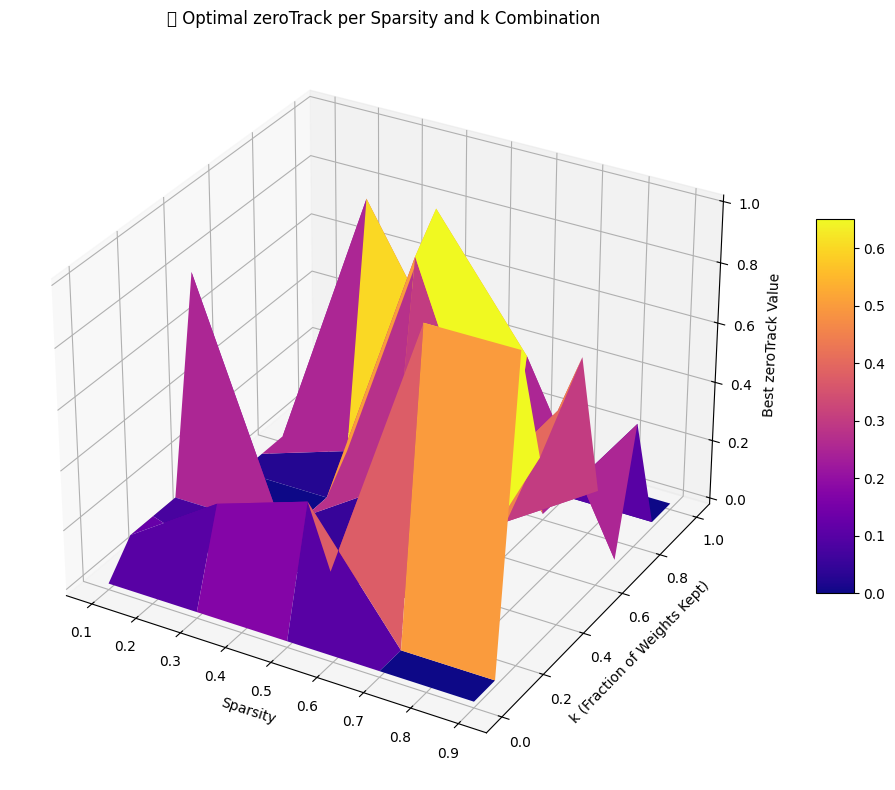

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# accuracy_surface shape: (sparsity, k, zeroTrack)
# Find the index of the best zeroTrack for each (sparsity, k) pair
best_zeroTrack_indices = np.argmax(accuracy_surface, axis=2)

# Map indices back to actual zeroTrack values
best_zeroTracks = zeroTrack_values[best_zeroTrack_indices]

# Create meshgrid for Sparsity and k
S, K = np.meshgrid(sparsity_values, k_values, indexing='ij')

# Plotting the zeroTrack that gave best accuracy
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(S, K, best_zeroTracks, cmap='plasma', edgecolor='none')

ax.set_xlabel('Sparsity')
ax.set_ylabel('k (Fraction of Weights Kept)')
ax.set_zlabel('Best zeroTrack Value')
ax.set_title('Optimal zeroTrack per Sparsity and k Combination')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()



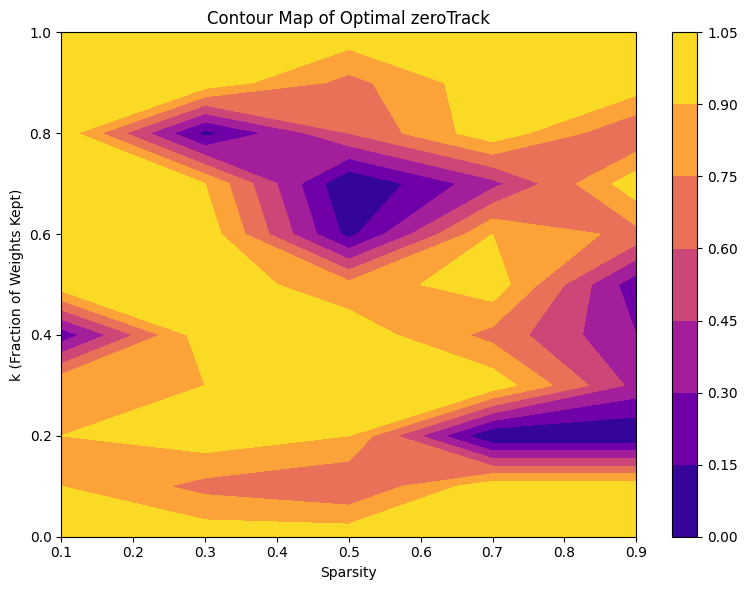

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(S, K, best_zeroTrack_map, cmap='plasma')
fig.colorbar(contour)

ax.set_xlabel('Sparsity')
ax.set_ylabel('k (Fraction of Weights Kept)')
ax.set_title('Contour Map of Optimal zeroTrack')

plt.tight_layout()
plt.show()

Now, let's try to find the optimal K value, taking into account initialization, by doing a lot of different K's and initializing new models each time.  We do multiple different runs for each K, since maybe some intializations are luckier than others.

In [ ]:
data_set_name='breastmnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)

NUM_EPOCHS = 3
metrics = []
num_runs = 3
for K in np.linspace(1.0,0,11):
    for _ in range(num_runs):
      print('------------------')
      print('K: %.3f' % (K))
      model = Network(layer_sizes=[[28*28, 256], [256, 256], [256, n_classes]], maskable=True, k=K)
      trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()), task, n_classes)
      print('==> Evaluating ...')
      test('train',model,train_loader_at_eval, test_loader,task, n_classes, data_set_name)
      this_k_metrics = test('test' ,model,train_loader_at_eval, test_loader,task, n_classes, data_set_name, return_metrics=True)
      metrics.append((K,this_k_metrics[1]))

100%|██████████| 560k/560k [00:00<00:00, 930kB/s]


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
------------------
K: 1.000


100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


==> Evaluating ...
train  auc: 0.561  acc:0.273
test  auc: 0.525  acc:0.288
------------------
K: 1.000


100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


==> Evaluating ...
train  auc: 0.409  acc:0.645
test  auc: 0.414  acc:0.660
------------------
K: 1.000


100%|██████████| 5/5 [00:00<00:00, 20.55it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.687
test  auc: 0.500  acc:0.686
------------------
K: 0.900


100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


==> Evaluating ...
train  auc: 0.457  acc:0.731
test  auc: 0.475  acc:0.731
------------------
K: 0.900


100%|██████████| 5/5 [00:00<00:00, 20.00it/s]


==> Evaluating ...
train  auc: 0.459  acc:0.731
test  auc: 0.464  acc:0.731
------------------
K: 0.900


100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


==> Evaluating ...
train  auc: 0.451  acc:0.733
test  auc: 0.425  acc:0.731
------------------
K: 0.800


100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.731
test  auc: 0.447  acc:0.731
------------------
K: 0.800


100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


==> Evaluating ...
train  auc: 0.429  acc:0.731
test  auc: 0.468  acc:0.731
------------------
K: 0.800


100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


==> Evaluating ...
train  auc: 0.445  acc:0.729
test  auc: 0.453  acc:0.718
------------------
K: 0.700


100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


==> Evaluating ...
train  auc: 0.468  acc:0.731
test  auc: 0.477  acc:0.724
------------------
K: 0.700


100%|██████████| 5/5 [00:00<00:00, 20.44it/s]


==> Evaluating ...
train  auc: 0.437  acc:0.729
test  auc: 0.490  acc:0.731
------------------
K: 0.700


100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


==> Evaluating ...
train  auc: 0.532  acc:0.690
test  auc: 0.588  acc:0.692
------------------
K: 0.600


100%|██████████| 5/5 [00:00<00:00, 20.52it/s]


==> Evaluating ...
train  auc: 0.432  acc:0.731
test  auc: 0.475  acc:0.731
------------------
K: 0.600


100%|██████████| 5/5 [00:00<00:00, 19.98it/s]


==> Evaluating ...
train  auc: 0.554  acc:0.731
test  auc: 0.522  acc:0.699
------------------
K: 0.600


100%|██████████| 5/5 [00:00<00:00, 20.02it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.731
test  auc: 0.508  acc:0.724
------------------
K: 0.500


100%|██████████| 5/5 [00:00<00:00, 20.42it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.731
test  auc: 0.496  acc:0.731
------------------
K: 0.500


100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


==> Evaluating ...
train  auc: 0.407  acc:0.731
test  auc: 0.431  acc:0.731
------------------
K: 0.500


100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


==> Evaluating ...
train  auc: 0.413  acc:0.709
test  auc: 0.463  acc:0.718
------------------
K: 0.400


100%|██████████| 5/5 [00:00<00:00, 20.47it/s]


==> Evaluating ...
train  auc: 0.452  acc:0.731
test  auc: 0.471  acc:0.737
------------------
K: 0.400


100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


==> Evaluating ...
train  auc: 0.579  acc:0.731
test  auc: 0.576  acc:0.731
------------------
K: 0.400


100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.681
test  auc: 0.469  acc:0.654
------------------
K: 0.300


100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


==> Evaluating ...
train  auc: 0.360  acc:0.731
test  auc: 0.446  acc:0.731
------------------
K: 0.300


100%|██████████| 5/5 [00:00<00:00, 19.88it/s]


==> Evaluating ...
train  auc: 0.441  acc:0.712
test  auc: 0.444  acc:0.699
------------------
K: 0.300


100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


==> Evaluating ...
train  auc: 0.390  acc:0.718
test  auc: 0.411  acc:0.731
------------------
K: 0.200


100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.734
test  auc: 0.635  acc:0.744
------------------
K: 0.200


100%|██████████| 5/5 [00:00<00:00, 20.06it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.615
test  auc: 0.496  acc:0.590
------------------
K: 0.200


100%|██████████| 5/5 [00:00<00:00, 20.25it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.723
test  auc: 0.464  acc:0.705
------------------
K: 0.100


100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.564
test  auc: 0.556  acc:0.583
------------------
K: 0.100


100%|██████████| 5/5 [00:00<00:00, 20.31it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.731
test  auc: 0.520  acc:0.737
------------------
K: 0.100


100%|██████████| 5/5 [00:00<00:00, 20.46it/s]


==> Evaluating ...
train  auc: 0.432  acc:0.716
test  auc: 0.485  acc:0.705
------------------
K: 0.000


100%|██████████| 5/5 [00:00<00:00, 20.92it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.269
test  auc: 0.500  acc:0.269
------------------
K: 0.000


100%|██████████| 5/5 [00:00<00:00, 19.99it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.269
test  auc: 0.500  acc:0.269
------------------
K: 0.000


100%|██████████| 5/5 [00:00<00:00, 20.32it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.269
test  auc: 0.500  acc:0.269


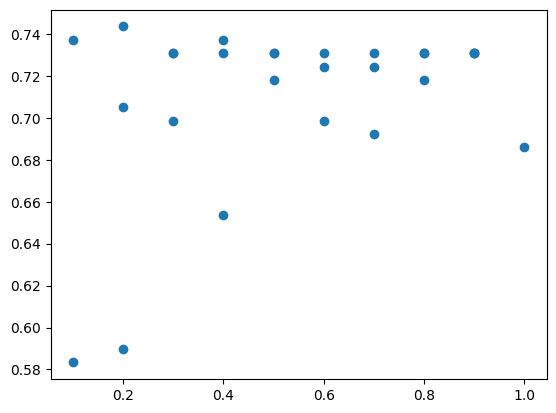

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

S, K = np.meshgrid(sparsity_values, k_values, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, K, best_zeroTrack_map, cmap='plasma', edgecolor='none')

ax.set_xlabel('Sparsity')
ax.set_ylabel('k (Fraction of Weights Kept)')
ax.set_zlabel('Best zeroTrack')
ax.set_title('Optimal zeroTrack for Each Sparsity and k')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


Now, let's vary the K's for each layer.

In [ ]:
from itertools import combinations_with_replacement
data_set_name='bloodmnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)

NUM_EPOCHS = 3
metrics = []
num_runs = 1
for K in combinations_with_replacement(np.linspace(1.0,0,11), 2):
    for _ in range(num_runs):
      print('------------------')
      print('K: '+str(K))
      model = Network(layer_sizes=[[28*28, 128], [128, n_classes]], maskable=True, k=K)
      trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()), task, n_classes)
      print('==> Evaluating ...')
      test('train',model,train_loader_at_eval, test_loader,task, n_classes, data_set_name)
      this_k_metrics = test('test' ,model,train_loader_at_eval, test_loader,task, n_classes, data_set_name, return_metrics=True)
      metrics.append((K[0],K[1],this_k_metrics[1]))

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
------------------
K: (1.0, 1.0)


100%|██████████| 94/94 [00:03<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.072
test  auc: 0.485  acc:0.078
------------------
K: (1.0, 1.0)


100%|██████████| 94/94 [00:03<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.451  acc:0.119
test  auc: 0.458  acc:0.120
------------------
K: (1.0, 1.0)


100%|██████████| 94/94 [00:03<00:00, 23.67it/s]


==> Evaluating ...
train  auc: 0.573  acc:0.160
test  auc: 0.576  acc:0.160
------------------
K: (1.0, 0.9)


100%|██████████| 94/94 [00:04<00:00, 22.94it/s]


==> Evaluating ...
train  auc: 0.613  acc:0.213
test  auc: 0.601  acc:0.212
------------------
K: (1.0, 0.9)


100%|██████████| 94/94 [00:04<00:00, 23.39it/s]


==> Evaluating ...
train  auc: 0.599  acc:0.229
test  auc: 0.595  acc:0.228
------------------
K: (1.0, 0.9)


100%|██████████| 94/94 [00:03<00:00, 23.72it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.168
test  auc: 0.543  acc:0.172
------------------
K: (1.0, 0.8)


100%|██████████| 94/94 [00:03<00:00, 23.69it/s]


==> Evaluating ...
train  auc: 0.612  acc:0.209
test  auc: 0.609  acc:0.210
------------------
K: (1.0, 0.8)


100%|██████████| 94/94 [00:03<00:00, 23.93it/s]


==> Evaluating ...
train  auc: 0.643  acc:0.253
test  auc: 0.643  acc:0.254
------------------
K: (1.0, 0.8)


100%|██████████| 94/94 [00:03<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.668  acc:0.305
test  auc: 0.663  acc:0.314
------------------
K: (1.0, 0.7)


100%|██████████| 94/94 [00:04<00:00, 23.47it/s]


==> Evaluating ...
train  auc: 0.652  acc:0.174
test  auc: 0.654  acc:0.183
------------------
K: (1.0, 0.7)


100%|██████████| 94/94 [00:03<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.605  acc:0.165
test  auc: 0.598  acc:0.169
------------------
K: (1.0, 0.7)


100%|██████████| 94/94 [00:03<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.648  acc:0.327
test  auc: 0.650  acc:0.319
------------------
K: (1.0, 0.6)


100%|██████████| 94/94 [00:04<00:00, 19.59it/s]


==> Evaluating ...
train  auc: 0.625  acc:0.191
test  auc: 0.628  acc:0.184
------------------
K: (1.0, 0.6)


100%|██████████| 94/94 [00:04<00:00, 23.22it/s]


==> Evaluating ...
train  auc: 0.678  acc:0.230
test  auc: 0.672  acc:0.231
------------------
K: (1.0, 0.6)


100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
train  auc: 0.570  acc:0.193
test  auc: 0.562  acc:0.191
------------------
K: (1.0, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.89it/s]


==> Evaluating ...
train  auc: 0.622  acc:0.234
test  auc: 0.627  acc:0.233
------------------
K: (1.0, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.596  acc:0.176
test  auc: 0.597  acc:0.175
------------------
K: (1.0, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.267
test  auc: 0.551  acc:0.267
------------------
K: (1.0, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.610  acc:0.195
test  auc: 0.613  acc:0.200
------------------
K: (1.0, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.697  acc:0.312
test  auc: 0.695  acc:0.312
------------------
K: (1.0, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 22.75it/s]


==> Evaluating ...
train  auc: 0.596  acc:0.165
test  auc: 0.598  acc:0.172
------------------
K: (1.0, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.39it/s]


==> Evaluating ...
train  auc: 0.655  acc:0.241
test  auc: 0.661  acc:0.247
------------------
K: (1.0, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.42it/s]


==> Evaluating ...
train  auc: 0.568  acc:0.165
test  auc: 0.562  acc:0.169
------------------
K: (1.0, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.08it/s]


==> Evaluating ...
train  auc: 0.609  acc:0.335
test  auc: 0.603  acc:0.335
------------------
K: (1.0, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.65it/s]


==> Evaluating ...
train  auc: 0.670  acc:0.330
test  auc: 0.663  acc:0.329
------------------
K: (1.0, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.654  acc:0.206
test  auc: 0.652  acc:0.209
------------------
K: (1.0, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.651  acc:0.243
test  auc: 0.647  acc:0.242
------------------
K: (1.0, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.541  acc:0.200
test  auc: 0.536  acc:0.189
------------------
K: (1.0, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.632  acc:0.201
test  auc: 0.624  acc:0.188
------------------
K: (1.0, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.77it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.089
test  auc: 0.483  acc:0.084
------------------
K: (1.0, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.11it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (1.0, 0.0)


100%|██████████| 94/94 [00:04<00:00, 22.58it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (1.0, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.04it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.9, 0.9)


100%|██████████| 94/94 [00:03<00:00, 23.62it/s]


==> Evaluating ...
train  auc: 0.868  acc:0.485
test  auc: 0.869  acc:0.491
------------------
K: (0.9, 0.9)


100%|██████████| 94/94 [00:03<00:00, 23.84it/s]


==> Evaluating ...
train  auc: 0.869  acc:0.487
test  auc: 0.869  acc:0.485
------------------
K: (0.9, 0.9)


100%|██████████| 94/94 [00:03<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.869  acc:0.494
test  auc: 0.869  acc:0.498
------------------
K: (0.9, 0.8)


100%|██████████| 94/94 [00:03<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.869  acc:0.502
test  auc: 0.864  acc:0.491
------------------
K: (0.9, 0.8)


100%|██████████| 94/94 [00:03<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.866  acc:0.487
test  auc: 0.860  acc:0.479
------------------
K: (0.9, 0.8)


100%|██████████| 94/94 [00:03<00:00, 23.87it/s]


==> Evaluating ...
train  auc: 0.850  acc:0.482
test  auc: 0.843  acc:0.484
------------------
K: (0.9, 0.7)


100%|██████████| 94/94 [00:04<00:00, 23.41it/s]


==> Evaluating ...
train  auc: 0.872  acc:0.503
test  auc: 0.867  acc:0.501
------------------
K: (0.9, 0.7)


100%|██████████| 94/94 [00:04<00:00, 22.89it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.497
test  auc: 0.873  acc:0.493
------------------
K: (0.9, 0.7)


100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
train  auc: 0.871  acc:0.492
test  auc: 0.871  acc:0.494
------------------
K: (0.9, 0.6)


100%|██████████| 94/94 [00:04<00:00, 23.38it/s]


==> Evaluating ...
train  auc: 0.872  acc:0.505
test  auc: 0.872  acc:0.501
------------------
K: (0.9, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.73it/s]


==> Evaluating ...
train  auc: 0.863  acc:0.470
test  auc: 0.860  acc:0.465
------------------
K: (0.9, 0.6)


100%|██████████| 94/94 [00:03<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.490
test  auc: 0.873  acc:0.490
------------------
K: (0.9, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.851  acc:0.485
test  auc: 0.849  acc:0.478
------------------
K: (0.9, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.12it/s]


==> Evaluating ...
train  auc: 0.856  acc:0.511
test  auc: 0.856  acc:0.507
------------------
K: (0.9, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.67it/s]


==> Evaluating ...
train  auc: 0.875  acc:0.466
test  auc: 0.875  acc:0.467
------------------
K: (0.9, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 23.00it/s]


==> Evaluating ...
train  auc: 0.856  acc:0.476
test  auc: 0.854  acc:0.473
------------------
K: (0.9, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 23.17it/s]


==> Evaluating ...
train  auc: 0.861  acc:0.460
test  auc: 0.863  acc:0.458
------------------
K: (0.9, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 22.96it/s]


==> Evaluating ...
train  auc: 0.861  acc:0.446
test  auc: 0.862  acc:0.447
------------------
K: (0.9, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.11it/s]


==> Evaluating ...
train  auc: 0.855  acc:0.473
test  auc: 0.854  acc:0.466
------------------
K: (0.9, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.27it/s]


==> Evaluating ...
train  auc: 0.873  acc:0.480
test  auc: 0.872  acc:0.480
------------------
K: (0.9, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.48it/s]


==> Evaluating ...
train  auc: 0.851  acc:0.501
test  auc: 0.849  acc:0.505
------------------
K: (0.9, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.855  acc:0.475
test  auc: 0.857  acc:0.481
------------------
K: (0.9, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.864  acc:0.486
test  auc: 0.864  acc:0.482
------------------
K: (0.9, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.842  acc:0.447
test  auc: 0.843  acc:0.448
------------------
K: (0.9, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.97it/s]


==> Evaluating ...
train  auc: 0.849  acc:0.436
test  auc: 0.853  acc:0.440
------------------
K: (0.9, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.94it/s]


==> Evaluating ...
train  auc: 0.838  acc:0.463
test  auc: 0.836  acc:0.458
------------------
K: (0.9, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.98it/s]


==> Evaluating ...
train  auc: 0.824  acc:0.461
test  auc: 0.821  acc:0.456
------------------
K: (0.9, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.32it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.9, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.58it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.9, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.8, 0.8)


100%|██████████| 94/94 [00:03<00:00, 24.10it/s]


==> Evaluating ...
train  auc: 0.886  acc:0.517
test  auc: 0.882  acc:0.514
------------------
K: (0.8, 0.8)


100%|██████████| 94/94 [00:03<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.880  acc:0.480
test  auc: 0.879  acc:0.481
------------------
K: (0.8, 0.8)


100%|██████████| 94/94 [00:03<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.868  acc:0.516
test  auc: 0.865  acc:0.519
------------------
K: (0.8, 0.7)


100%|██████████| 94/94 [00:04<00:00, 23.38it/s]


==> Evaluating ...
train  auc: 0.882  acc:0.522
test  auc: 0.880  acc:0.521
------------------
K: (0.8, 0.7)


100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.505
test  auc: 0.877  acc:0.488
------------------
K: (0.8, 0.7)


100%|██████████| 94/94 [00:04<00:00, 22.49it/s]


==> Evaluating ...
train  auc: 0.884  acc:0.530
test  auc: 0.880  acc:0.526
------------------
K: (0.8, 0.6)


100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


==> Evaluating ...
train  auc: 0.890  acc:0.506
test  auc: 0.889  acc:0.509
------------------
K: (0.8, 0.6)


100%|██████████| 94/94 [00:04<00:00, 22.80it/s]


==> Evaluating ...
train  auc: 0.883  acc:0.524
test  auc: 0.884  acc:0.522
------------------
K: (0.8, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.59it/s]


==> Evaluating ...
train  auc: 0.886  acc:0.518
test  auc: 0.886  acc:0.521
------------------
K: (0.8, 0.5)


100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
train  auc: 0.876  acc:0.505
test  auc: 0.876  acc:0.507
------------------
K: (0.8, 0.5)


100%|██████████| 94/94 [00:04<00:00, 22.89it/s]


==> Evaluating ...
train  auc: 0.880  acc:0.508
test  auc: 0.880  acc:0.513
------------------
K: (0.8, 0.5)


100%|██████████| 94/94 [00:04<00:00, 22.98it/s]


==> Evaluating ...
train  auc: 0.881  acc:0.528
test  auc: 0.880  acc:0.531
------------------
K: (0.8, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 23.45it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.528
test  auc: 0.878  acc:0.529
------------------
K: (0.8, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 23.37it/s]


==> Evaluating ...
train  auc: 0.876  acc:0.501
test  auc: 0.875  acc:0.500
------------------
K: (0.8, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 23.56it/s]


==> Evaluating ...
train  auc: 0.892  acc:0.489
test  auc: 0.887  acc:0.489
------------------
K: (0.8, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.58it/s]


==> Evaluating ...
train  auc: 0.877  acc:0.495
test  auc: 0.877  acc:0.497
------------------
K: (0.8, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.518
test  auc: 0.872  acc:0.519
------------------
K: (0.8, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.40it/s]


==> Evaluating ...
train  auc: 0.864  acc:0.528
test  auc: 0.865  acc:0.530
------------------
K: (0.8, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.854  acc:0.504
test  auc: 0.855  acc:0.512
------------------
K: (0.8, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.476
test  auc: 0.875  acc:0.475
------------------
K: (0.8, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.492
test  auc: 0.873  acc:0.502
------------------
K: (0.8, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.71it/s]


==> Evaluating ...
train  auc: 0.847  acc:0.481
test  auc: 0.847  acc:0.481
------------------
K: (0.8, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.53it/s]


==> Evaluating ...
train  auc: 0.837  acc:0.470
test  auc: 0.834  acc:0.479
------------------
K: (0.8, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.80it/s]


==> Evaluating ...
train  auc: 0.849  acc:0.494
test  auc: 0.846  acc:0.500
------------------
K: (0.8, 0.0)


100%|██████████| 94/94 [00:04<00:00, 22.66it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.8, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.8, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.90it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.7, 0.7)


100%|██████████| 94/94 [00:03<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.891  acc:0.550
test  auc: 0.891  acc:0.553
------------------
K: (0.7, 0.7)


100%|██████████| 94/94 [00:04<00:00, 22.90it/s]


==> Evaluating ...
train  auc: 0.891  acc:0.532
test  auc: 0.890  acc:0.528
------------------
K: (0.7, 0.7)


100%|██████████| 94/94 [00:03<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.883  acc:0.520
test  auc: 0.879  acc:0.515
------------------
K: (0.7, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.56it/s]


==> Evaluating ...
train  auc: 0.887  acc:0.532
test  auc: 0.886  acc:0.529
------------------
K: (0.7, 0.6)


100%|██████████| 94/94 [00:04<00:00, 23.19it/s]


==> Evaluating ...
train  auc: 0.877  acc:0.516
test  auc: 0.880  acc:0.515
------------------
K: (0.7, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.51it/s]


==> Evaluating ...
train  auc: 0.884  acc:0.520
test  auc: 0.884  acc:0.524
------------------
K: (0.7, 0.5)


100%|██████████| 94/94 [00:04<00:00, 23.14it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.520
test  auc: 0.878  acc:0.527
------------------
K: (0.7, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.71it/s]


==> Evaluating ...
train  auc: 0.883  acc:0.545
test  auc: 0.881  acc:0.543
------------------
K: (0.7, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.882  acc:0.504
test  auc: 0.881  acc:0.505
------------------
K: (0.7, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.880  acc:0.527
test  auc: 0.876  acc:0.524
------------------
K: (0.7, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.871  acc:0.512
test  auc: 0.871  acc:0.509
------------------
K: (0.7, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.883  acc:0.531
test  auc: 0.882  acc:0.527
------------------
K: (0.7, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.91it/s]


==> Evaluating ...
train  auc: 0.883  acc:0.528
test  auc: 0.879  acc:0.529
------------------
K: (0.7, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.39it/s]


==> Evaluating ...
train  auc: 0.876  acc:0.514
test  auc: 0.875  acc:0.513
------------------
K: (0.7, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 22.76it/s]


==> Evaluating ...
train  auc: 0.873  acc:0.523
test  auc: 0.874  acc:0.516
------------------
K: (0.7, 0.19999999999999996)


100%|██████████| 94/94 [00:04<00:00, 23.14it/s]


==> Evaluating ...
train  auc: 0.877  acc:0.543
test  auc: 0.877  acc:0.548
------------------
K: (0.7, 0.19999999999999996)


100%|██████████| 94/94 [00:04<00:00, 23.42it/s]


==> Evaluating ...
train  auc: 0.876  acc:0.538
test  auc: 0.874  acc:0.538
------------------
K: (0.7, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.55it/s]


==> Evaluating ...
train  auc: 0.873  acc:0.530
test  auc: 0.872  acc:0.526
------------------
K: (0.7, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.78it/s]


==> Evaluating ...
train  auc: 0.849  acc:0.479
test  auc: 0.853  acc:0.486
------------------
K: (0.7, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.80it/s]


==> Evaluating ...
train  auc: 0.846  acc:0.471
test  auc: 0.840  acc:0.471
------------------
K: (0.7, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.75it/s]


==> Evaluating ...
train  auc: 0.854  acc:0.482
test  auc: 0.854  acc:0.479
------------------
K: (0.7, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.07it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.7, 0.0)


100%|██████████| 94/94 [00:04<00:00, 21.75it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.7, 0.0)


100%|██████████| 94/94 [00:04<00:00, 22.65it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.6, 0.6)


100%|██████████| 94/94 [00:04<00:00, 22.94it/s]


==> Evaluating ...
train  auc: 0.879  acc:0.524
test  auc: 0.880  acc:0.528
------------------
K: (0.6, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.53it/s]


==> Evaluating ...
train  auc: 0.891  acc:0.556
test  auc: 0.890  acc:0.557
------------------
K: (0.6, 0.6)


100%|██████████| 94/94 [00:03<00:00, 23.93it/s]


==> Evaluating ...
train  auc: 0.877  acc:0.533
test  auc: 0.875  acc:0.540
------------------
K: (0.6, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.92it/s]


==> Evaluating ...
train  auc: 0.887  acc:0.566
test  auc: 0.886  acc:0.568
------------------
K: (0.6, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.79it/s]


==> Evaluating ...
train  auc: 0.882  acc:0.539
test  auc: 0.882  acc:0.538
------------------
K: (0.6, 0.5)


100%|██████████| 94/94 [00:03<00:00, 23.64it/s]


==> Evaluating ...
train  auc: 0.880  acc:0.493
test  auc: 0.879  acc:0.496
------------------
K: (0.6, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 23.67it/s]


==> Evaluating ...
train  auc: 0.871  acc:0.527
test  auc: 0.868  acc:0.531
------------------
K: (0.6, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 22.78it/s]


==> Evaluating ...
train  auc: 0.870  acc:0.509
test  auc: 0.867  acc:0.514
------------------
K: (0.6, 0.3999999999999999)


100%|██████████| 94/94 [00:04<00:00, 23.05it/s]


==> Evaluating ...
train  auc: 0.881  acc:0.513
test  auc: 0.877  acc:0.506
------------------
K: (0.6, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 22.49it/s]


==> Evaluating ...
train  auc: 0.870  acc:0.531
test  auc: 0.873  acc:0.526
------------------
K: (0.6, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.29it/s]


==> Evaluating ...
train  auc: 0.891  acc:0.553
test  auc: 0.888  acc:0.552
------------------
K: (0.6, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.882  acc:0.517
test  auc: 0.880  acc:0.522
------------------
K: (0.6, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.496
test  auc: 0.876  acc:0.503
------------------
K: (0.6, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.492
test  auc: 0.873  acc:0.495
------------------
K: (0.6, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.867  acc:0.515
test  auc: 0.868  acc:0.513
------------------
K: (0.6, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.62it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.483
test  auc: 0.871  acc:0.488
------------------
K: (0.6, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.02it/s]


==> Evaluating ...
train  auc: 0.830  acc:0.459
test  auc: 0.827  acc:0.457
------------------
K: (0.6, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.23it/s]


==> Evaluating ...
train  auc: 0.855  acc:0.471
test  auc: 0.852  acc:0.469
------------------
K: (0.6, 0.0)


100%|██████████| 94/94 [00:04<00:00, 22.71it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.6, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.6, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.5, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.879  acc:0.518
test  auc: 0.877  acc:0.521
------------------
K: (0.5, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.879  acc:0.533
test  auc: 0.877  acc:0.538
------------------
K: (0.5, 0.5)


100%|██████████| 94/94 [00:03<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.886  acc:0.547
test  auc: 0.886  acc:0.550
------------------
K: (0.5, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.881  acc:0.527
test  auc: 0.880  acc:0.536
------------------
K: (0.5, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 23.50it/s]


==> Evaluating ...
train  auc: 0.882  acc:0.536
test  auc: 0.884  acc:0.543
------------------
K: (0.5, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 23.73it/s]


==> Evaluating ...
train  auc: 0.890  acc:0.510
test  auc: 0.887  acc:0.509
------------------
K: (0.5, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.888  acc:0.536
test  auc: 0.885  acc:0.532
------------------
K: (0.5, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.866  acc:0.530
test  auc: 0.866  acc:0.537
------------------
K: (0.5, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.93it/s]


==> Evaluating ...
train  auc: 0.878  acc:0.496
test  auc: 0.878  acc:0.498
------------------
K: (0.5, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.860  acc:0.529
test  auc: 0.863  acc:0.537
------------------
K: (0.5, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.886  acc:0.538
test  auc: 0.885  acc:0.542
------------------
K: (0.5, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.875  acc:0.513
test  auc: 0.876  acc:0.524
------------------
K: (0.5, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.64it/s]


==> Evaluating ...
train  auc: 0.864  acc:0.437
test  auc: 0.862  acc:0.437
------------------
K: (0.5, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.34it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.514
test  auc: 0.873  acc:0.520
------------------
K: (0.5, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.41it/s]


==> Evaluating ...
train  auc: 0.851  acc:0.433
test  auc: 0.852  acc:0.436
------------------
K: (0.5, 0.0)


100%|██████████| 94/94 [00:04<00:00, 23.48it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.5, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.5, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.3999999999999999, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.880  acc:0.510
test  auc: 0.880  acc:0.521
------------------
K: (0.3999999999999999, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.92it/s]


==> Evaluating ...
train  auc: 0.867  acc:0.528
test  auc: 0.866  acc:0.533
------------------
K: (0.3999999999999999, 0.3999999999999999)


100%|██████████| 94/94 [00:03<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.893  acc:0.503
test  auc: 0.886  acc:0.507
------------------
K: (0.3999999999999999, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
train  auc: 0.873  acc:0.520
test  auc: 0.873  acc:0.524
------------------
K: (0.3999999999999999, 0.29999999999999993)


100%|██████████| 94/94 [00:04<00:00, 23.06it/s]


==> Evaluating ...
train  auc: 0.874  acc:0.492
test  auc: 0.874  acc:0.503
------------------
K: (0.3999999999999999, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.69it/s]


==> Evaluating ...
train  auc: 0.877  acc:0.498
test  auc: 0.876  acc:0.500
------------------
K: (0.3999999999999999, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.875  acc:0.526
test  auc: 0.875  acc:0.518
------------------
K: (0.3999999999999999, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.868  acc:0.471
test  auc: 0.865  acc:0.478
------------------
K: (0.3999999999999999, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.71it/s]


==> Evaluating ...
train  auc: 0.876  acc:0.508
test  auc: 0.873  acc:0.505
------------------
K: (0.3999999999999999, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.866  acc:0.451
test  auc: 0.867  acc:0.459
------------------
K: (0.3999999999999999, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.865  acc:0.515
test  auc: 0.867  acc:0.515
------------------
K: (0.3999999999999999, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.81it/s]


==> Evaluating ...
train  auc: 0.843  acc:0.533
test  auc: 0.843  acc:0.533
------------------
K: (0.3999999999999999, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.61it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.3999999999999999, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.3999999999999999, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.54it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.29999999999999993, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 23.96it/s]


==> Evaluating ...
train  auc: 0.872  acc:0.538
test  auc: 0.870  acc:0.539
------------------
K: (0.29999999999999993, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.885  acc:0.507
test  auc: 0.884  acc:0.508
------------------
K: (0.29999999999999993, 0.29999999999999993)


100%|██████████| 94/94 [00:03<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.871  acc:0.517
test  auc: 0.874  acc:0.524
------------------
K: (0.29999999999999993, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.839  acc:0.503
test  auc: 0.835  acc:0.500
------------------
K: (0.29999999999999993, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.879  acc:0.501
test  auc: 0.878  acc:0.501
------------------
K: (0.29999999999999993, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 23.64it/s]


==> Evaluating ...
train  auc: 0.863  acc:0.438
test  auc: 0.858  acc:0.438
------------------
K: (0.29999999999999993, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.79it/s]


==> Evaluating ...
train  auc: 0.838  acc:0.475
test  auc: 0.828  acc:0.465
------------------
K: (0.29999999999999993, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.47it/s]


==> Evaluating ...
train  auc: 0.845  acc:0.479
test  auc: 0.841  acc:0.478
------------------
K: (0.29999999999999993, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.846  acc:0.454
test  auc: 0.847  acc:0.458
------------------
K: (0.29999999999999993, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.29999999999999993, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.60it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.29999999999999993, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.19999999999999996, 0.19999999999999996)


100%|██████████| 94/94 [00:03<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.863  acc:0.475
test  auc: 0.861  acc:0.477
------------------
K: (0.19999999999999996, 0.19999999999999996)


100%|██████████| 94/94 [00:04<00:00, 23.37it/s]


==> Evaluating ...
train  auc: 0.863  acc:0.475
test  auc: 0.860  acc:0.484
------------------
K: (0.19999999999999996, 0.19999999999999996)


100%|██████████| 94/94 [00:04<00:00, 23.37it/s]


==> Evaluating ...
train  auc: 0.879  acc:0.489
test  auc: 0.876  acc:0.484
------------------
K: (0.19999999999999996, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.10it/s]


==> Evaluating ...
train  auc: 0.852  acc:0.443
test  auc: 0.851  acc:0.441
------------------
K: (0.19999999999999996, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.859  acc:0.440
test  auc: 0.858  acc:0.437
------------------
K: (0.19999999999999996, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 22.85it/s]


==> Evaluating ...
train  auc: 0.849  acc:0.475
test  auc: 0.850  acc:0.493
------------------
K: (0.19999999999999996, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.82it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.19999999999999996, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.19999999999999996, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.09999999999999998, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.824  acc:0.402
test  auc: 0.823  acc:0.396
------------------
K: (0.09999999999999998, 0.09999999999999998)


100%|██████████| 94/94 [00:03<00:00, 23.83it/s]


==> Evaluating ...
train  auc: 0.844  acc:0.491
test  auc: 0.846  acc:0.493
------------------
K: (0.09999999999999998, 0.09999999999999998)


100%|██████████| 94/94 [00:04<00:00, 23.41it/s]


==> Evaluating ...
train  auc: 0.845  acc:0.441
test  auc: 0.841  acc:0.435
------------------
K: (0.09999999999999998, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.09999999999999998, 0.0)


100%|██████████| 94/94 [00:03<00:00, 23.75it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.09999999999999998, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.0, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.0, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071
------------------
K: (0.0, 0.0)


100%|██████████| 94/94 [00:03<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.071
test  auc: 0.500  acc:0.071


ValueError: not enough values to unpack (expected at least 1, got 0)

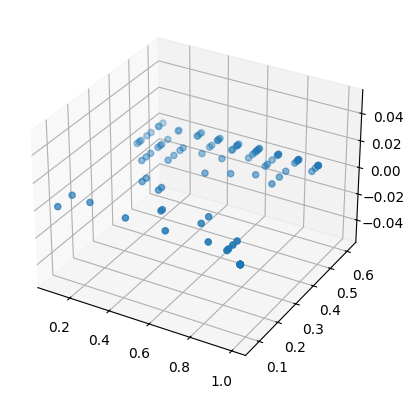

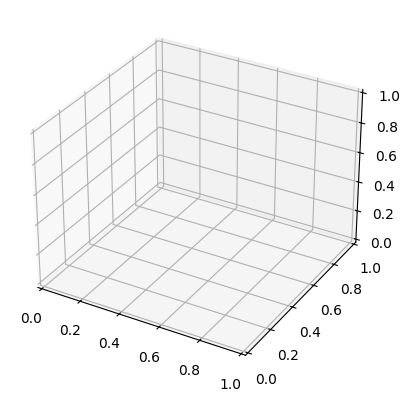

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*zip(*[z for z in metrics if all(zi>0 for zi in z)]))

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.plot_trisurf(*zip(*metrics))

# The jupyter backends call ``show()`` at the end of every cell by default.
# Thus, you usually don't have to call it explicitly there.
# plt.show()

In this example, we show that it is possible to use a single model with frozen weights and find pretty good subnetworks for lots of different tasks.

In [ ]:
model = Network(layer_sizes=[[28*28, 256], [256,256], [256, 11]], maskable=True, k=[0.4,0.4,0.4])
NUM_EPOCHS = 3
train_scores=[]
data_sets_to_test=['pathmnist','dermamnist','octmnist','pneumoniamnist','breastmnist','bloodmnist','tissuemnist','organamnist','organcmnist','organsmnist']
for data_set_name in data_sets_to_test:
    info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
    print('Testing Dataset: '+data_set_name)
    losses_for_this_dataset=trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()), task, n_classes, return_losses=True)
    train_score.append(losses_for_this_dataset)
    print('==> Evaluating ...')
    test('train', model, train_loader_at_eval, test_loader, task, n_classes, data_set_name)
    test('test' , model, train_loader_at_eval, test_loader, task, n_classes, data_set_name)
    # for layer in model.linear_relu_stack[::2]:
    #     layer.popup_scores = layer.initial_popup_scores
    print('------------------')


100%|██████████| 206M/206M [00:11<00:00, 17.2MB/s]


RuntimeError: 
                Automatic download failed! Please download pathmnist.npz manually.
                1. [Optional] Check your network connection: 
                    Go to https://github.com/MedMNIST/MedMNIST/ and find the Zenodo repository
                2. Download the npz file from the Zenodo repository or its Zenodo data link: 
                    https://zenodo.org/records/10519652/files/pathmnist.npz?download=1
                3. [Optional] Verify the MD5: 
                    a8b06965200029087d5bd730944a56c1
                4. Put the npz file under your MedMNIST root folder: 
                    /root/.medmnist
                

In [ ]:
# Plot the results of the previous cell
for i in range(len(data_sets_to_test)):
  plt.plot(np.linspace(0,max(len(train_score[j]) for j in range(len(train_score))),len(train_score[i])),train_score[i], label=data_sets_to_test[i])
plt.legend()
ax = plt.gca()
ax.set_ylim([1,2.5])
ax.get_xaxis().set_visible(False)
# The jupyter backends call ``show()`` at the end of every cell by default.
# Thus, you usually don't have to call it explicitly there.
# plt.show

Here, we show that different initializations dramatically change things.

In [ ]:
data_set_name='dermamnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)

NUM_EPOCHS = 3
num_runs = 10

metrics_by_run = {}
for distrib in [nn.init.ones_,nn.init.zeros_,nn.init.uniform_,signed_kaiming_constant_,nn.init.dirac_,nn.init.orthogonal_,nn.init.sparse_]:
  metrics = []
  for K in np.linspace(1.0,0,11):
      for _ in range(num_runs):
        print('------------------')
        print('K: %.3f' % (K))
        model = Network(layer_sizes=[[28*28, 128], [128, n_classes]], maskable=True, k=K, init=nn.init.ones_)
        trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()), task, n_classes)
        print('==> Evaluating ...')
        test('train',model,train_loader_at_eval, test_loader,task, n_classes, data_set_name)
        this_k_metrics = test('test' ,model,train_loader_at_eval, test_loader,task, n_classes, data_set_name, return_metrics=True)
        metrics.append((K,this_k_metrics[1]))
  metrics_by_run[distrib.__name__]=metrics

100%|██████████| 19.7M/19.7M [00:02<00:00, 7.12MB/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.60it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.84it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.71it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.569
test  auc: 0.514  acc:0.569
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.484  acc:0.603
test  auc: 0.492  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.83it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.205
test  auc: 0.503  acc:0.207
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.73it/s]


==> Evaluating ...
train  auc: 0.458  acc:0.606
test  auc: 0.460  acc:0.608
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.607
test  auc: 0.466  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.84it/s]


==> Evaluating ...
train  auc: 0.471  acc:0.115
test  auc: 0.450  acc:0.115
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.73it/s]


==> Evaluating ...
train  auc: 0.463  acc:0.598
test  auc: 0.468  acc:0.603
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.86it/s]


==> Evaluating ...
train  auc: 0.465  acc:0.591
test  auc: 0.471  acc:0.587
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.598
test  auc: 0.533  acc:0.602
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.152
test  auc: 0.488  acc:0.161
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.75it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.605
test  auc: 0.475  acc:0.610
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.475  acc:0.606
test  auc: 0.474  acc:0.612
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.88it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.542
test  auc: 0.544  acc:0.536
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.594
test  auc: 0.526  acc:0.591
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.488  acc:0.607
test  auc: 0.487  acc:0.612
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.65it/s]


==> Evaluating ...
train  auc: 0.498  acc:0.093
test  auc: 0.483  acc:0.091
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.523  acc:0.570
test  auc: 0.517  acc:0.560
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.71it/s]


==> Evaluating ...
train  auc: 0.553  acc:0.586
test  auc: 0.554  acc:0.587
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.543  acc:0.194
test  auc: 0.541  acc:0.200
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.469  acc:0.602
test  auc: 0.465  acc:0.602
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.360
test  auc: 0.515  acc:0.361
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.575
test  auc: 0.526  acc:0.561
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.77it/s]


==> Evaluating ...
train  auc: 0.547  acc:0.199
test  auc: 0.534  acc:0.204
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.86it/s]


==> Evaluating ...
train  auc: 0.511  acc:0.599
test  auc: 0.517  acc:0.604
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.604
test  auc: 0.502  acc:0.606
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.604
test  auc: 0.487  acc:0.608
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.87it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.603
test  auc: 0.501  acc:0.605
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.590  acc:0.510
test  auc: 0.587  acc:0.511
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.605
test  auc: 0.474  acc:0.606
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.608
test  auc: 0.467  acc:0.608
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.466  acc:0.608
test  auc: 0.462  acc:0.612
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.483  acc:0.574
test  auc: 0.481  acc:0.574
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.530
test  auc: 0.563  acc:0.537
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.66it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.114
test  auc: 0.490  acc:0.118
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.67it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.239
test  auc: 0.517  acc:0.242
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.10it/s]


==> Evaluating ...
train  auc: 0.546  acc:0.583
test  auc: 0.550  acc:0.581
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.493
test  auc: 0.570  acc:0.501
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.60it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.122
test  auc: 0.488  acc:0.122
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.101
test  auc: 0.545  acc:0.103
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.511  acc:0.585
test  auc: 0.508  acc:0.584
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.553
test  auc: 0.518  acc:0.559
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.241
test  auc: 0.513  acc:0.248
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.81it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.604
test  auc: 0.479  acc:0.608
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.566
test  auc: 0.528  acc:0.562
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.60it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.609
test  auc: 0.491  acc:0.611
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.81it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.600
test  auc: 0.523  acc:0.605
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.109
test  auc: 0.514  acc:0.109
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.605
test  auc: 0.478  acc:0.605
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.73it/s]


==> Evaluating ...
train  auc: 0.563  acc:0.536
test  auc: 0.568  acc:0.537
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.208
test  auc: 0.485  acc:0.212
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.476  acc:0.143
test  auc: 0.472  acc:0.145
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.543  acc:0.594
test  auc: 0.534  acc:0.593
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.547  acc:0.547
test  auc: 0.556  acc:0.549
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.523
test  auc: 0.537  acc:0.531
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.541  acc:0.129
test  auc: 0.542  acc:0.135
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.98it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.547
test  auc: 0.524  acc:0.553
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.517
test  auc: 0.530  acc:0.525
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.602
test  auc: 0.489  acc:0.604
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.68it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.570
test  auc: 0.488  acc:0.567
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.494  acc:0.491
test  auc: 0.474  acc:0.470
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.510  acc:0.512
test  auc: 0.518  acc:0.522
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.515
test  auc: 0.526  acc:0.501
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.447
test  auc: 0.550  acc:0.456
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


==> Evaluating ...
train  auc: 0.603  acc:0.537
test  auc: 0.602  acc:0.522
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.497  acc:0.235
test  auc: 0.497  acc:0.237
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.542  acc:0.591
test  auc: 0.538  acc:0.588
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.157
test  auc: 0.526  acc:0.167
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.556
test  auc: 0.523  acc:0.550
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.65it/s]


==> Evaluating ...
train  auc: 0.551  acc:0.521
test  auc: 0.519  acc:0.516
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.84it/s]


==> Evaluating ...
train  auc: 0.551  acc:0.404
test  auc: 0.546  acc:0.399
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.79it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.586
test  auc: 0.475  acc:0.585
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.461  acc:0.607
test  auc: 0.458  acc:0.608
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.12it/s]


==> Evaluating ...
train  auc: 0.562  acc:0.534
test  auc: 0.562  acc:0.537
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.560
test  auc: 0.531  acc:0.560
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.571
test  auc: 0.516  acc:0.569
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.534  acc:0.541
test  auc: 0.536  acc:0.549
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.561  acc:0.149
test  auc: 0.579  acc:0.161
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.537  acc:0.533
test  auc: 0.539  acc:0.531
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.532  acc:0.065
test  auc: 0.532  acc:0.064
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.462  acc:0.128
test  auc: 0.448  acc:0.126
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.539
test  auc: 0.553  acc:0.545
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.81it/s]


==> Evaluating ...
train  auc: 0.567  acc:0.294
test  auc: 0.560  acc:0.295
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.67it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.512
test  auc: 0.462  acc:0.512
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.30it/s]


==> Evaluating ...
train  auc: 0.473  acc:0.599
test  auc: 0.457  acc:0.600
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.604
test  auc: 0.465  acc:0.610
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.490
test  auc: 0.572  acc:0.470
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.498
test  auc: 0.509  acc:0.494
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.490  acc:0.531
test  auc: 0.484  acc:0.536
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.161
test  auc: 0.522  acc:0.172
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.508  acc:0.127
test  auc: 0.491  acc:0.130
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.81it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.97it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.532  acc:0.563
test  auc: 0.529  acc:0.559
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.441  acc:0.124
test  auc: 0.431  acc:0.119
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.606
test  auc: 0.503  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.553
test  auc: 0.524  acc:0.550
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.75it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.537
test  auc: 0.484  acc:0.535
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.069
test  auc: 0.462  acc:0.062
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.80it/s]


==> Evaluating ...
train  auc: 0.574  acc:0.496
test  auc: 0.567  acc:0.489
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.79it/s]


==> Evaluating ...
train  auc: 0.464  acc:0.608
test  auc: 0.468  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.608
test  auc: 0.474  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.485  acc:0.364
test  auc: 0.481  acc:0.372
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.536  acc:0.125
test  auc: 0.527  acc:0.124
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.70it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.526
test  auc: 0.543  acc:0.529
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.143
test  auc: 0.519  acc:0.155
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.605
test  auc: 0.480  acc:0.611
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.536  acc:0.276
test  auc: 0.527  acc:0.274
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.109
test  auc: 0.471  acc:0.111
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.569  acc:0.326
test  auc: 0.572  acc:0.330
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.124
test  auc: 0.547  acc:0.134
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.478  acc:0.607
test  auc: 0.479  acc:0.614
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.599
test  auc: 0.515  acc:0.601
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.66it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.606
test  auc: 0.476  acc:0.614
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.74it/s]


==> Evaluating ...
train  auc: 0.508  acc:0.606
test  auc: 0.515  acc:0.614
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.247
test  auc: 0.568  acc:0.255
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.66it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.594
test  auc: 0.500  acc:0.595
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.86it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.606
test  auc: 0.510  acc:0.611
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.568  acc:0.599
test  auc: 0.566  acc:0.603
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.89it/s]


==> Evaluating ...
train  auc: 0.611  acc:0.560
test  auc: 0.611  acc:0.553
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.12it/s]


==> Evaluating ...
train  auc: 0.523  acc:0.497
test  auc: 0.512  acc:0.502
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.581
test  auc: 0.519  acc:0.584
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.115
test  auc: 0.499  acc:0.114
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.357
test  auc: 0.525  acc:0.352
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.485  acc:0.607
test  auc: 0.483  acc:0.609
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.604
test  auc: 0.516  acc:0.610
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.605
test  auc: 0.494  acc:0.612
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.604
test  auc: 0.492  acc:0.610
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.554
test  auc: 0.537  acc:0.557
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.608
test  auc: 0.479  acc:0.612
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.533  acc:0.524
test  auc: 0.530  acc:0.520
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.603
test  auc: 0.536  acc:0.601
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.577  acc:0.428
test  auc: 0.575  acc:0.433
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.602
test  auc: 0.482  acc:0.604
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.598
test  auc: 0.527  acc:0.599
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.08it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.197
test  auc: 0.518  acc:0.210
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.561  acc:0.477
test  auc: 0.563  acc:0.484
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.584
test  auc: 0.490  acc:0.585
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.510  acc:0.308
test  auc: 0.500  acc:0.298
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.598
test  auc: 0.546  acc:0.600
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.76it/s]


==> Evaluating ...
train  auc: 0.547  acc:0.117
test  auc: 0.538  acc:0.120
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.80it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.098
test  auc: 0.491  acc:0.101
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.604
test  auc: 0.537  acc:0.612
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.605
test  auc: 0.522  acc:0.608
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.497
test  auc: 0.538  acc:0.513
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.594
test  auc: 0.526  acc:0.598
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.82it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.294
test  auc: 0.554  acc:0.291
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.185
test  auc: 0.539  acc:0.202
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.455  acc:0.608
test  auc: 0.462  acc:0.614
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.374
test  auc: 0.522  acc:0.379
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.369
test  auc: 0.488  acc:0.361
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.562  acc:0.551
test  auc: 0.563  acc:0.544
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.509
test  auc: 0.549  acc:0.499
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.230
test  auc: 0.500  acc:0.230
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.601
test  auc: 0.512  acc:0.612
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.490  acc:0.560
test  auc: 0.494  acc:0.571
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.531
test  auc: 0.514  acc:0.531
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.87it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.506
test  auc: 0.506  acc:0.507
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.233
test  auc: 0.499  acc:0.237
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.100
test  auc: 0.549  acc:0.107
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.509
test  auc: 0.540  acc:0.525
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.560  acc:0.561
test  auc: 0.554  acc:0.548
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.608
test  auc: 0.521  acc:0.606
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.498  acc:0.480
test  auc: 0.496  acc:0.485
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.78it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.473
test  auc: 0.512  acc:0.483
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.574  acc:0.522
test  auc: 0.590  acc:0.537
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.604
test  auc: 0.477  acc:0.611
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.473  acc:0.276
test  auc: 0.476  acc:0.274
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.599
test  auc: 0.509  acc:0.606
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.445  acc:0.595
test  auc: 0.435  acc:0.603
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.65it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.558
test  auc: 0.488  acc:0.561
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.476
test  auc: 0.516  acc:0.472
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.68it/s]


==> Evaluating ...
train  auc: 0.573  acc:0.555
test  auc: 0.565  acc:0.544
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.473  acc:0.408
test  auc: 0.459  acc:0.412
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.63it/s]


==> Evaluating ...
train  auc: 0.583  acc:0.416
test  auc: 0.586  acc:0.421
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.553  acc:0.491
test  auc: 0.569  acc:0.500
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.311
test  auc: 0.519  acc:0.314
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.609  acc:0.550
test  auc: 0.619  acc:0.554
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.598
test  auc: 0.523  acc:0.605
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.534  acc:0.519
test  auc: 0.530  acc:0.518
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.542  acc:0.542
test  auc: 0.546  acc:0.546
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.483
test  auc: 0.504  acc:0.464
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.525
test  auc: 0.542  acc:0.542
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.83it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.32it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.91it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.84it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.76it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.97it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.318
test  auc: 0.516  acc:0.313
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.511  acc:0.548
test  auc: 0.506  acc:0.554
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.471  acc:0.606
test  auc: 0.475  acc:0.609
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.148
test  auc: 0.475  acc:0.148
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.497  acc:0.604
test  auc: 0.493  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.72it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.123
test  auc: 0.533  acc:0.123
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.75it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.588
test  auc: 0.472  acc:0.589
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.573
test  auc: 0.464  acc:0.583
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.527
test  auc: 0.525  acc:0.538
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.607
test  auc: 0.474  acc:0.610
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.579  acc:0.355
test  auc: 0.578  acc:0.361
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.60it/s]


==> Evaluating ...
train  auc: 0.460  acc:0.119
test  auc: 0.459  acc:0.126
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.501  acc:0.584
test  auc: 0.499  acc:0.592
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.201
test  auc: 0.512  acc:0.202
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.601
test  auc: 0.505  acc:0.608
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.230
test  auc: 0.514  acc:0.236
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.536
test  auc: 0.465  acc:0.542
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.526
test  auc: 0.541  acc:0.520
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.485  acc:0.606
test  auc: 0.482  acc:0.612
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.597
test  auc: 0.536  acc:0.599
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.580  acc:0.567
test  auc: 0.567  acc:0.571
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.556  acc:0.554
test  auc: 0.561  acc:0.544
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.565
test  auc: 0.474  acc:0.571
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.578  acc:0.532
test  auc: 0.574  acc:0.527
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.173
test  auc: 0.509  acc:0.181
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.494  acc:0.220
test  auc: 0.486  acc:0.218
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.603
test  auc: 0.478  acc:0.607
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.468  acc:0.596
test  auc: 0.473  acc:0.593
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.530
test  auc: 0.550  acc:0.520
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.10it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.142
test  auc: 0.514  acc:0.141
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.478  acc:0.115
test  auc: 0.459  acc:0.119
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.79it/s]


==> Evaluating ...
train  auc: 0.478  acc:0.602
test  auc: 0.474  acc:0.602
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.79it/s]


==> Evaluating ...
train  auc: 0.587  acc:0.531
test  auc: 0.578  acc:0.529
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.490  acc:0.544
test  auc: 0.475  acc:0.548
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.576  acc:0.377
test  auc: 0.573  acc:0.397
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.595
test  auc: 0.537  acc:0.600
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.557  acc:0.479
test  auc: 0.556  acc:0.472
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.605
test  auc: 0.507  acc:0.609
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.252
test  auc: 0.498  acc:0.253
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.570  acc:0.372
test  auc: 0.563  acc:0.372
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.485  acc:0.606
test  auc: 0.496  acc:0.605
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.556  acc:0.547
test  auc: 0.552  acc:0.550
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.143
test  auc: 0.499  acc:0.147
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.591
test  auc: 0.553  acc:0.593
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.593
test  auc: 0.523  acc:0.592
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.556
test  auc: 0.524  acc:0.562
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.162
test  auc: 0.485  acc:0.170
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.469  acc:0.601
test  auc: 0.466  acc:0.608
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.572  acc:0.306
test  auc: 0.582  acc:0.316
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.599
test  auc: 0.521  acc:0.601
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.568  acc:0.572
test  auc: 0.565  acc:0.572
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.75it/s]


==> Evaluating ...
train  auc: 0.534  acc:0.147
test  auc: 0.527  acc:0.152
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


==> Evaluating ...
train  auc: 0.468  acc:0.597
test  auc: 0.467  acc:0.593
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.615
test  auc: 0.470  acc:0.617
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.67it/s]


==> Evaluating ...
train  auc: 0.483  acc:0.603
test  auc: 0.485  acc:0.602
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.12it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.607
test  auc: 0.524  acc:0.613
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.501
test  auc: 0.511  acc:0.498
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.463
test  auc: 0.557  acc:0.467
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.459  acc:0.127
test  auc: 0.463  acc:0.131
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.607
test  auc: 0.490  acc:0.611
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.68it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.370
test  auc: 0.535  acc:0.368
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.598
test  auc: 0.511  acc:0.600
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.67it/s]


==> Evaluating ...
train  auc: 0.477  acc:0.165
test  auc: 0.463  acc:0.165
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.483
test  auc: 0.518  acc:0.473
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.554  acc:0.590
test  auc: 0.542  acc:0.589
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.608
test  auc: 0.515  acc:0.609
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.057
test  auc: 0.477  acc:0.059
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.12it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.597
test  auc: 0.528  acc:0.597
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.512
test  auc: 0.459  acc:0.521
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.66it/s]


==> Evaluating ...
train  auc: 0.466  acc:0.603
test  auc: 0.463  acc:0.610
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.524
test  auc: 0.557  acc:0.520
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.192
test  auc: 0.563  acc:0.195
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.600
test  auc: 0.508  acc:0.605
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.174
test  auc: 0.451  acc:0.171
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


==> Evaluating ...
train  auc: 0.580  acc:0.561
test  auc: 0.584  acc:0.560
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.449  acc:0.593
test  auc: 0.448  acc:0.594
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.560  acc:0.411
test  auc: 0.566  acc:0.405
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.553  acc:0.427
test  auc: 0.552  acc:0.425
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.574  acc:0.525
test  auc: 0.583  acc:0.520
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.485
test  auc: 0.532  acc:0.481
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.602
test  auc: 0.504  acc:0.605
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.606
test  auc: 0.514  acc:0.614
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.525
test  auc: 0.524  acc:0.534
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.586
test  auc: 0.541  acc:0.593
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.578
test  auc: 0.481  acc:0.577
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.528
test  auc: 0.490  acc:0.526
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.554
test  auc: 0.484  acc:0.561
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.89it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.519
test  auc: 0.574  acc:0.513
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.517
test  auc: 0.536  acc:0.514
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.89it/s]


==> Evaluating ...
train  auc: 0.569  acc:0.495
test  auc: 0.565  acc:0.498
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.65it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.87it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.594
test  auc: 0.496  acc:0.594
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.528
test  auc: 0.520  acc:0.531
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.055
test  auc: 0.501  acc:0.062
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.455  acc:0.603
test  auc: 0.453  acc:0.605
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.605
test  auc: 0.487  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 23.72it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.104
test  auc: 0.483  acc:0.105
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.463  acc:0.607
test  auc: 0.467  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.606
test  auc: 0.499  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.547
test  auc: 0.542  acc:0.549
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.32it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.143
test  auc: 0.480  acc:0.143
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.554
test  auc: 0.485  acc:0.559
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.519
test  auc: 0.538  acc:0.527
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.558  acc:0.572
test  auc: 0.557  acc:0.570
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.30it/s]


==> Evaluating ...
train  auc: 0.554  acc:0.402
test  auc: 0.564  acc:0.395
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.573
test  auc: 0.531  acc:0.578
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.81it/s]


==> Evaluating ...
train  auc: 0.510  acc:0.586
test  auc: 0.503  acc:0.592
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.478
test  auc: 0.532  acc:0.470
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.605
test  auc: 0.462  acc:0.609
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.595
test  auc: 0.464  acc:0.591
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.551  acc:0.351
test  auc: 0.543  acc:0.343
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.460  acc:0.125
test  auc: 0.458  acc:0.124
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.498  acc:0.591
test  auc: 0.496  acc:0.596
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.495
test  auc: 0.548  acc:0.501
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.607
test  auc: 0.504  acc:0.611
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.250
test  auc: 0.543  acc:0.262
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.566
test  auc: 0.523  acc:0.560
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.507  acc:0.604
test  auc: 0.510  acc:0.613
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.66it/s]


==> Evaluating ...
train  auc: 0.465  acc:0.607
test  auc: 0.465  acc:0.610
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.603
test  auc: 0.514  acc:0.605
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.255
test  auc: 0.543  acc:0.264
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.476  acc:0.599
test  auc: 0.482  acc:0.599
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.602
test  auc: 0.493  acc:0.603
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.67it/s]


==> Evaluating ...
train  auc: 0.536  acc:0.267
test  auc: 0.528  acc:0.271
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.602
test  auc: 0.505  acc:0.607
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.498  acc:0.149
test  auc: 0.495  acc:0.157
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.483  acc:0.603
test  auc: 0.489  acc:0.609
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.508
test  auc: 0.529  acc:0.504
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.224
test  auc: 0.513  acc:0.230
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.609
test  auc: 0.483  acc:0.613
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.408
test  auc: 0.531  acc:0.400
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.166
test  auc: 0.517  acc:0.180
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.609
test  auc: 0.490  acc:0.616
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.274
test  auc: 0.500  acc:0.280
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.76it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.581
test  auc: 0.508  acc:0.581
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.497  acc:0.603
test  auc: 0.490  acc:0.609
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.147
test  auc: 0.494  acc:0.148
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.483  acc:0.598
test  auc: 0.484  acc:0.603
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.497  acc:0.608
test  auc: 0.495  acc:0.608
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.547  acc:0.606
test  auc: 0.555  acc:0.608
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.58it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.588
test  auc: 0.518  acc:0.588
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.603
test  auc: 0.489  acc:0.606
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.586
test  auc: 0.550  acc:0.577
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.604
test  auc: 0.503  acc:0.610
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.569  acc:0.515
test  auc: 0.580  acc:0.504
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.598
test  auc: 0.482  acc:0.600
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.511  acc:0.070
test  auc: 0.508  acc:0.073
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.603
test  auc: 0.482  acc:0.605
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.542  acc:0.596
test  auc: 0.542  acc:0.596
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.607
test  auc: 0.465  acc:0.608
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.605
test  auc: 0.474  acc:0.609
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.87it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.141
test  auc: 0.518  acc:0.135
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.606
test  auc: 0.517  acc:0.612
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.580
test  auc: 0.540  acc:0.570
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.523  acc:0.599
test  auc: 0.510  acc:0.600
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.593  acc:0.460
test  auc: 0.600  acc:0.460
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.483
test  auc: 0.504  acc:0.490
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.550
test  auc: 0.574  acc:0.540
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.594  acc:0.552
test  auc: 0.596  acc:0.539
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.597  acc:0.509
test  auc: 0.603  acc:0.515
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.560  acc:0.488
test  auc: 0.563  acc:0.498
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.536  acc:0.496
test  auc: 0.537  acc:0.504
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.610
test  auc: 0.479  acc:0.611
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.538
test  auc: 0.490  acc:0.544
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.537  acc:0.588
test  auc: 0.530  acc:0.597
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.290
test  auc: 0.489  acc:0.304
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.479  acc:0.536
test  auc: 0.476  acc:0.550
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.66it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.472
test  auc: 0.505  acc:0.475
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.477  acc:0.576
test  auc: 0.476  acc:0.579
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.386
test  auc: 0.485  acc:0.387
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.53it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.585
test  auc: 0.541  acc:0.582
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.588
test  auc: 0.509  acc:0.580
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.536  acc:0.427
test  auc: 0.534  acc:0.434
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.62it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.192
test  auc: 0.532  acc:0.198
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.510  acc:0.510
test  auc: 0.494  acc:0.521
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.268
test  auc: 0.520  acc:0.271
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.543
test  auc: 0.544  acc:0.544
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.557
test  auc: 0.539  acc:0.556
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.493
test  auc: 0.493  acc:0.503
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.512
test  auc: 0.535  acc:0.511
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.559  acc:0.454
test  auc: 0.545  acc:0.447
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.83it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.91it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.96it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.77it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.607
test  auc: 0.492  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.604
test  auc: 0.483  acc:0.606
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.51it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.601
test  auc: 0.498  acc:0.605
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.608
test  auc: 0.472  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.603
test  auc: 0.497  acc:0.607
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.601
test  auc: 0.506  acc:0.606
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.501  acc:0.170
test  auc: 0.491  acc:0.175
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.149
test  auc: 0.512  acc:0.161
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.603
test  auc: 0.493  acc:0.608
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.132
test  auc: 0.478  acc:0.135
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.76it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.601
test  auc: 0.489  acc:0.600
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.073
test  auc: 0.514  acc:0.079
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.434
test  auc: 0.532  acc:0.419
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.503  acc:0.213
test  auc: 0.497  acc:0.223
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.523
test  auc: 0.467  acc:0.525
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.599
test  auc: 0.467  acc:0.602
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.92it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.604
test  auc: 0.491  acc:0.614
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.465  acc:0.602
test  auc: 0.466  acc:0.606
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.185
test  auc: 0.494  acc:0.205
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.556  acc:0.225
test  auc: 0.549  acc:0.237
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.501  acc:0.605
test  auc: 0.496  acc:0.607
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.443
test  auc: 0.517  acc:0.434
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.604
test  auc: 0.485  acc:0.610
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.465  acc:0.123
test  auc: 0.456  acc:0.120
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.531
test  auc: 0.536  acc:0.538
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.173
test  auc: 0.530  acc:0.173
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.605
test  auc: 0.517  acc:0.613
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.588
test  auc: 0.538  acc:0.585
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.523  acc:0.193
test  auc: 0.527  acc:0.197
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.471  acc:0.563
test  auc: 0.476  acc:0.566
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.264
test  auc: 0.518  acc:0.266
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.601
test  auc: 0.510  acc:0.601
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.560  acc:0.597
test  auc: 0.552  acc:0.600
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.605  acc:0.545
test  auc: 0.600  acc:0.546
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.475  acc:0.605
test  auc: 0.476  acc:0.608
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.475  acc:0.604
test  auc: 0.479  acc:0.606
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.604
test  auc: 0.480  acc:0.609
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.82it/s]


==> Evaluating ...
train  auc: 0.593  acc:0.463
test  auc: 0.594  acc:0.470
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.405
test  auc: 0.550  acc:0.407
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.548
test  auc: 0.524  acc:0.555
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.486  acc:0.598
test  auc: 0.489  acc:0.599
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.541
test  auc: 0.536  acc:0.529
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.582
test  auc: 0.547  acc:0.590
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.97it/s]


==> Evaluating ...
train  auc: 0.583  acc:0.393
test  auc: 0.573  acc:0.399
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.546  acc:0.533
test  auc: 0.539  acc:0.530
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.524
test  auc: 0.486  acc:0.549
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.614
test  auc: 0.482  acc:0.621
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.61it/s]


==> Evaluating ...
train  auc: 0.555  acc:0.598
test  auc: 0.553  acc:0.597
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.165
test  auc: 0.494  acc:0.168
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.583
test  auc: 0.561  acc:0.585
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.564  acc:0.339
test  auc: 0.563  acc:0.348
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.530
test  auc: 0.544  acc:0.522
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.614
test  auc: 0.504  acc:0.618
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.598  acc:0.394
test  auc: 0.600  acc:0.382
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.276
test  auc: 0.510  acc:0.272
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.583  acc:0.594
test  auc: 0.586  acc:0.588
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.477  acc:0.474
test  auc: 0.486  acc:0.480
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.503  acc:0.539
test  auc: 0.493  acc:0.541
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.579
test  auc: 0.518  acc:0.585
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.588  acc:0.522
test  auc: 0.584  acc:0.516
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.580
test  auc: 0.531  acc:0.562
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.475  acc:0.599
test  auc: 0.465  acc:0.609
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.108
test  auc: 0.485  acc:0.106
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.316
test  auc: 0.487  acc:0.316
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.523
test  auc: 0.546  acc:0.534
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.543  acc:0.483
test  auc: 0.532  acc:0.482
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.510  acc:0.140
test  auc: 0.497  acc:0.136
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.541  acc:0.291
test  auc: 0.534  acc:0.293
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.391
test  auc: 0.474  acc:0.406
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.501  acc:0.574
test  auc: 0.497  acc:0.578
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.74it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.580
test  auc: 0.474  acc:0.584
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.519
test  auc: 0.481  acc:0.523
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.43it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.615
test  auc: 0.500  acc:0.618
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.545
test  auc: 0.511  acc:0.550
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.563  acc:0.137
test  auc: 0.557  acc:0.129
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.07it/s]


==> Evaluating ...
train  auc: 0.577  acc:0.584
test  auc: 0.581  acc:0.579
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.565  acc:0.478
test  auc: 0.565  acc:0.478
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.455  acc:0.612
test  auc: 0.450  acc:0.622
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.456  acc:0.614
test  auc: 0.447  acc:0.617
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.365
test  auc: 0.532  acc:0.358
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.537  acc:0.511
test  auc: 0.526  acc:0.502
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.79it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.506
test  auc: 0.527  acc:0.504
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.382
test  auc: 0.524  acc:0.381
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.606
test  auc: 0.490  acc:0.612
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.484  acc:0.554
test  auc: 0.476  acc:0.558
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.602
test  auc: 0.503  acc:0.609
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.81it/s]


==> Evaluating ...
train  auc: 0.542  acc:0.464
test  auc: 0.529  acc:0.460
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.494  acc:0.298
test  auc: 0.471  acc:0.286
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.499
test  auc: 0.493  acc:0.518
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.21it/s]


==> Evaluating ...
train  auc: 0.605  acc:0.152
test  auc: 0.616  acc:0.159
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.52it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.39it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.52it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.65it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.48it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.85it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.45it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.79it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.582
test  auc: 0.502  acc:0.583
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.469  acc:0.144
test  auc: 0.464  acc:0.147
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.485  acc:0.104
test  auc: 0.480  acc:0.105
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.589
test  auc: 0.491  acc:0.591
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.464  acc:0.608
test  auc: 0.466  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.55it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.182
test  auc: 0.510  acc:0.196
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.494  acc:0.597
test  auc: 0.490  acc:0.597
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.475  acc:0.602
test  auc: 0.475  acc:0.603
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.556
test  auc: 0.514  acc:0.549
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 23.54it/s]


==> Evaluating ...
train  auc: 0.469  acc:0.605
test  auc: 0.463  acc:0.606
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.606
test  auc: 0.468  acc:0.611
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.257
test  auc: 0.494  acc:0.260
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.549
test  auc: 0.508  acc:0.562
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.593
test  auc: 0.531  acc:0.595
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.518  acc:0.599
test  auc: 0.517  acc:0.602
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.50it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.585
test  auc: 0.490  acc:0.588
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.555  acc:0.499
test  auc: 0.547  acc:0.494
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.73it/s]


==> Evaluating ...
train  auc: 0.508  acc:0.601
test  auc: 0.498  acc:0.604
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.87it/s]


==> Evaluating ...
train  auc: 0.466  acc:0.601
test  auc: 0.469  acc:0.601
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.607
test  auc: 0.504  acc:0.612
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.606
test  auc: 0.468  acc:0.609
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.76it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.603
test  auc: 0.513  acc:0.604
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.594
test  auc: 0.521  acc:0.597
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.597
test  auc: 0.495  acc:0.599
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.597
test  auc: 0.542  acc:0.604
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.553
test  auc: 0.531  acc:0.545
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 23.95it/s]


==> Evaluating ...
train  auc: 0.467  acc:0.110
test  auc: 0.462  acc:0.112
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.109
test  auc: 0.536  acc:0.122
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.178
test  auc: 0.483  acc:0.187
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.554  acc:0.071
test  auc: 0.544  acc:0.079
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.597
test  auc: 0.491  acc:0.600
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.560
test  auc: 0.538  acc:0.562
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.97it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.487
test  auc: 0.527  acc:0.487
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.602
test  auc: 0.530  acc:0.602
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.563  acc:0.449
test  auc: 0.573  acc:0.461
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.584
test  auc: 0.553  acc:0.586
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.603
test  auc: 0.499  acc:0.603
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.608
test  auc: 0.474  acc:0.611
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.191
test  auc: 0.506  acc:0.196
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.10it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.606
test  auc: 0.497  acc:0.605
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.608
test  auc: 0.479  acc:0.612
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.565  acc:0.453
test  auc: 0.551  acc:0.452
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.14it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.603
test  auc: 0.530  acc:0.602
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.63it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.498
test  auc: 0.535  acc:0.506
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.494  acc:0.440
test  auc: 0.505  acc:0.435
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.30it/s]


==> Evaluating ...
train  auc: 0.592  acc:0.525
test  auc: 0.576  acc:0.521
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.519
test  auc: 0.527  acc:0.516
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.417
test  auc: 0.534  acc:0.419
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.599
test  auc: 0.487  acc:0.599
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.575  acc:0.328
test  auc: 0.579  acc:0.335
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.08it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.524
test  auc: 0.539  acc:0.521
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.507  acc:0.594
test  auc: 0.506  acc:0.595
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.592
test  auc: 0.547  acc:0.593
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.592  acc:0.382
test  auc: 0.620  acc:0.394
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.91it/s]


==> Evaluating ...
train  auc: 0.526  acc:0.454
test  auc: 0.522  acc:0.449
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.479
test  auc: 0.536  acc:0.474
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.471  acc:0.579
test  auc: 0.464  acc:0.579
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.492  acc:0.605
test  auc: 0.488  acc:0.610
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.378
test  auc: 0.478  acc:0.380
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.54it/s]


==> Evaluating ...
train  auc: 0.551  acc:0.478
test  auc: 0.539  acc:0.472
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.80it/s]


==> Evaluating ...
train  auc: 0.457  acc:0.176
test  auc: 0.453  acc:0.174
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.82it/s]


==> Evaluating ...
train  auc: 0.578  acc:0.470
test  auc: 0.567  acc:0.462
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


==> Evaluating ...
train  auc: 0.459  acc:0.609
test  auc: 0.456  acc:0.612
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.463  acc:0.583
test  auc: 0.454  acc:0.586
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.543
test  auc: 0.512  acc:0.545
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.65it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.118
test  auc: 0.509  acc:0.124
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.84it/s]


==> Evaluating ...
train  auc: 0.553  acc:0.473
test  auc: 0.568  acc:0.477
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.546  acc:0.605
test  auc: 0.532  acc:0.610
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.585  acc:0.509
test  auc: 0.575  acc:0.510
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.510
test  auc: 0.502  acc:0.516
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.477  acc:0.575
test  auc: 0.471  acc:0.567
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.78it/s]


==> Evaluating ...
train  auc: 0.516  acc:0.502
test  auc: 0.528  acc:0.505
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.469
test  auc: 0.491  acc:0.477
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.476  acc:0.562
test  auc: 0.476  acc:0.556
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.44it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.170
test  auc: 0.464  acc:0.179
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.599
test  auc: 0.480  acc:0.595
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.77it/s]


==> Evaluating ...
train  auc: 0.545  acc:0.589
test  auc: 0.544  acc:0.584
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.96it/s]


==> Evaluating ...
train  auc: 0.458  acc:0.127
test  auc: 0.456  acc:0.138
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.354
test  auc: 0.538  acc:0.366
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.278
test  auc: 0.485  acc:0.288
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.31it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.461
test  auc: 0.479  acc:0.460
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.531  acc:0.490
test  auc: 0.535  acc:0.500
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.522  acc:0.570
test  auc: 0.517  acc:0.572
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.506  acc:0.611
test  auc: 0.495  acc:0.609
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.496  acc:0.475
test  auc: 0.490  acc:0.473
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.28it/s]


==> Evaluating ...
train  auc: 0.534  acc:0.567
test  auc: 0.512  acc:0.559
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.525
test  auc: 0.506  acc:0.513
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.84it/s]


==> Evaluating ...
train  auc: 0.504  acc:0.545
test  auc: 0.497  acc:0.550
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.254
test  auc: 0.535  acc:0.258
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.502
test  auc: 0.503  acc:0.505
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.30it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.80it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.89it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.65it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 23.96it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.38it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.74it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 1.000


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.059
test  auc: 0.511  acc:0.068
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.593
test  auc: 0.492  acc:0.593
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.160
test  auc: 0.511  acc:0.162
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.473  acc:0.605
test  auc: 0.470  acc:0.609
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.46it/s]


==> Evaluating ...
train  auc: 0.465  acc:0.605
test  auc: 0.468  acc:0.610
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.107
test  auc: 0.497  acc:0.117
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 23.76it/s]


==> Evaluating ...
train  auc: 0.474  acc:0.605
test  auc: 0.473  acc:0.608
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.47it/s]


==> Evaluating ...
train  auc: 0.468  acc:0.106
test  auc: 0.463  acc:0.109
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.459  acc:0.129
test  auc: 0.459  acc:0.140
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.469  acc:0.607
test  auc: 0.467  acc:0.611
------------------
K: 0.900


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.578
test  auc: 0.515  acc:0.573
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.84it/s]


==> Evaluating ...
train  auc: 0.468  acc:0.605
test  auc: 0.470  acc:0.610
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.85it/s]


==> Evaluating ...
train  auc: 0.562  acc:0.457
test  auc: 0.565  acc:0.460
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.535  acc:0.592
test  auc: 0.525  acc:0.590
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.56it/s]


==> Evaluating ...
train  auc: 0.482  acc:0.608
test  auc: 0.482  acc:0.610
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.604
test  auc: 0.497  acc:0.614
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.26it/s]


==> Evaluating ...
train  auc: 0.585  acc:0.498
test  auc: 0.571  acc:0.502
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.50it/s]


==> Evaluating ...
train  auc: 0.520  acc:0.111
test  auc: 0.525  acc:0.121
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.605
test  auc: 0.500  acc:0.610
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 23.92it/s]


==> Evaluating ...
train  auc: 0.472  acc:0.600
test  auc: 0.476  acc:0.602
------------------
K: 0.800


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.509  acc:0.538
test  auc: 0.500  acc:0.539
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.03it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.605
test  auc: 0.503  acc:0.608
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.512  acc:0.546
test  auc: 0.521  acc:0.548
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.16it/s]


==> Evaluating ...
train  auc: 0.471  acc:0.603
test  auc: 0.469  acc:0.603
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.481  acc:0.608
test  auc: 0.482  acc:0.611
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.574
test  auc: 0.482  acc:0.575
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.541
test  auc: 0.509  acc:0.536
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.52it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.474
test  auc: 0.521  acc:0.482
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.06it/s]


==> Evaluating ...
train  auc: 0.470  acc:0.178
test  auc: 0.461  acc:0.191
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.558  acc:0.228
test  auc: 0.556  acc:0.229
------------------
K: 0.700


100%|██████████| 55/55 [00:02<00:00, 24.37it/s]


==> Evaluating ...
train  auc: 0.495  acc:0.603
test  auc: 0.493  acc:0.612
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.488  acc:0.609
test  auc: 0.488  acc:0.615
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.547  acc:0.546
test  auc: 0.559  acc:0.553
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.591
test  auc: 0.531  acc:0.597
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.72it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.583
test  auc: 0.500  acc:0.588
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


==> Evaluating ...
train  auc: 0.503  acc:0.602
test  auc: 0.503  acc:0.606
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.01it/s]


==> Evaluating ...
train  auc: 0.476  acc:0.113
test  auc: 0.469  acc:0.114
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.42it/s]


==> Evaluating ...
train  auc: 0.499  acc:0.599
test  auc: 0.500  acc:0.600
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.573  acc:0.455
test  auc: 0.565  acc:0.454
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.55it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.608
test  auc: 0.501  acc:0.611
------------------
K: 0.600


100%|██████████| 55/55 [00:02<00:00, 23.88it/s]


==> Evaluating ...
train  auc: 0.544  acc:0.580
test  auc: 0.553  acc:0.576
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.525  acc:0.573
test  auc: 0.518  acc:0.573
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.35it/s]


==> Evaluating ...
train  auc: 0.543  acc:0.519
test  auc: 0.538  acc:0.514
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.553  acc:0.600
test  auc: 0.558  acc:0.600
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.502  acc:0.583
test  auc: 0.506  acc:0.594
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.43it/s]


==> Evaluating ...
train  auc: 0.542  acc:0.186
test  auc: 0.528  acc:0.200
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.517  acc:0.200
test  auc: 0.507  acc:0.194
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.473  acc:0.605
test  auc: 0.474  acc:0.601
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.605
test  auc: 0.506  acc:0.608
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


==> Evaluating ...
train  auc: 0.530  acc:0.567
test  auc: 0.522  acc:0.568
------------------
K: 0.500


100%|██████████| 55/55 [00:02<00:00, 23.84it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.429
test  auc: 0.521  acc:0.422
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.17it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.608
test  auc: 0.496  acc:0.611
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.22it/s]


==> Evaluating ...
train  auc: 0.528  acc:0.286
test  auc: 0.523  acc:0.282
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.515  acc:0.110
test  auc: 0.516  acc:0.117
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.521  acc:0.598
test  auc: 0.531  acc:0.598
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.33it/s]


==> Evaluating ...
train  auc: 0.549  acc:0.591
test  auc: 0.536  acc:0.597
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.68it/s]


==> Evaluating ...
train  auc: 0.478  acc:0.604
test  auc: 0.467  acc:0.604
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.538  acc:0.500
test  auc: 0.521  acc:0.511
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.550  acc:0.561
test  auc: 0.553  acc:0.565
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.18it/s]


==> Evaluating ...
train  auc: 0.514  acc:0.298
test  auc: 0.508  acc:0.298
------------------
K: 0.400


100%|██████████| 55/55 [00:02<00:00, 24.19it/s]


==> Evaluating ...
train  auc: 0.519  acc:0.560
test  auc: 0.499  acc:0.553
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.61it/s]


==> Evaluating ...
train  auc: 0.493  acc:0.427
test  auc: 0.498  acc:0.433
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.83it/s]


==> Evaluating ...
train  auc: 0.569  acc:0.293
test  auc: 0.575  acc:0.299
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.560  acc:0.502
test  auc: 0.556  acc:0.513
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.13it/s]


==> Evaluating ...
train  auc: 0.480  acc:0.610
test  auc: 0.479  acc:0.614
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.29it/s]


==> Evaluating ...
train  auc: 0.527  acc:0.490
test  auc: 0.517  acc:0.497
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.50it/s]


==> Evaluating ...
train  auc: 0.539  acc:0.311
test  auc: 0.541  acc:0.320
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 23.70it/s]


==> Evaluating ...
train  auc: 0.529  acc:0.459
test  auc: 0.509  acc:0.464
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.32it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.591
test  auc: 0.506  acc:0.592
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


==> Evaluating ...
train  auc: 0.487  acc:0.607
test  auc: 0.479  acc:0.606
------------------
K: 0.300


100%|██████████| 55/55 [00:02<00:00, 24.08it/s]


==> Evaluating ...
train  auc: 0.562  acc:0.593
test  auc: 0.566  acc:0.592
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.41it/s]


==> Evaluating ...
train  auc: 0.576  acc:0.511
test  auc: 0.573  acc:0.501
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.10it/s]


==> Evaluating ...
train  auc: 0.576  acc:0.492
test  auc: 0.574  acc:0.493
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.92it/s]


==> Evaluating ...
train  auc: 0.523  acc:0.135
test  auc: 0.509  acc:0.138
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.99it/s]


==> Evaluating ...
train  auc: 0.524  acc:0.592
test  auc: 0.518  acc:0.590
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.93it/s]


==> Evaluating ...
train  auc: 0.456  acc:0.595
test  auc: 0.442  acc:0.594
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.23it/s]


==> Evaluating ...
train  auc: 0.552  acc:0.390
test  auc: 0.546  acc:0.397
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.02it/s]


==> Evaluating ...
train  auc: 0.548  acc:0.525
test  auc: 0.556  acc:0.534
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.584  acc:0.410
test  auc: 0.598  acc:0.419
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.579  acc:0.489
test  auc: 0.601  acc:0.481
------------------
K: 0.200


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.561  acc:0.450
test  auc: 0.564  acc:0.442
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.34it/s]


==> Evaluating ...
train  auc: 0.540  acc:0.590
test  auc: 0.536  acc:0.588
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


==> Evaluating ...
train  auc: 0.587  acc:0.544
test  auc: 0.586  acc:0.545
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.08it/s]


==> Evaluating ...
train  auc: 0.489  acc:0.135
test  auc: 0.484  acc:0.146
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.44it/s]


==> Evaluating ...
train  auc: 0.513  acc:0.471
test  auc: 0.507  acc:0.472
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.32it/s]


==> Evaluating ...
train  auc: 0.476  acc:0.583
test  auc: 0.469  acc:0.585
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.89it/s]


==> Evaluating ...
train  auc: 0.443  acc:0.599
test  auc: 0.430  acc:0.609
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.81it/s]


==> Evaluating ...
train  auc: 0.505  acc:0.478
test  auc: 0.501  acc:0.483
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.25it/s]


==> Evaluating ...
train  auc: 0.491  acc:0.511
test  auc: 0.485  acc:0.523
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 24.09it/s]


==> Evaluating ...
train  auc: 0.497  acc:0.078
test  auc: 0.486  acc:0.078
------------------
K: 0.100


100%|██████████| 55/55 [00:02<00:00, 23.94it/s]


==> Evaluating ...
train  auc: 0.558  acc:0.488
test  auc: 0.543  acc:0.492
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.40it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.11it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.36it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.95it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.98it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.97it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033
------------------
K: 0.000


100%|██████████| 55/55 [00:02<00:00, 23.59it/s]


==> Evaluating ...
train  auc: 0.500  acc:0.033
test  auc: 0.500  acc:0.033


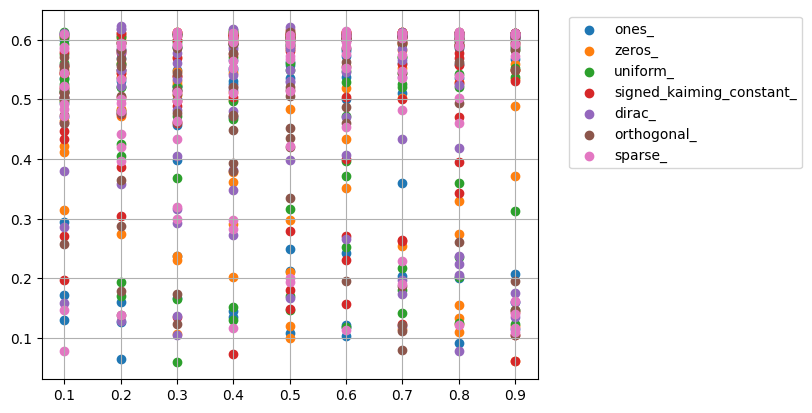

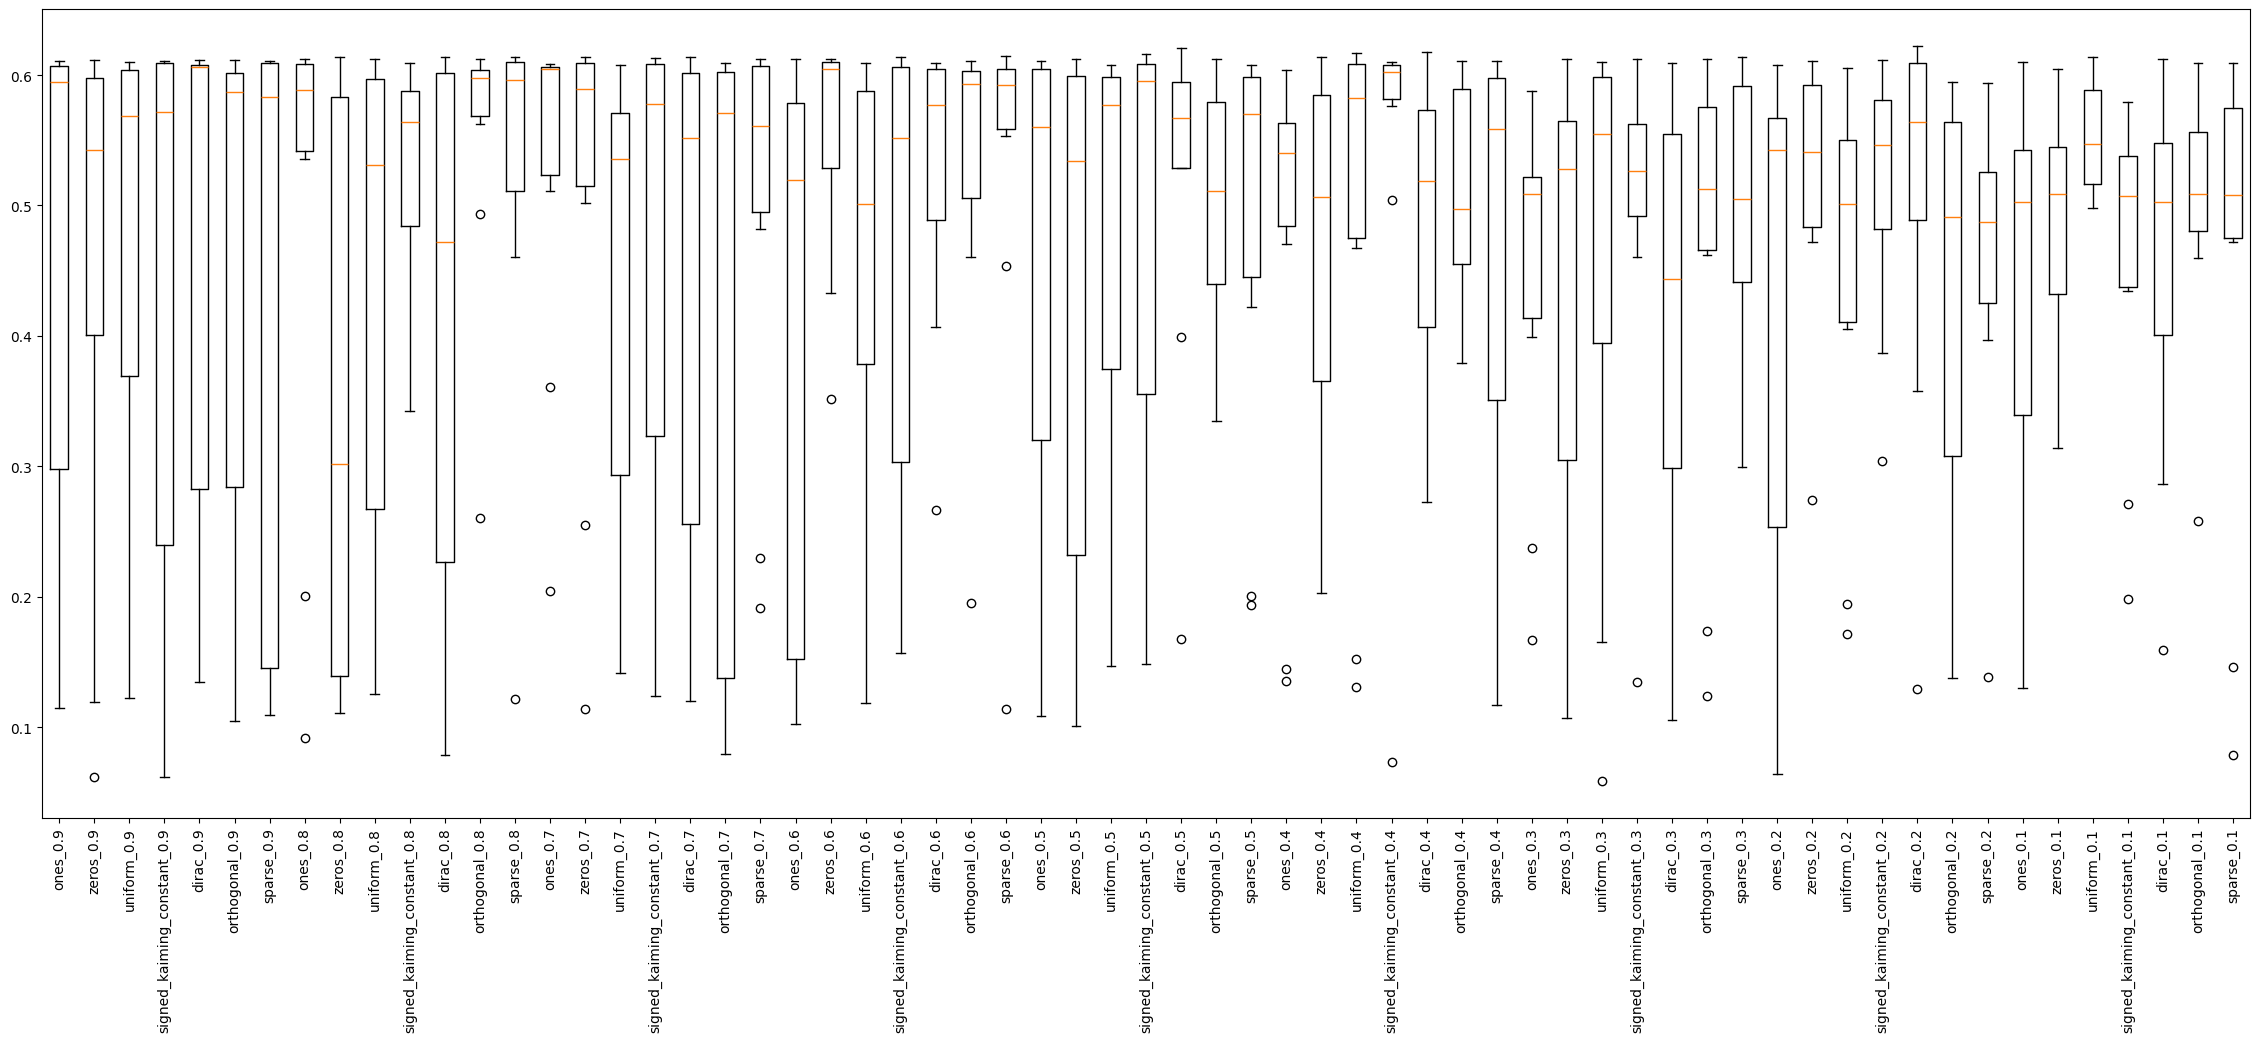

In [ ]:
# Plot the results of the previous cell.
fig, ax = plt.subplots()
for key,value in metrics_by_run.items():
  ax.scatter(*zip(*[x for x in value if (x[0]!=0.0 and x[0]!=1.0)]),label=key)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)


fig2, ax2 = plt.subplots()
ax2.boxplot([[x[1] for x in value if x[0]==i] for i in np.linspace(1.0,0,11) if i!=0 and i!=1 for key,value in metrics_by_run.items() if key!=''], tick_labels=[key.strip()+str(round(i,1)) for i in np.linspace(1.0,0,11) if i!=0 and i !=1 for key,value in metrics_by_run.items() if key!=''])
plt.xticks(rotation=90)
fig2.set_size_inches(28.5, 10.5)

# The jupyter backends call ``show()`` at the end of every cell by default.
# Thus, you usually don't have to call it explicitly there.
# plt.show()

Now, we'll try to find the best mask for each task using a fixed network.

In [ ]:
model = Network(layer_sizes=[[28*28, 512], [512,512], [512, 11]], maskable=True, k=0.5)

data_sets_to_test=['pathmnist','dermamnist','octmnist','pneumoniamnist','breastmnist','organamnist','organcmnist','organsmnist']

mask_dictionary = {}

for data_set_name in data_sets_to_test:
    best_mask, best_test, best_k = get_best_mask(model, data_set_name, NUM_EPOCHS=3, vary_k_by_layer=False, num_ks_to_test=11, return_to_initial_popup_scores = False, return_metrics=False, no_progress=False)
    mask_dictionary[data_set_name] = {'K':best_k,'mask':best_mask}
    print('Best Mask Identified for Dataset: '+data_set_name+'.')
    print('K='+str(best_k)+", Accuracy Achieved in Training: "+str(best_test))

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
------------------
K: (0.0,)


100%|██████████| 704/704 [01:39<00:00,  7.09it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.186
------------------
K: (0.1,)


100%|██████████| 704/704 [01:37<00:00,  7.20it/s]


==> Evaluating ...
test  auc: 0.759  acc:0.443
------------------
K: (0.2,)


100%|██████████| 704/704 [01:37<00:00,  7.21it/s]


==> Evaluating ...
test  auc: 0.758  acc:0.468
------------------
K: (0.30000000000000004,)


100%|██████████| 704/704 [01:38<00:00,  7.14it/s]


==> Evaluating ...
test  auc: 0.779  acc:0.466
------------------
K: (0.4,)


100%|██████████| 704/704 [01:38<00:00,  7.11it/s]


==> Evaluating ...
test  auc: 0.770  acc:0.455
------------------
K: (0.5,)


100%|██████████| 704/704 [01:38<00:00,  7.16it/s]


==> Evaluating ...
test  auc: 0.793  acc:0.479
------------------
K: (0.6000000000000001,)


100%|██████████| 704/704 [01:38<00:00,  7.17it/s]


==> Evaluating ...
test  auc: 0.789  acc:0.486
------------------
K: (0.7000000000000001,)


100%|██████████| 704/704 [01:38<00:00,  7.17it/s]


==> Evaluating ...
test  auc: 0.782  acc:0.452
------------------
K: (0.8,)


100%|██████████| 704/704 [01:38<00:00,  7.18it/s]


==> Evaluating ...
test  auc: 0.787  acc:0.465
------------------
K: (0.9,)


100%|██████████| 704/704 [01:37<00:00,  7.19it/s]


==> Evaluating ...
test  auc: 0.784  acc:0.475
------------------
K: (1.0,)


100%|██████████| 704/704 [01:37<00:00,  7.24it/s]


==> Evaluating ...
test  auc: 0.579  acc:0.146
Best Mask Identified for Dataset: pathmnist.
K=(0.6000000000000001,), Accuracy Achieved in Training: 0.485933147632312
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
------------------
K: (0.0,)


100%|██████████| 55/55 [00:07<00:00,  7.23it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.033
------------------
K: (0.1,)


100%|██████████| 55/55 [00:07<00:00,  7.29it/s]


==> Evaluating ...
test  auc: 0.476  acc:0.020
------------------
K: (0.2,)


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


==> Evaluating ...
test  auc: 0.444  acc:0.667
------------------
K: (0.30000000000000004,)


100%|██████████| 55/55 [00:07<00:00,  7.26it/s]


==> Evaluating ...
test  auc: 0.460  acc:0.668
------------------
K: (0.4,)


100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


==> Evaluating ...
test  auc: 0.484  acc:0.667
------------------
K: (0.5,)


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


==> Evaluating ...
test  auc: 0.499  acc:0.669
------------------
K: (0.6000000000000001,)


100%|██████████| 55/55 [00:07<00:00,  7.26it/s]


==> Evaluating ...
test  auc: 0.557  acc:0.660
------------------
K: (0.7000000000000001,)


100%|██████████| 55/55 [00:07<00:00,  7.15it/s]


==> Evaluating ...
test  auc: 0.590  acc:0.663
------------------
K: (0.8,)


100%|██████████| 55/55 [00:07<00:00,  7.18it/s]


==> Evaluating ...
test  auc: 0.640  acc:0.672
------------------
K: (0.9,)


100%|██████████| 55/55 [00:07<00:00,  7.14it/s]


==> Evaluating ...
test  auc: 0.689  acc:0.670
------------------
K: (1.0,)


100%|██████████| 55/55 [00:07<00:00,  7.18it/s]


==> Evaluating ...
test  auc: 0.540  acc:0.057
Best Mask Identified for Dataset: dermamnist.
K=(0.8,), Accuracy Achieved in Training: 0.6718204488778055


100%|██████████| 54.9M/54.9M [00:00<00:00, 67.0MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
------------------
K: (0.0,)


100%|██████████| 762/762 [01:33<00:00,  8.17it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.250
------------------
K: (0.1,)


100%|██████████| 762/762 [01:32<00:00,  8.23it/s]


==> Evaluating ...
test  auc: 0.574  acc:0.267
------------------
K: (0.2,)


100%|██████████| 762/762 [01:32<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.610  acc:0.297
------------------
K: (0.30000000000000004,)


100%|██████████| 762/762 [01:32<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.663  acc:0.331
------------------
K: (0.4,)


100%|██████████| 762/762 [01:32<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.683  acc:0.383
------------------
K: (0.5,)


100%|██████████| 762/762 [01:32<00:00,  8.25it/s]


==> Evaluating ...
test  auc: 0.704  acc:0.394
------------------
K: (0.6000000000000001,)


100%|██████████| 762/762 [01:32<00:00,  8.22it/s]


==> Evaluating ...
test  auc: 0.713  acc:0.371
------------------
K: (0.7000000000000001,)


100%|██████████| 762/762 [01:33<00:00,  8.17it/s]


==> Evaluating ...
test  auc: 0.727  acc:0.386
------------------
K: (0.8,)


100%|██████████| 762/762 [01:32<00:00,  8.22it/s]


==> Evaluating ...
test  auc: 0.718  acc:0.400
------------------
K: (0.9,)


100%|██████████| 762/762 [01:33<00:00,  8.19it/s]


==> Evaluating ...
test  auc: 0.732  acc:0.401
------------------
K: (1.0,)


100%|██████████| 762/762 [01:32<00:00,  8.27it/s]


==> Evaluating ...
test  auc: 0.559  acc:0.272
Best Mask Identified for Dataset: octmnist.
K=(0.9,), Accuracy Achieved in Training: 0.401
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
------------------
K: (0.0,)


100%|██████████| 37/37 [00:04<00:00,  8.29it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.375
------------------
K: (0.1,)


100%|██████████| 37/37 [00:04<00:00,  8.35it/s]


==> Evaluating ...
test  auc: 0.418  acc:0.375
------------------
K: (0.2,)


100%|██████████| 37/37 [00:04<00:00,  8.26it/s]


==> Evaluating ...
test  auc: 0.416  acc:0.375
------------------
K: (0.30000000000000004,)


100%|██████████| 37/37 [00:04<00:00,  8.26it/s]


==> Evaluating ...
test  auc: 0.411  acc:0.375
------------------
K: (0.4,)


100%|██████████| 37/37 [00:04<00:00,  8.05it/s]


==> Evaluating ...
test  auc: 0.408  acc:0.375
------------------
K: (0.5,)


100%|██████████| 37/37 [00:04<00:00,  8.27it/s]


==> Evaluating ...
test  auc: 0.408  acc:0.375
------------------
K: (0.6000000000000001,)


100%|██████████| 37/37 [00:04<00:00,  8.31it/s]


==> Evaluating ...
test  auc: 0.408  acc:0.375
------------------
K: (0.7000000000000001,)


100%|██████████| 37/37 [00:04<00:00,  8.38it/s]


==> Evaluating ...
test  auc: 0.720  acc:0.659
------------------
K: (0.8,)


100%|██████████| 37/37 [00:04<00:00,  8.35it/s]


==> Evaluating ...
test  auc: 0.802  acc:0.763
------------------
K: (0.9,)


100%|██████████| 37/37 [00:04<00:00,  8.20it/s]


==> Evaluating ...
test  auc: 0.777  acc:0.752
------------------
K: (1.0,)


100%|██████████| 37/37 [00:04<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.625  acc:0.381
Best Mask Identified for Dataset: pneumoniamnist.
K=(0.8,), Accuracy Achieved in Training: 0.7628205128205128
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
------------------
K: (0.0,)


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.269
------------------
K: (0.1,)


100%|██████████| 5/5 [00:00<00:00,  8.39it/s]


==> Evaluating ...
test  auc: 0.652  acc:0.269
------------------
K: (0.2,)


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


==> Evaluating ...
test  auc: 0.646  acc:0.269
------------------
K: (0.30000000000000004,)


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


==> Evaluating ...
test  auc: 0.631  acc:0.269
------------------
K: (0.4,)


100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


==> Evaluating ...
test  auc: 0.617  acc:0.269
------------------
K: (0.5,)


100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


==> Evaluating ...
test  auc: 0.584  acc:0.269
------------------
K: (0.6000000000000001,)


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


==> Evaluating ...
test  auc: 0.636  acc:0.269
------------------
K: (0.7000000000000001,)


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


==> Evaluating ...
test  auc: 0.719  acc:0.288
------------------
K: (0.8,)


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


==> Evaluating ...
test  auc: 0.451  acc:0.731
------------------
K: (0.9,)


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


==> Evaluating ...
test  auc: 0.548  acc:0.699
------------------
K: (1.0,)


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


==> Evaluating ...
test  auc: 0.311  acc:0.545
Best Mask Identified for Dataset: breastmnist.
K=(0.8,), Accuracy Achieved in Training: 0.7307692307692307


100%|██████████| 38.2M/38.2M [00:00<00:00, 52.1MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
------------------
K: (0.0,)


100%|██████████| 271/271 [00:33<00:00,  8.11it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.058
------------------
K: (0.1,)


100%|██████████| 271/271 [00:33<00:00,  8.18it/s]


==> Evaluating ...
test  auc: 0.605  acc:0.133
------------------
K: (0.2,)


100%|██████████| 271/271 [00:32<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.714  acc:0.246
------------------
K: (0.30000000000000004,)


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


==> Evaluating ...
test  auc: 0.869  acc:0.528
------------------
K: (0.4,)


100%|██████████| 271/271 [00:32<00:00,  8.23it/s]


==> Evaluating ...
test  auc: 0.911  acc:0.591
------------------
K: (0.5,)


100%|██████████| 271/271 [00:32<00:00,  8.23it/s]


==> Evaluating ...
test  auc: 0.929  acc:0.628
------------------
K: (0.6000000000000001,)


100%|██████████| 271/271 [00:33<00:00,  8.20it/s]


==> Evaluating ...
test  auc: 0.935  acc:0.651
------------------
K: (0.7000000000000001,)


100%|██████████| 271/271 [00:32<00:00,  8.30it/s]


==> Evaluating ...
test  auc: 0.940  acc:0.666
------------------
K: (0.8,)


100%|██████████| 271/271 [00:32<00:00,  8.31it/s]


==> Evaluating ...
test  auc: 0.941  acc:0.672
------------------
K: (0.9,)


100%|██████████| 271/271 [00:32<00:00,  8.32it/s]


==> Evaluating ...
test  auc: 0.938  acc:0.671
------------------
K: (1.0,)


100%|██████████| 271/271 [00:32<00:00,  8.27it/s]


==> Evaluating ...
test  auc: 0.510  acc:0.126
Best Mask Identified for Dataset: organamnist.
K=(0.8,), Accuracy Achieved in Training: 0.6715041061986725


100%|██████████| 15.5M/15.5M [00:00<00:00, 68.3MB/s]


Using downloaded and verified file: /root/.medmnist/organcmnist.npz
Using downloaded and verified file: /root/.medmnist/organcmnist.npz
------------------
K: (0.0,)


100%|██████████| 102/102 [00:12<00:00,  8.20it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.101
------------------
K: (0.1,)


100%|██████████| 102/102 [00:12<00:00,  8.27it/s]


==> Evaluating ...
test  auc: 0.709  acc:0.276
------------------
K: (0.2,)


100%|██████████| 102/102 [00:12<00:00,  8.28it/s]


==> Evaluating ...
test  auc: 0.821  acc:0.430
------------------
K: (0.30000000000000004,)


100%|██████████| 102/102 [00:12<00:00,  8.18it/s]


==> Evaluating ...
test  auc: 0.872  acc:0.509
------------------
K: (0.4,)


100%|██████████| 102/102 [00:12<00:00,  8.23it/s]


==> Evaluating ...
test  auc: 0.894  acc:0.565
------------------
K: (0.5,)


100%|██████████| 102/102 [00:12<00:00,  8.32it/s]


==> Evaluating ...
test  auc: 0.904  acc:0.606
------------------
K: (0.6000000000000001,)


100%|██████████| 102/102 [00:12<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.918  acc:0.640
------------------
K: (0.7000000000000001,)


100%|██████████| 102/102 [00:12<00:00,  8.17it/s]


==> Evaluating ...
test  auc: 0.924  acc:0.671
------------------
K: (0.8,)


100%|██████████| 102/102 [00:12<00:00,  8.23it/s]


==> Evaluating ...
test  auc: 0.930  acc:0.685
------------------
K: (0.9,)


100%|██████████| 102/102 [00:12<00:00,  8.22it/s]


==> Evaluating ...
test  auc: 0.929  acc:0.684
------------------
K: (1.0,)


100%|██████████| 102/102 [00:12<00:00,  8.20it/s]


==> Evaluating ...
test  auc: 0.510  acc:0.111
Best Mask Identified for Dataset: organcmnist.
K=(0.8,), Accuracy Achieved in Training: 0.6846397273612463


100%|██████████| 16.5M/16.5M [00:00<00:00, 69.0MB/s]


Using downloaded and verified file: /root/.medmnist/organsmnist.npz
Using downloaded and verified file: /root/.medmnist/organsmnist.npz
------------------
K: (0.0,)


100%|██████████| 109/109 [00:13<00:00,  8.17it/s]


==> Evaluating ...
test  auc: 0.500  acc:0.092
------------------
K: (0.1,)


100%|██████████| 109/109 [00:13<00:00,  8.18it/s]


==> Evaluating ...
test  auc: 0.708  acc:0.297
------------------
K: (0.2,)


100%|██████████| 109/109 [00:13<00:00,  8.19it/s]


==> Evaluating ...
test  auc: 0.771  acc:0.334
------------------
K: (0.30000000000000004,)


100%|██████████| 109/109 [00:13<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.799  acc:0.376
------------------
K: (0.4,)


100%|██████████| 109/109 [00:13<00:00,  8.19it/s]


==> Evaluating ...
test  auc: 0.819  acc:0.402
------------------
K: (0.5,)


100%|██████████| 109/109 [00:13<00:00,  8.19it/s]


==> Evaluating ...
test  auc: 0.838  acc:0.416
------------------
K: (0.6000000000000001,)


100%|██████████| 109/109 [00:13<00:00,  8.22it/s]


==> Evaluating ...
test  auc: 0.852  acc:0.440
------------------
K: (0.7000000000000001,)


100%|██████████| 109/109 [00:13<00:00,  8.22it/s]


==> Evaluating ...
test  auc: 0.868  acc:0.460
------------------
K: (0.8,)


100%|██████████| 109/109 [00:13<00:00,  8.19it/s]


==> Evaluating ...
test  auc: 0.877  acc:0.480
------------------
K: (0.9,)


100%|██████████| 109/109 [00:13<00:00,  8.27it/s]


==> Evaluating ...
test  auc: 0.876  acc:0.479
------------------
K: (1.0,)


100%|██████████| 109/109 [00:13<00:00,  8.24it/s]


==> Evaluating ...
test  auc: 0.512  acc:0.122
Best Mask Identified for Dataset: organsmnist.
K=(0.8,), Accuracy Achieved in Training: 0.47966466523167556


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
==> Evaluating ...
test  auc: 0.789  acc:0.486
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
==> Evaluating ...
test  auc: 0.640  acc:0.672
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
==> Evaluating ...
test  auc: 0.732  acc:0.401
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
==> Evaluating ...
test  auc: 0.802  acc:0.763
Using

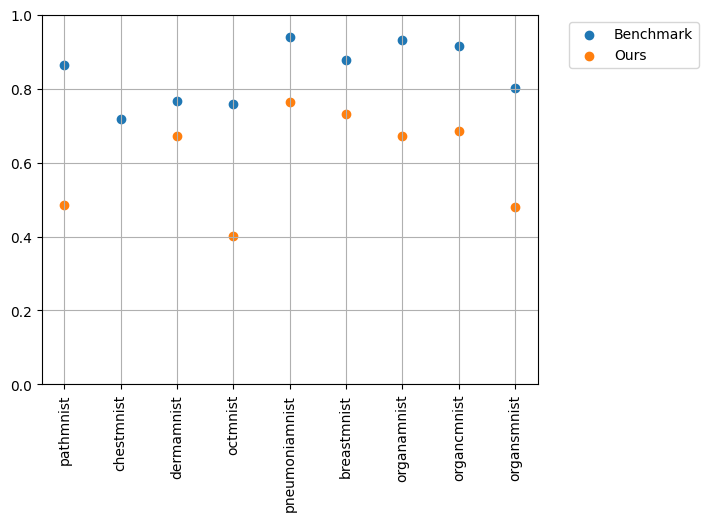

In [ ]:
best_from_benchmark = [('pathmnist',0.864),('chestmnist',0.718), ('dermamnist',0.766), ('octmnist','0.758'),('pneumoniamnist',0.941), ('breastmnist',0.878), ('organamnist',0.931), ('organcmnist',0.915), ('organsmnist',0.803)]
best_from_subnet_search = []
for data_set_name in data_sets_to_test:
  info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
  for i, layer in enumerate(model.linear_relu_stack[::2]):
    layer.popup_scores= nn.Parameter(mask_dictionary[data_set_name]['mask'][i])
    if len(mask_dictionary[data_set_name]['K'])>1:
      layer.k = mask_dictionary[data_set_name]['K'][i]
    else:
      layer.k = mask_dictionary[data_set_name]['K'][0]
  print('==> Evaluating ...')
  best_from_subnet_search.append((data_set_name,test('test' , model, train_loader_at_eval, test_loader, task, n_classes, data_set_name,return_metrics=True)[1]))

fig, ax = plt.subplots()
ax.scatter(x=[i[0] for i in best_from_benchmark],y=[i[1] for i in best_from_benchmark],label='Benchmark')
ax.scatter(x=[i[0] for i in best_from_subnet_search],y=[i[1] for i in best_from_subnet_search],label='Ours')
plt.xticks(rotation=90)
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
